## Low-Level Sound Descriptors

Low-level sound descriptors are closely related to the signal characteristics of a sound. 

They are used to describe the signal at different levels of granularity. 

There are at least three levels of extraction granularity from the signal: at any point in the signal (**instantaneous**), in small arbitrary regions (i.e., frames), and longer pre-segmented regions (e.g. global). 

Low-level descriptors are used to extract information from the signal that can be used to describe the sound. 

They are used in many applications, including music information retrieval, speech recognition, and audio signal processing



In [492]:
import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
matplotlib #inline

<module 'matplotlib' from 'c:\\Users\\migam\\miniconda3\\envs\\SAM\\lib\\site-packages\\matplotlib\\__init__.py'>

Here we have some helper code for this assignment.

In [493]:
def stft_basic(x, w, H=8, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Notebook: C2/C2_STFT-Basic.ipynb

    Args:
        x: Signal to be transformed
        w: Window function
        H: Hopsize
        only_positive_frequencies: Return only positive frequency part of spectrum (non-invertible)

    Returns:
        X: The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win
        
    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
    return X

def compute_stft(x, fs):
    # STFT Parameterisation and computation
    H = 1024
    N = 2048
    w = np.hanning(N)
    X = stft_basic(x, w, H)
    Y = np.abs(X) ** 2
    eps = np.finfo(float).eps
    Y_db = 10 * np.log10(Y + eps)

    T_coef = np.arange(X.shape[1]) * H / fs
    F_coef = np.arange(X.shape[0]) * fs / N
    left = min(T_coef)
    right = max(T_coef) + N / fs
    lower = min(F_coef)
    upper = max(F_coef)
    return left, right, lower, upper

def log_attack_time(y, fs, start=0.2, end=0.9):
    # adapted from http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html
    th0 = start * max(y)
    th1 = end * max(y)
    th0_cross = np.diff(y > th0, prepend=False)
    th1_cross = np.diff(y > th1, prepend=False)

    # Get the index where the signal cross the threshold
    index0 = np.argwhere(th0_cross)[0,0]
    index1 = np.argwhere(th1_cross)[0,0]
    
    # Convert index to time
    T0 = index0 / fs
    T1 = index1 / fs

    # Compute Log Attack Time
    attack_time = T1 - T0
    log_attack_time = np.log10(attack_time)
    return log_attack_time


def effective_duration(y, fs, threshold=0.05):
    rms = librosa.feature.rms(y=y)
    th = threshold*max(rms[0])
    samples_above = np.count_nonzero(rms > th)
    effective_duration = samples_above/len(rms[0])*librosa.get_duration(y=y, sr=fs)
    return effective_duration

def temporal_centroid(y, fs):
    """
    adapted from https://www.audiocontentanalysis.org/code/audio-features/spectral-centroid-2/
    computes the temporal centroid from the waveform
    """
    norm = y.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1
    vtc = np.dot(np.arange(0, y.shape[0]), y) / norm
    # convert from index to seconds
    vtc = vtc / fs
    vtc = np.squeeze(vtc)
    return vtc


def spectral_flux(y):
    """
    adapted from https://www.audiocontentanalysis.org/code/audio-features/spectral-flux-2/
    computes the spectral flux from the magnitude spectrum
    """
    mag_fft = np.abs(librosa.stft(y))
    isSpectrum = mag_fft.ndim == 1
    if isSpectrum:
        mag_fft = np.expand_dims(mag_fft, axis=1)
    # difference spectrum (set first diff to zero)
    mag_fft = np.c_[mag_fft[:, 0], mag_fft]
    afDeltaX = np.diff(mag_fft, 1, axis=1)
    # flux
    vsf = np.sqrt((afDeltaX**2).sum(axis=0)) / mag_fft.shape[0]
    vsf = np.expand_dims(vsf, axis=0)
    return vsf

### Time-domain:
   
#### Instantaneous

**RMS/Energy**

`rms = librosa.feature.rms(x)`

**Zero Crossing Rate** 
> The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. Periodic sounds tend to have a small value of it, while noisy sounds tend to have a high value of it.

`zcr = librosa.feature.zero_crossing_rate(x)`

#### Global
     
**Log-attack time**
> The attack time is defined as the time duration from when the sound becomes perceptually audible to when it reaches its maximum intensity. The start of the attack is estimated as the point where the signal envelope reaches a threshold (by default 20%) of its maximum value (in order to account for possible noise presence), and the end of the attack is estimated as as the point where the signal envelope has reached a threshold (by default 90%) of its maximum value, in order to account for the possibility that the max value occurres after the logAttack, as in trumpet sounds.      

`lat = log_attack_time(x, fs, start=0.2, end=0.9)`

**Temporal centroid**
>  Temporal centroid is the temporal correspondent of the spectral centroid: it's the center of gravity of the energy envelope. It has been proved to be one perceptually important descriptor.

`tc= temporal_centroid(y, fs)`

**Effective duration** 
> The effective duration is a measure of the time the signal is perceptually meaningful. It is approximated by the time the energy envelop is above a given threshold.

`ed = effective_duration(x, fs, threshold=0.05)`

### Frequency-domain:

#### Instantaneous

**Spectral centroid**
> The spectral centroid indicates where the center of mass (or gravity) of the spectrum is located. Perceptually, it has  a robust connection with the impression of brightness of a sound.

`spec_cent = librosa.feature.spectral_centroid(x, sr=fs)`

**Spectral spread / spectral bandwidth**
> It is a measure of how the spectrum is distributed around the spectral centroid and it defines the variance from the spectral centroid.

`spec_bw = librosa.feature.spectral_bandwidth(x, sr=fs)`

**Spectral variation / spectral flux**
> Spectral flux is a measure of how quickly the power spectrum of a signal is changing, calculated by comparing the power spectrum for one frame against the power spectrum from the previous frame

`spec_flux = spectral_flux(x)`

**Spectral flatness** 
> Spectral flatness is a way to quantify how close a sound is to being noise or a tone. A high spectral flatness (approaching 1.0 for white noise) indicates that the spectrum has a similar amount of power in all spectral bands.

`spectral_flatness = librosa.feature.spectral_flatness(y=x)`


## Example

As an illustrative example, we consider a recording of a C-major scale played on a piano. 

<img src="./data/example/FMP_C2_F10a.png" width="300px" align="left" alt="C0">

<br clear="all" />

<audio src="./data/example/FMP_C2_F10.wav" type="audio/mpeg" controls="controls"></audio>

In the following figure, the spectrogram representation of the recording is shown, where the time and frequency axes are labeled in a physically meaningful way. Furthermore, the spectrogram is also shown using a logarithmic dB scale (to enhance small sound components that may still be perceptually relevant).

The spectrogram reveals the frequency information of the played notes over time. For each note, one can observe horizontal lines that are stacked on top of each other. These equally spaced lines correspond to the partials, the integer multiples of the fundamental frequency of a note. Obviously, the higher partials contain less and less of the signal's energy. Furthermore, the decay of each note over time is reflected by the fading out of the horizontal lines.


<!-- <img src="./data/FMP_C2_F10.png" width="500px" align="middle" alt="C0"> -->

Now we load the sound file and plot the waveform (time-domain) as well as the spectrogram (time-frequency).

Note: The spectrogram reveals the frequency information of the played notes over time. For each note, one can observe horizontal lines that are stacked on top of each other. These equally spaced lines correspond to the partials, the integer multiples of the fundamental frequency of a note. Obviously, the higher partials contain less and less of the signal's energy. Furthermore, the decay of each note over time is reflected by the fading out of the horizontal lines.

In [494]:
fn_wav = os.path.join('.', 'data','example', 'FMP_C2_F10.wav')
x, fs = librosa.load(fn_wav)

And we plot the waveform and some time-based sound descriptors:

lat:0.3841733255983914
ed:7.28042328042328
tc:5.156217575073242


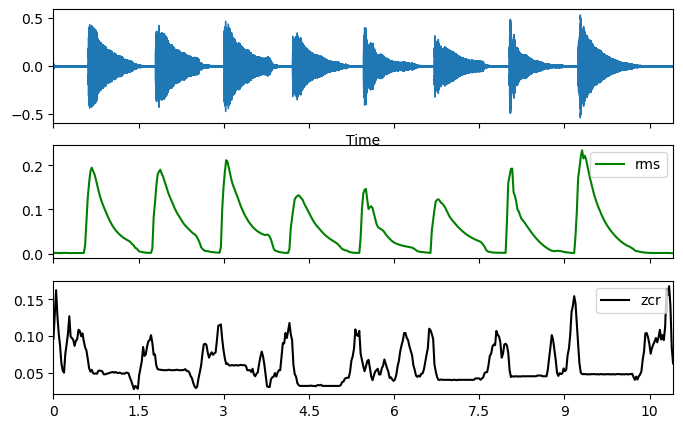

In [495]:
# Figure
fig_time,axs_time = plt.subplots(3,1, figsize=(8, 5), sharex=True)

t = np.arange(len(x)) / fs
librosa.display.waveshow(x, sr=fs, ax=axs_time[0])
axs_time[0].set_xlim([min(t), max(t)])

# Add the rms (from librosa)
rms = librosa.feature.rms(y=x)
times = librosa.times_like(rms) # times will be the same for all features
axs_time[1].plot(times, rms.T, label='rms', color='g')
axs_time[1].legend(loc='upper right')

zcr = librosa.feature.zero_crossing_rate(x)
axs_time[2].plot(times, zcr.T, label='zcr', color='k')
axs_time[2].legend(loc='upper right')

lat = log_attack_time(x, fs, start=0.2, end=0.9)
print(f'lat:{lat}')

ed= effective_duration(x, fs, threshold=0.05)
print(f'ed:{ed}')

tc = temporal_centroid(x, fs)
print(f'tc:{tc}')

Now we plot the spectrogram and some frequency-based sound descriptors.

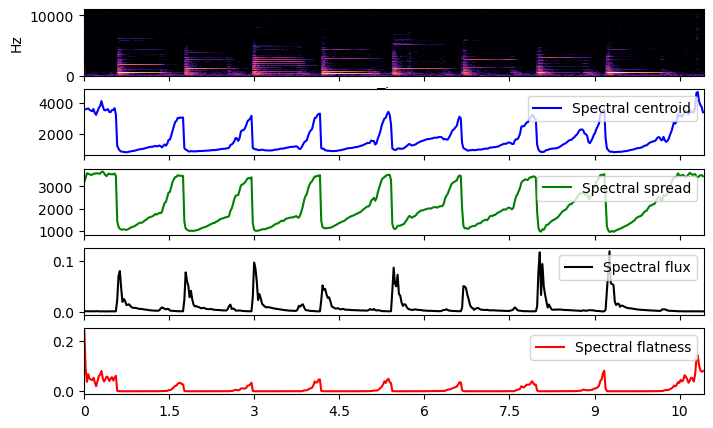

In [496]:
# Figure
fig_freq,axs_freq = plt.subplots(5,1, figsize=(8, 5), sharex=True)

D = librosa.stft(x)  # STFT
# Get Spectrogram in dB
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axs_freq[0]) 

# Add the spectral centroid (from librosa)
spec_cent = librosa.feature.spectral_centroid(y=x, sr=fs)
times = librosa.times_like(spec_cent)
axs_freq[1].plot(times, spec_cent.T, label='Spectral centroid', color='b')
axs_freq[1].legend(loc='upper right')

spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
axs_freq[2].plot(times, spec_bw.T, label='Spectral spread', color='g')
axs_freq[2].legend(loc='upper right')


spec_flux = spectral_flux(x)
axs_freq[3].plot(times, spec_flux.T, label='Spectral flux', color='k')
axs_freq[3].legend(loc='upper right')
      
spec_flat = librosa.feature.spectral_flatness(y=x)
axs_freq[4].plot(times, spec_flat.T, label='Spectral flatness', color='r')
axs_freq[4].legend(loc='upper right')


# Assignment

### Goal
The goal of this assignment is to accomplish a step-by-step audio classification system.
While pursuing this goal, we will be able to understand, implement and evaluate a simple set of low-level audio descriptors and analyse their distribution over a collection of sounds.  
The chosen sounds are samples of isolated notes from musical instruments, and we will be evaluating the classification over 2 dimensions: 
* Instrument excitation: *percussive* vs *non-percussive*. These are found by the existence of `pizz` on the filename
* Instrument type: the name of the instrument (e.g. accordion, flute, cello, etc.). The first letters of the filename give the name of the instrument.





## Task 1
### Sound Descriptors
Please review briefly the paper by Peeters (Peeters, 2004) [“A large set of audio features for sound description (similarity and classification) in the cuidado project"](http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf), to make sure that you understand the following descriptors:

#### Time-domain:
**Instantaneous**
1. RMS/Energy; 2. Zero Crossing Rate 
**Global**
3. Log-attack time; 4. Temporal centroid; 5. Effective duration 

#### Frequency-domain:
**Instantaneous**
6. Spectral centroid; 7. Spectral spread; 8. Spectral variation / spectral flux; 9. Spectral flatness 

Please pick 2 descriptors by group (one from time-domain and another from frequency-domain), depart from the formula and explain the theoretical expected values for a *sinusoid* and *white noise*. 



## Task 1 answer

Time-domain:
* RMS/Energy: 
The RMS/Energy descriptor is the energy (loudness) of a sound in a given moment, that energy is directly related to the amplitude of the corresponding sine wave.
    * Sinusoid: assuming the sound wave keeps the same amplitude over time, the RMS graph would look line a horizontal line. If, on the other hand, the sound wave amplitude decreases steadly, aka the sound becomes quieter, the RMS graph will be a straight line with a negative incline.  
    * white noise: The RMS graph a near horizontal line.
    
* Spectral flatness
The spectral flatness ...
    * Sinusoid: Assuming the sound wave keeps the same amplitude over time, the Spectral flatness graph would look line a horizontal line at y~0. If, on the other hand, the sound wave amplitude decreases steadly, aka the sound becomes quieter, the RMS graph will be a curve from ~0 to ~1, it reaches ~1 when the sound wave amplitude is near 0.
    * white noise: The Spectral flatness graph is a horizontal line near y~1.

## Task 2

### Exploratory Data Analysis

Implement a function to obtain, for a given audio file, the mentioned set of instantaneous descriptors (1,2,6-9), the mentioned set of global descriptors (3,4,5), as well as statistics of the previous instantaneous (1,2,6-9) descriptors (e.g. mean, standard deviation, min, max).

2.1. Create plots to visualize the extracted instantaneous low-level descriptors and study their evolution for a small set of instrument samples (e.g. percussive, string, wind instrument). 

2.2. Study the values of these descriptors for the previous instrumental samples and analyse how they represent the following aspects: percussive/non-percussive sounds, sustained/non sustained, low-pitch/high pitch, and instrument.
In order to do that, you can build 2-D plots visualizing the values of 2 descriptors for the different samples, e.g.:
-	Spectral Flux mean vs Spectral Spread mean
-	Spectral Flux mean vs Spectral Flatness
-	Spectral Centroid mean vs Zero Crossing Rate mean
-	Temporal Centroid vs Log Attack Time.

2.3. Do you think these descriptors are enough to accomplish both classifications or you feel the need for more descriptors? (You may come to this question again after you have tried the classification )

In [497]:
from IPython.display import Audio
import IPython

vln_pizz_wav = os.path.join('.', 'data','sounds', 'vln_e_C5_12_pizz.wav')
cbs_pizz_wav = os.path.join('.', 'data','sounds', 'cbs_g_C2_12_pizz.wav')

vln_wav = os.path.join('.', 'data','sounds', 'vln_a_G4_12.wav')
hrp_wav = os.path.join('.', 'data','sounds', 'hrp_G4_12.wav')

trp_wav = os.path.join('.', 'data', 'sounds', 'trp_G4_12.wav')
sax_wav = os.path.join('.', 'data', 'sounds', 'sax_G4_12.wav')

vln_pizz_wave, vln_pizz_fs = librosa.load(vln_pizz_wav)
cbs_pizz_wave, cbs_pizz_fs = librosa.load(cbs_pizz_wav)

vln_wave, vln_fs = librosa.load(vln_wav)
hrp_wave, hrp_fs = librosa.load(hrp_wav)

trp_wave, trp_fs = librosa.load(trp_wav)
sax_wave, sax_fs = librosa.load(sax_wav)

IPython.display.display(Audio(data=vln_pizz_wave, rate=vln_pizz_fs))
IPython.display.display(Audio(data=cbs_pizz_wave, rate=cbs_pizz_fs))

IPython.display.display(Audio(data=vln_wave, rate=vln_fs))
IPython.display.display(Audio(data=hrp_wave, rate=hrp_fs))

IPython.display.display(Audio(data=trp_wave, rate=trp_fs))
IPython.display.display(Audio(data=sax_wave, rate=sax_fs))

In [498]:
soundsDict = {}

def basic_plots(name):
    soundsDict[name] = []
    fileName = os.path.join('.', 'data','sounds', name)
    wave, fs = librosa.load(fileName)

    # Figure
    fig_time,axs_time = plt.subplots(3,1, figsize=(8, 5), sharex=True)

    t = np.arange(len(wave)) / fs
    librosa.display.waveshow(wave, sr=fs, ax=axs_time[0])
    axs_time[0].set_xlim([min(t), max(t)])

    # Add the rms (from librosa)
    rms = librosa.feature.rms(y=wave)
    times = librosa.times_like(rms) # times will be the same for all features
    axs_time[1].plot(times, rms.T, label='rms', color='g')
    axs_time[1].legend(loc='upper right')

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(wave)
    axs_time[2].plot(times, zcr.T, label='zcr', color='k')
    axs_time[2].legend(loc='upper right')

    # Figure
    fig_freq,axs_freq = plt.subplots(5,1, figsize=(8, 5), sharex=True)

    D = librosa.stft(wave)  # STFT
    # Get Spectrogram in dB
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axs_freq[0]) 

    # Add the spectral centroid (from librosa)
    spec_cent = librosa.feature.spectral_centroid(y=wave, sr=fs)
    times = librosa.times_like(spec_cent)
    axs_freq[1].plot(times, spec_cent.T, label='Spectral centroid', color='b')
    axs_freq[1].legend(loc='upper right')

    spec_bw = librosa.feature.spectral_bandwidth(y=wave, sr=fs)
    axs_freq[2].plot(times, spec_bw.T, label='Spectral spread', color='g')
    axs_freq[2].legend(loc='upper right')


    spec_flux = spectral_flux(wave)
    axs_freq[3].plot(times, spec_flux.T, label='Spectral flux', color='k')
    axs_freq[3].legend(loc='upper right')

    spec_flat = librosa.feature.spectral_flatness(y=wave)
    axs_freq[4].plot(times, spec_flat.T, label='Spectral flatness', color='r')
    axs_freq[4].legend(loc='upper right')

    rms_average = np.average(rms)
    rms_std = np.std(rms)
    soundsDict[name].append(rms_average)
    soundsDict[name].append(rms_std)
    

    zcr_average = np.average(zcr)
    zcr_std = np.std(zcr)
    soundsDict[name].append(zcr_average)
    soundsDict[name].append(zcr_std)

    spec_cent_average = np.average(spec_cent)
    spec_cent_std = np.std(spec_cent)
    soundsDict[name].append(spec_cent_average)
    soundsDict[name].append(spec_cent_std)

    spec_bw_average = np.average(spec_bw)
    spec_bw_std = np.std(spec_bw)
    soundsDict[name].append(spec_bw_average)
    soundsDict[name].append(spec_bw_std)

    spec_flux_average = np.average(spec_flux)
    spec_flux_std = np.std(spec_flux)
    soundsDict[name].append(spec_flux_average)
    soundsDict[name].append(spec_flux_std)

    spec_flat_average = np.average(spec_flat)
    spec_flat_std = np.std(spec_flat)
    soundsDict[name].append(spec_flat_average)
    soundsDict[name].append(spec_flat_std)
    
    lat = log_attack_time(wave, fs, start=0.01, end=0.99)
    soundsDict[name].append(lat)
    print(f'log attack time:{lat}')

    ed= effective_duration(wave, fs, threshold=0.05)
    soundsDict[name].append(ed)
    print(f'effective duration:{ed}')

    tc = temporal_centroid(wave, fs)
    soundsDict[name].append(tc)
    print(f'temporal centroid:{tc}')

log attack time:-1.4800857336834015
effective duration:0.7185921744584358
temporal centroid:0.544092059135437


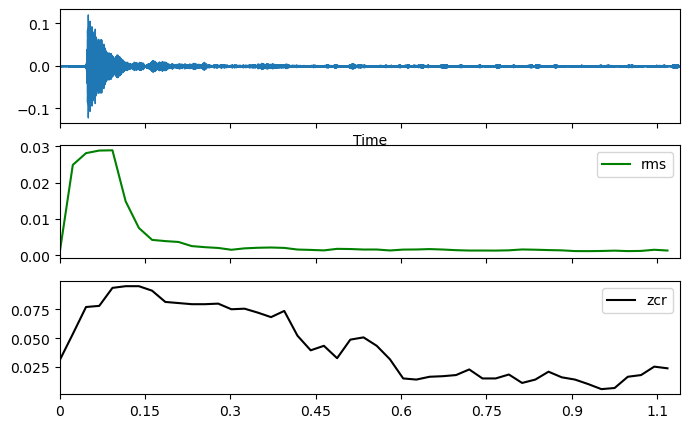

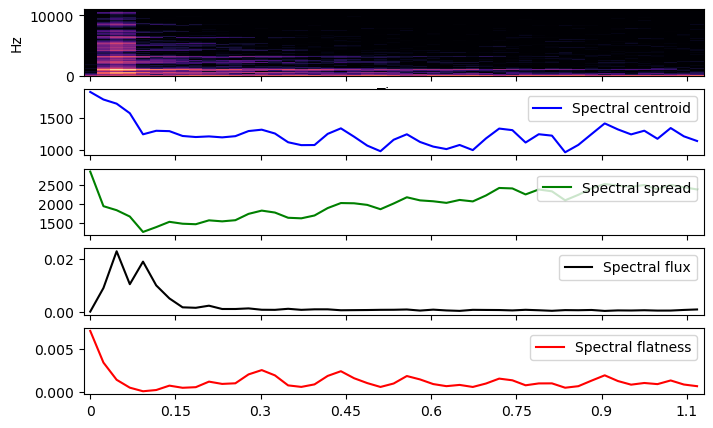

In [499]:
files = [
'vln_e_C5_12_pizz.wav','cbs_g_C2_12_pizz.wav','vln_a_G4_12.wav',
'hrp_G4_12.wav', 'trp_G4_12.wav','sax_G4_12.wav']

basic_plots(files[0])

log attack time:-1.7069206974504918
effective duration:2.5463619365875005
temporal centroid:11.932703018188477


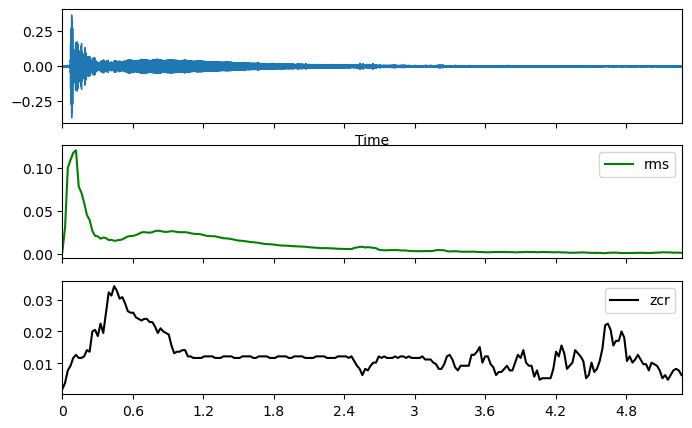

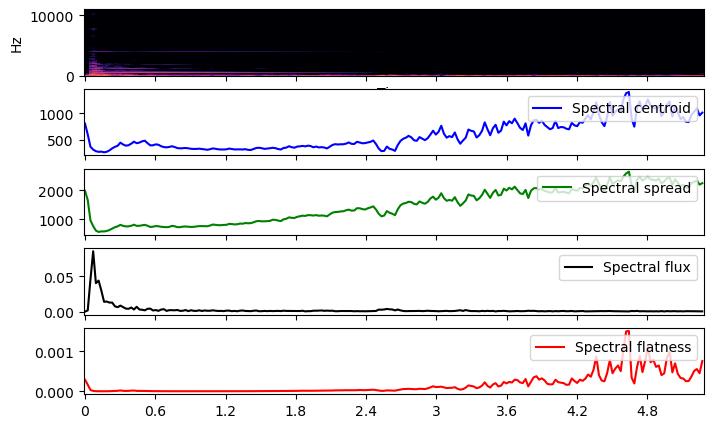

In [500]:
basic_plots(files[1])

log attack time:0.6425026541274155
effective duration:9.45185766614338
temporal centroid:3.565584182739258


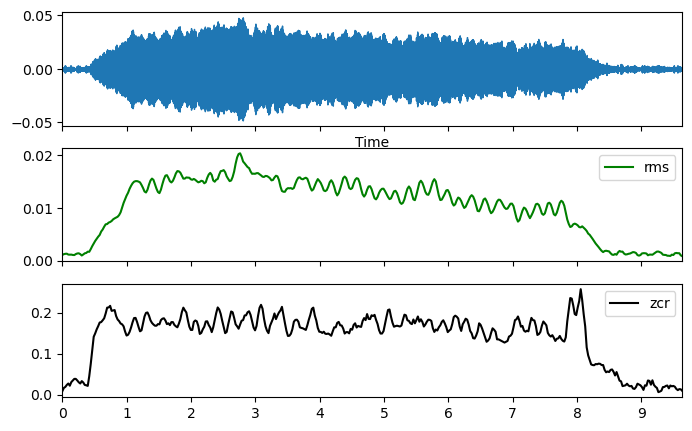

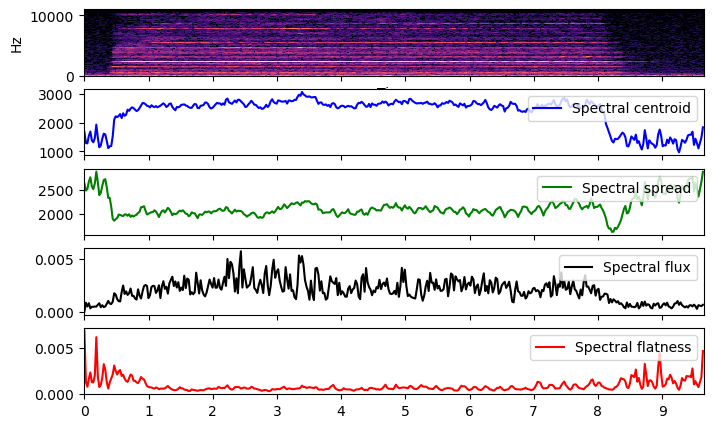

In [501]:
basic_plots(files[2])

log attack time:-1.9454685851318196
effective duration:0.9508933120573333
temporal centroid:1.5920501947402954


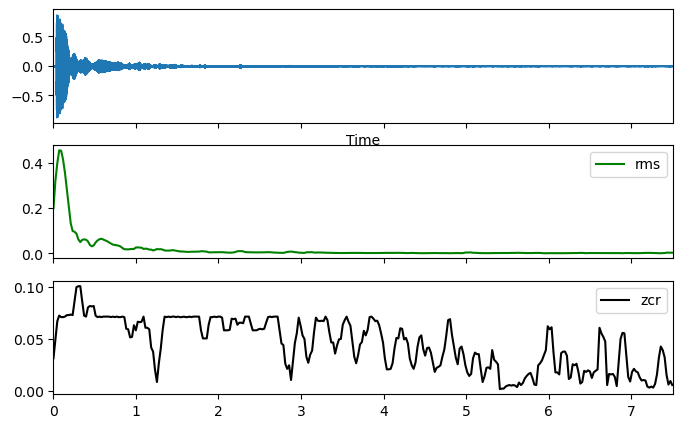

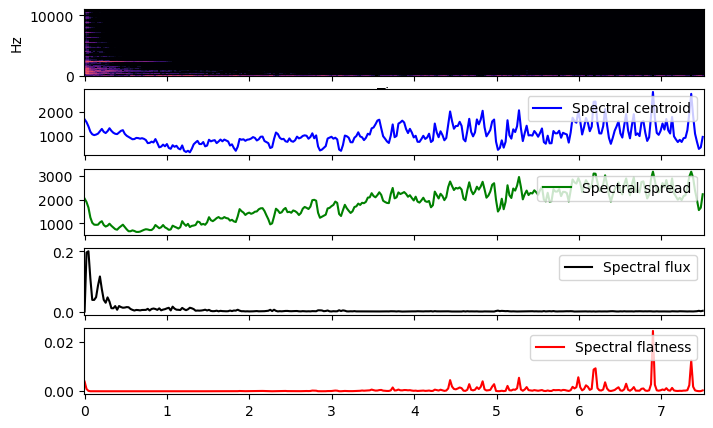

In [502]:
basic_plots(files[3])

log attack time:0.1316375743239404
effective duration:6.209705215419501
temporal centroid:7.90537691116333


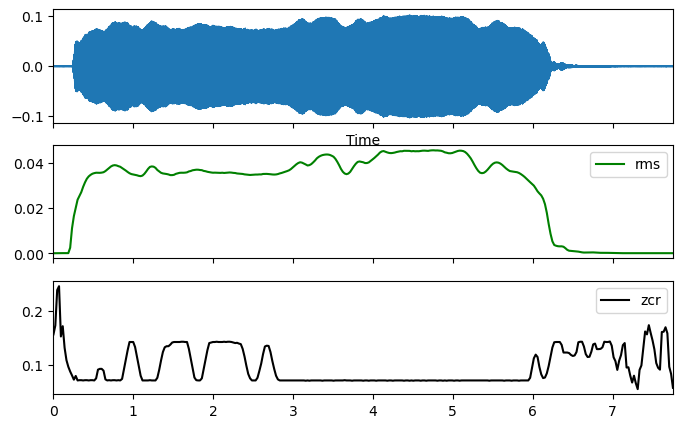

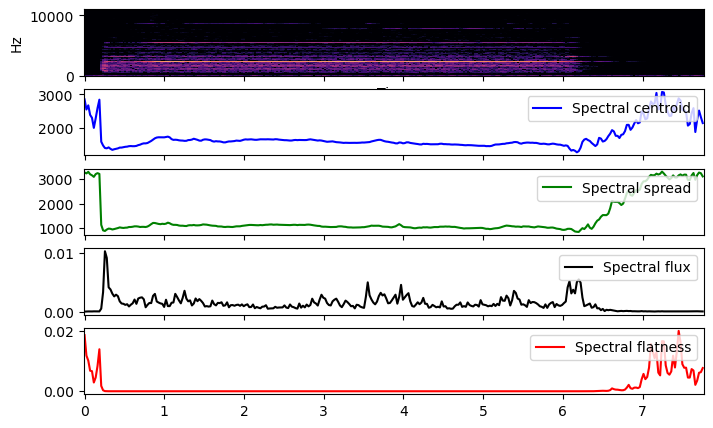

In [503]:
basic_plots(files[4])

log attack time:0.5611879503829972
effective duration:10.432212532590128
temporal centroid:3.3182153701782227


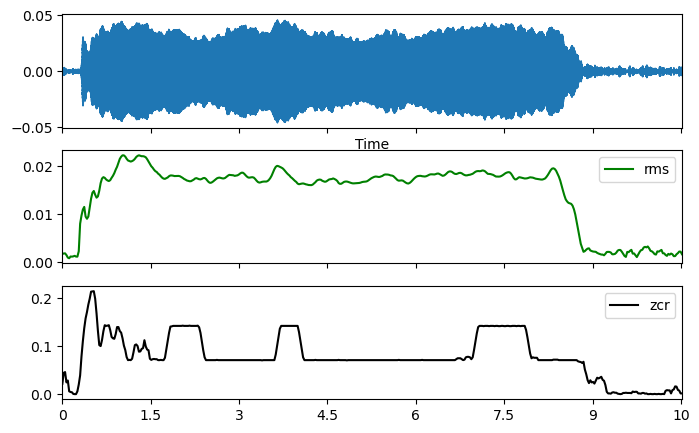

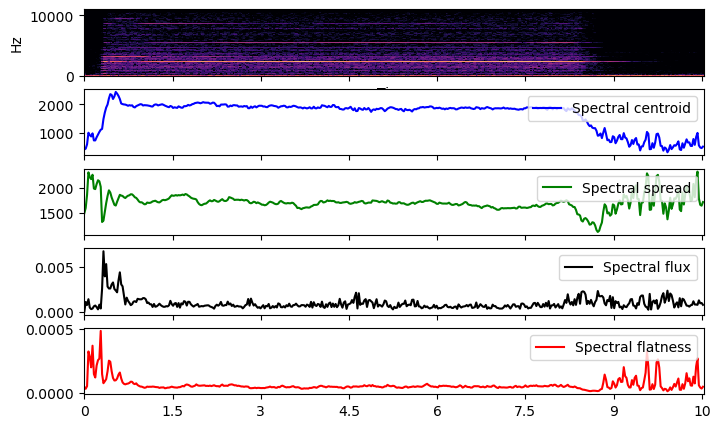

In [504]:
basic_plots(files[5])

In [505]:
spec_bw_average = []
for key in soundsDict:
    spec_bw_average.append(soundsDict[key][6])

spec_flux_average = []
for key in soundsDict:
    spec_flux_average.append(soundsDict[key][8])

spec_flat_average = []
for key in soundsDict:
    spec_flat_average.append(soundsDict[key][10])

zcr_average = []
for key in soundsDict:
    zcr_average.append(soundsDict[key][2])

spec_cent_average = []
for key in soundsDict:
    spec_cent_average.append(soundsDict[key][4])

tc = []
for key in soundsDict:
    tc.append(soundsDict[key][14])
lat = []
for key in soundsDict:
    lat.append(soundsDict[key][12])


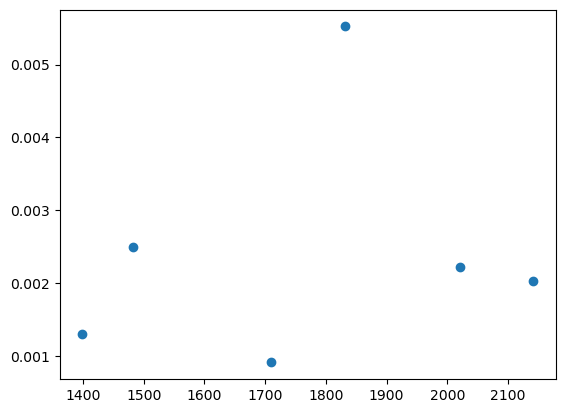

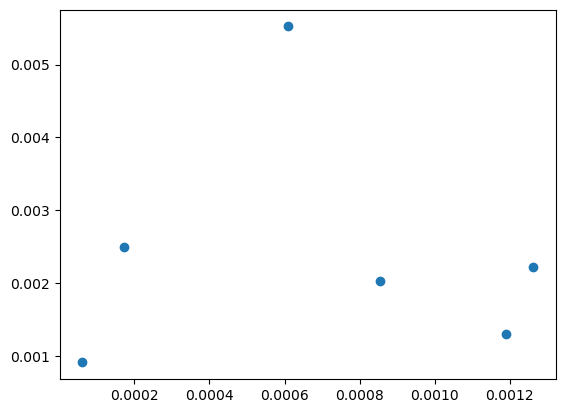

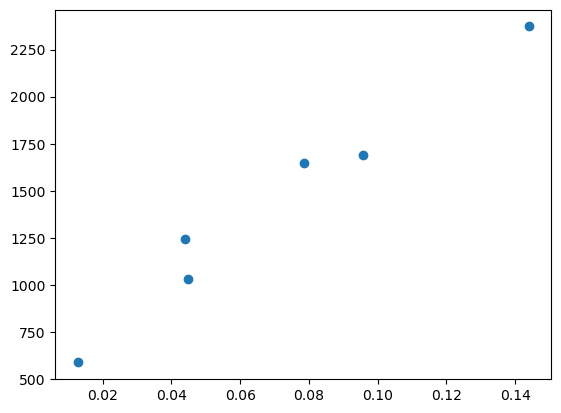

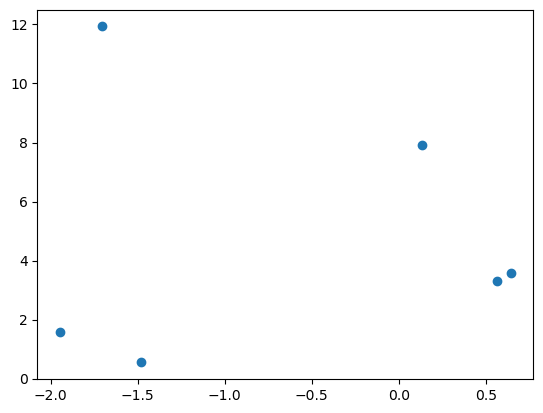

In [506]:
matplotlib.pyplot.scatter(spec_bw_average, spec_flux_average)
plt.show()
matplotlib.pyplot.scatter(spec_flat_average, spec_flux_average)
plt.show()
matplotlib.pyplot.scatter(zcr_average, spec_cent_average)
plt.show()
matplotlib.pyplot.scatter(lat, tc)

## Task 3

### Applications

Describe in a short paragraph (max 4/5 lines) a sound-based multimedia application that could make use of this set of sound descriptors. 

## Task 3 answer

We can use this descriptors in a multitude of different applications, but we would argue that the general public won't give a lot of importance to then, usually people want the simplest and least complicated option. With that in mind, we can see two different applications, the first would be a simple application for the general population where they could upload a sound and the app would give it a score according to what the supposed values are, on the other hand, a second application could be for the music savants, in which they could detect the quality and purity of the sound.  


## Task 4

### Classification - Percussive / Non_percussive

In [507]:
import os
 
# Get the list of all files and directories
path = "./data/sounds"
allFiles = os.listdir(path)

soundDescriptors = {}
'''soundDescriptors2 = {"fileName":[], "isPizz": [], "rms_average":[], "rms_std":[],
                     "zcr_average":[], "zcr_std": [], "lat":[], "tc": [], "ed": [],
                     "spec_cent_average": [], "spec_cent_std": [], "spec_bw_average": [],
                     "spec_bw_std": [], "spec_flux_average": [], "spec_flux_std": [],
                     "spec_flat_average": [], "spec_flat_std ": []}
for desc in soundDescriptors2.keys:
'''    


for fileName in allFiles:
    soundDescriptors[fileName] = []
    
    fileNameWav = os.path.join('.', 'data','sounds', fileName)
    fileVal, fileRate = librosa.load(fileNameWav)
    
    if "pizz" in fileName:
        soundDescriptors[fileName].append(True)
    else:
        soundDescriptors[fileName].append(False)
        
    rms = librosa.feature.rms(y=fileVal)
    rms_average = np.average(rms)
    rms_std = np.std(rms)
    soundDescriptors[fileName].append(rms_average)
    soundDescriptors[fileName].append(rms_std)
    
    zcr = librosa.feature.zero_crossing_rate(fileVal)
    zcr_average = np.average(zcr)
    zcr_std = np.std(zcr)
    soundDescriptors[fileName].append(zcr_average)
    soundDescriptors[fileName].append(zcr_std)
        
    lat = log_attack_time(fileVal, fileRate, start=0.01, end=0.99)
    soundDescriptors[fileName].append(lat)
    
    tc = temporal_centroid(fileVal, fileRate)
    soundDescriptors[fileName].append(tc)

    ed= effective_duration(fileVal, fileRate, threshold=0.05)
    soundDescriptors[fileName].append(ed)

    spec_cent = librosa.feature.spectral_centroid(y=fileVal, sr=fileRate)
    spec_cent_average = np.average(spec_cent)
    spec_cent_std = np.std(spec_cent)
    soundDescriptors[fileName].append(spec_cent_average)
    soundDescriptors[fileName].append(spec_cent_std)

    spec_bw = librosa.feature.spectral_bandwidth(y=fileVal, sr=fileRate)
    spec_bw_average = np.average(spec_bw)
    spec_bw_std = np.std(spec_bw)
    soundDescriptors[fileName].append(spec_bw_average)
    soundDescriptors[fileName].append(spec_bw_std)

    spec_flux = spectral_flux(fileVal)
    spec_flux_average = np.average(spec_flux)
    spec_flux_std = np.std(spec_flux)
    soundDescriptors[fileName].append(spec_flux_average)
    soundDescriptors[fileName].append(spec_flux_std)

    spec_flat = librosa.feature.spectral_flatness(y=fileVal)
    spec_flat_average = np.average(spec_flat)
    spec_flat_std = np.std(spec_flat)
    soundDescriptors[fileName].append(spec_flat_average)
    soundDescriptors[fileName].append(spec_flat_std)


In [508]:
import pandas as pd

soundDescriptorsDf = pd.DataFrame.from_dict(soundDescriptors)
soundDescriptorsDf = soundDescriptorsDf.iloc[1:]
s = soundDescriptorsDf.columns
soundDescriptorsDf = soundDescriptorsDf[s].astype(float)


['cbs_g_C2_12_pizz.wav', 'cbs_g_C2_12_pizz2.wav', 'vcl_a_C3_12_pizz.wav', 'vcl_a_C3_12_pizz2.wav', 'vln_e_C5_12_pizz.wav']
0


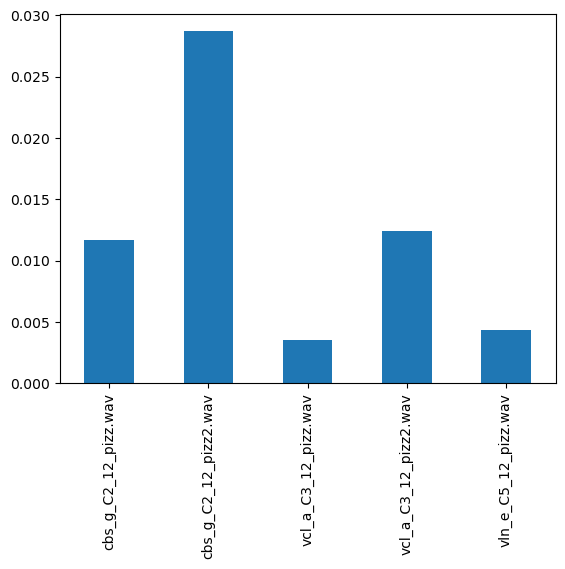

1


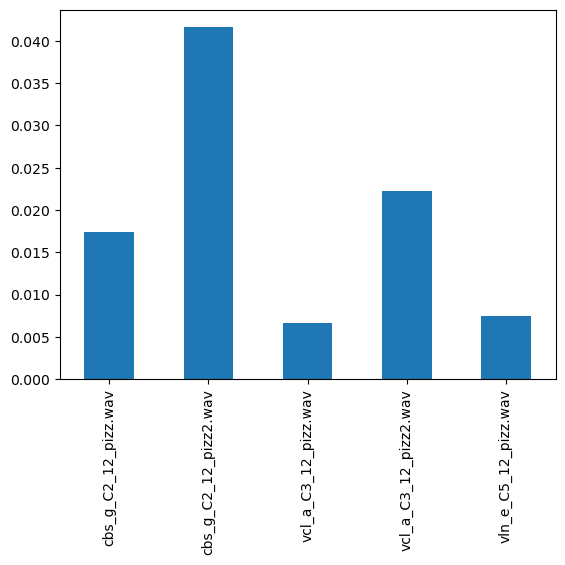

2


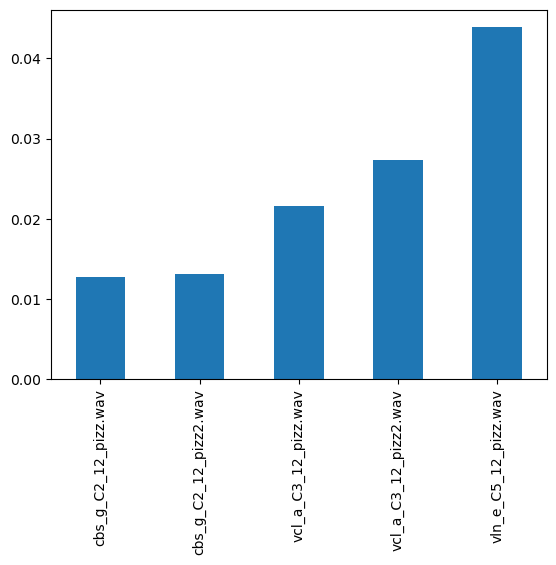

3


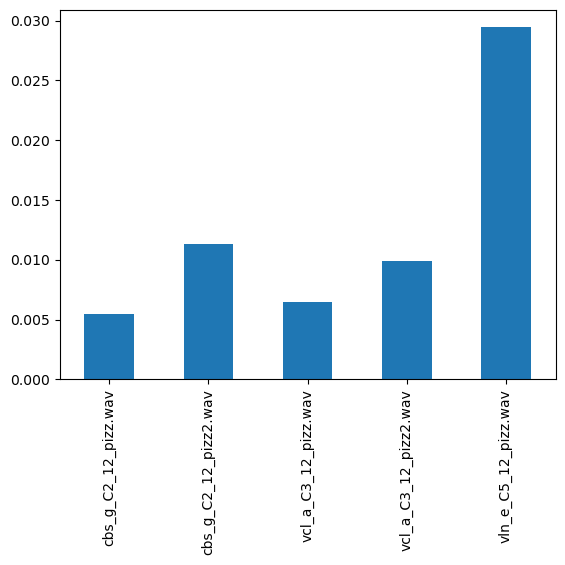

4


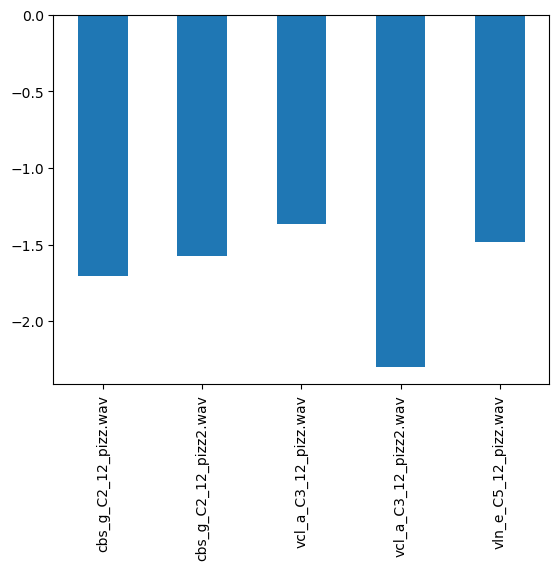

5


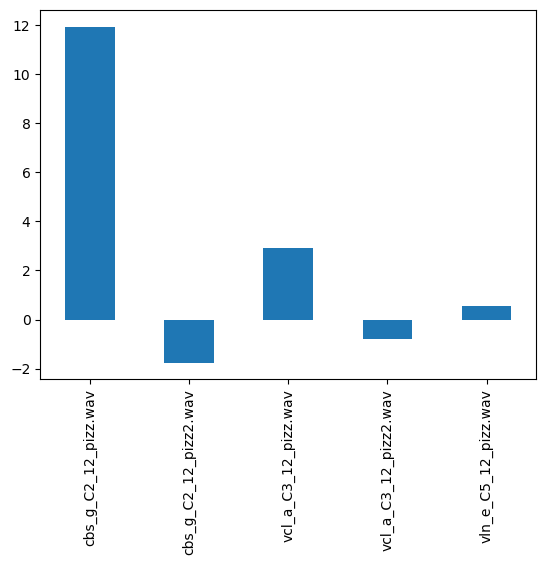

6


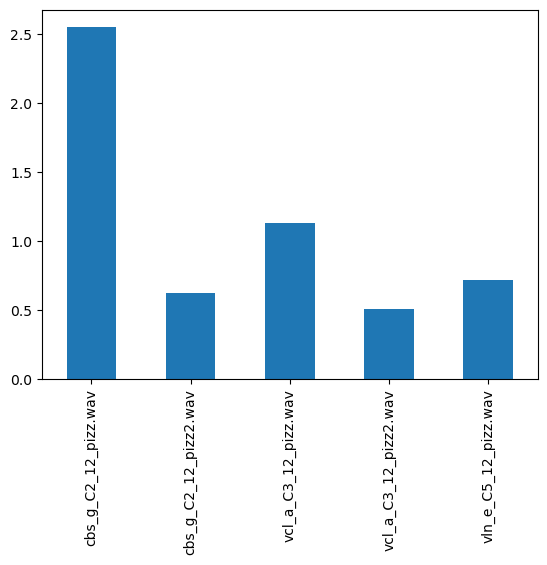

7


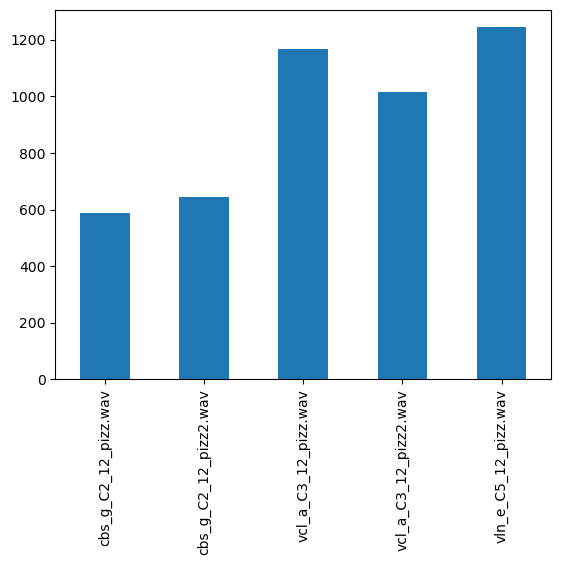

8


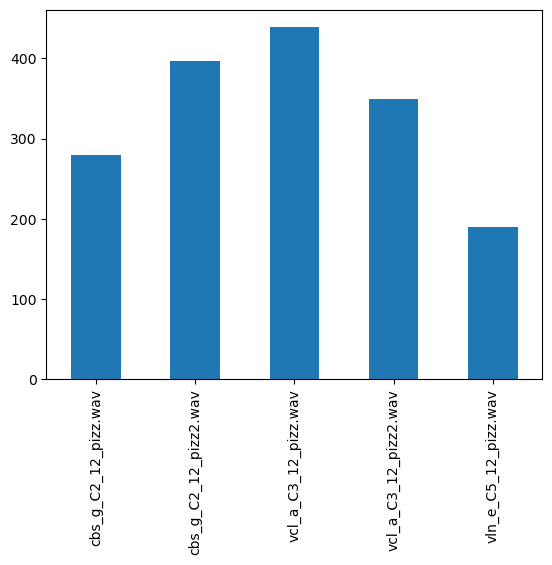

9


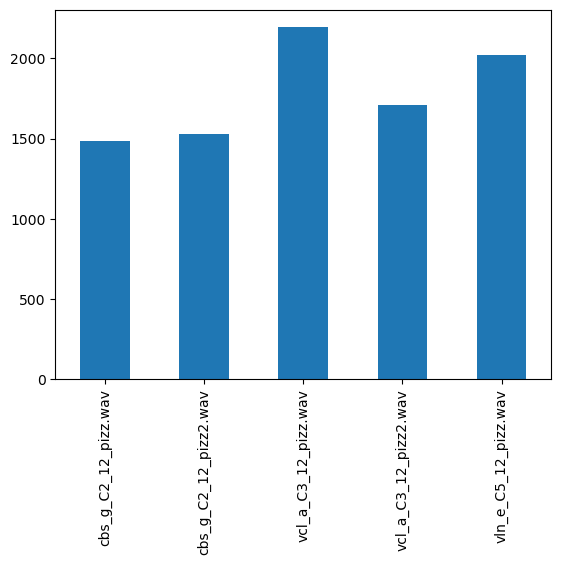

10


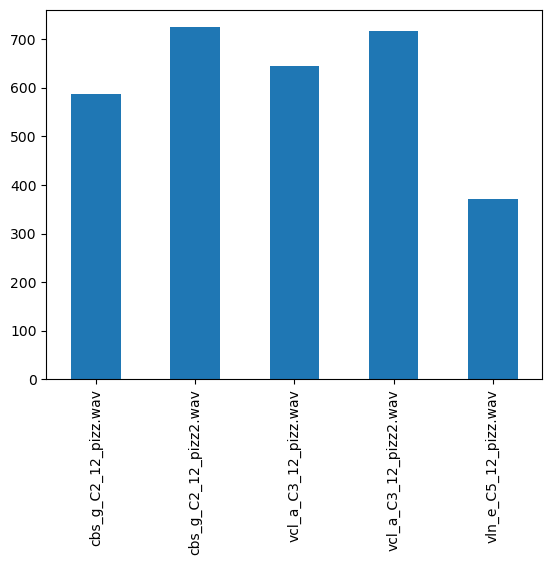

11


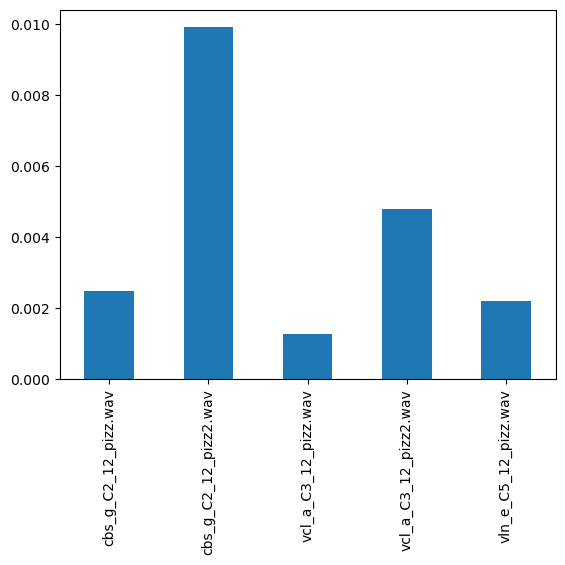

12


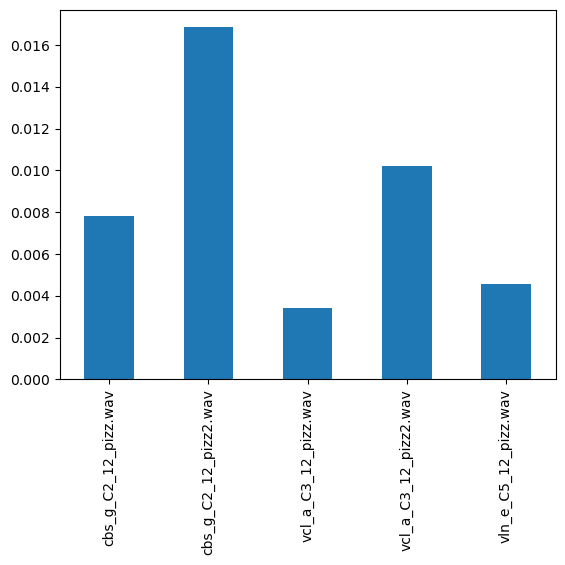

13


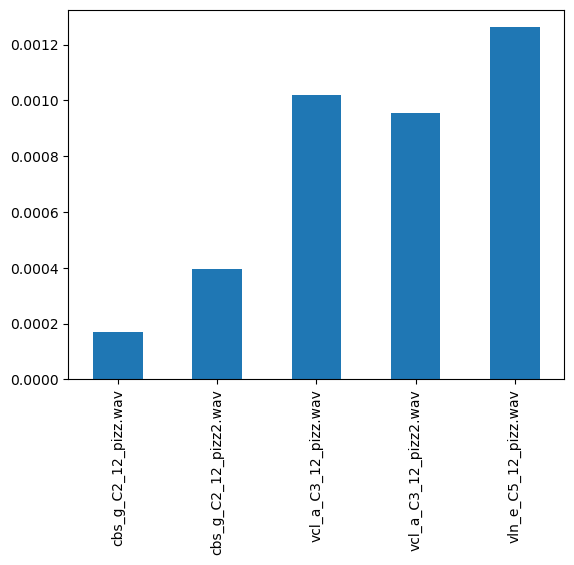

14


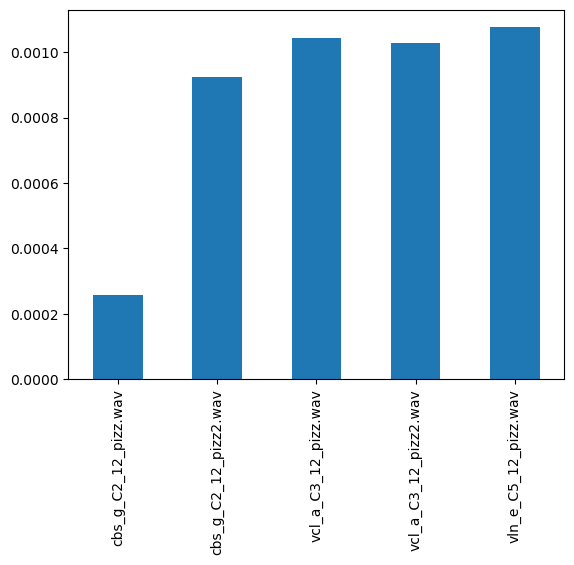

In [509]:
cols_to_plot = []
for x in soundDescriptorsDf.columns:
    if("pizz" in x):
        cols_to_plot.append(x)

print(cols_to_plot)

#seaborn.pairplot(soundDescriptorsDf.iloc[1:], vars=cols_to_plot)

for row1 in range(0, 15):
    print(row1)
    soundDescriptorsDf[cols_to_plot].iloc[row1].plot(kind='bar')
    plt.show()

['acc_qu_G2_12.wav', 'acc_qu_G3_12.wav', 'acc_qu_G4_12.wav', 'acc_qu_G5_1.wav', 'acc_se_G0_12.wav', 'acc_se_G1_12.wav', 'acc_se_G2_12.wav', 'acc_se_G3_12.wav', 'acc_se_G4_12.wav', 'cbs_d_G1_12.wav', 'cbs_d_G2_12.wav', 'cbs_g_G1_12.wav', 'cbs_g_G2_12.wav', 'cbs_g_G3_12.wav', 'clr_G2_12.wav', 'clr_G3_12.wav', 'clr_G4_12.wav', 'clr_G5_12.wav', 'flt_G3_12.wav', 'flt_G4_12.wav', 'flt_G5_12.wav', 'gui_a_G2_12.wav', 'gui_b_G3_12.wav', 'gui_d_G2_12.wav', 'gui_d_G3_12.wav', 'gui_el_G1_12.wav', 'gui_el_G2_12.wav', 'gui_e_G3_12.wav', 'gui_e_G4_12.wav', 'gui_g_G2_12.wav', 'gui_g_G3_12.wav', 'hrp_G0_12.wav', 'hrp_G1_12.wav', 'hrp_G2_12.wav', 'hrp_G3_12.wav', 'hrp_G4_12.wav', 'hrp_G5_12.wav', 'hrp_G6_12.wav', 'sax_G2_12.wav', 'sax_G3_12.wav', 'sax_G4_12.wav', 'trb_G1_12.wav', 'trb_G2_12.wav', 'trb_G3_12.wav', 'trp_G2_12.wav', 'trp_G3_12.wav', 'trp_G4_12.wav', 'tub_G0_12.wav', 'tub_G1_12.wav', 'vcl_a_G3_12.wav', 'vcl_a_G4_12.wav', 'vcl_c_G1_12.wav', 'vcl_c_G2_12.wav', 'vcl_d_G2_12.wav', 'vcl_d_G3_12.

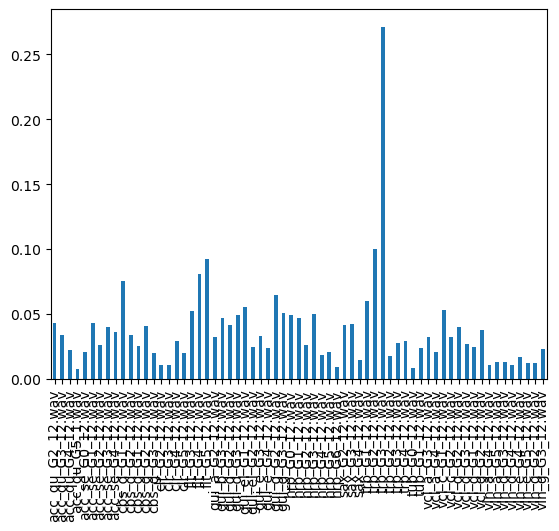

1


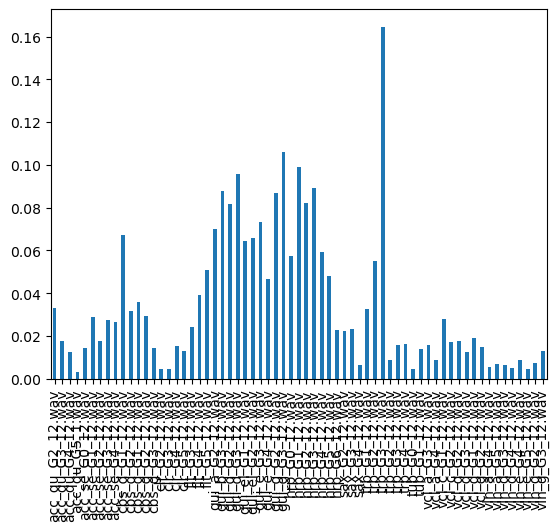

2


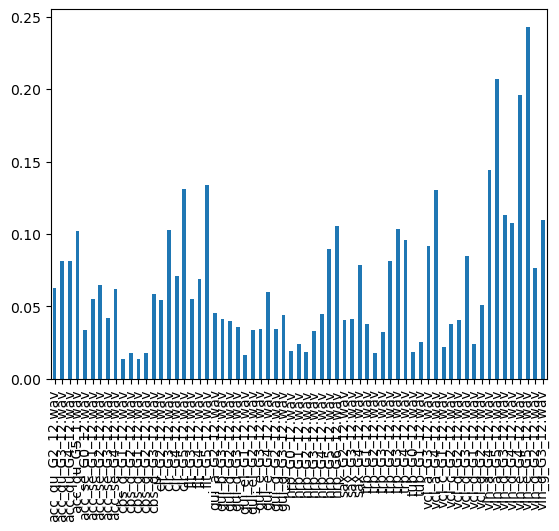

3


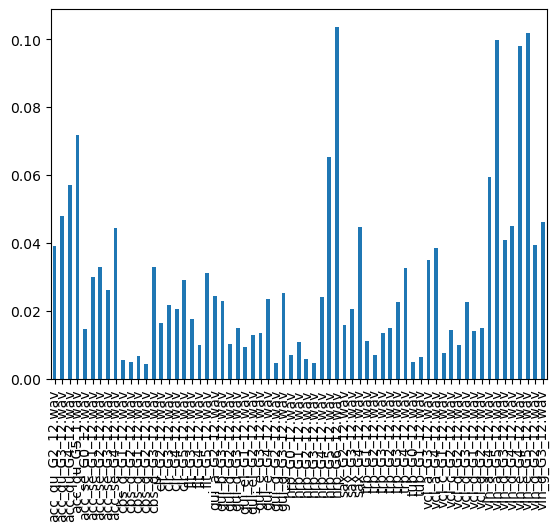

4


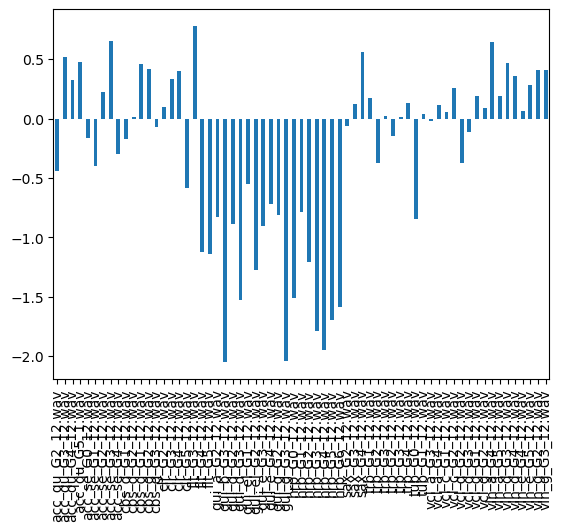

5


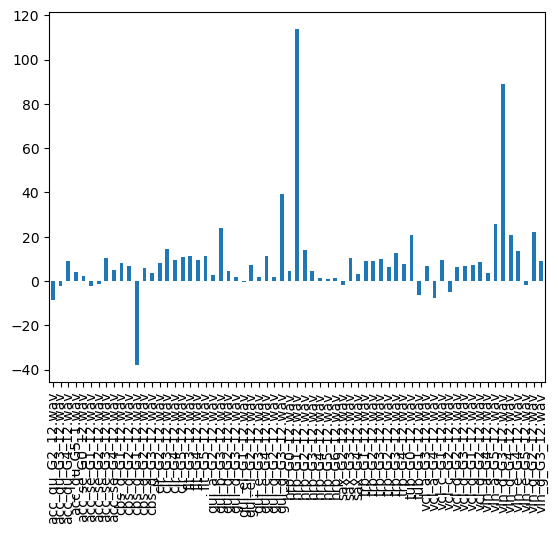

6


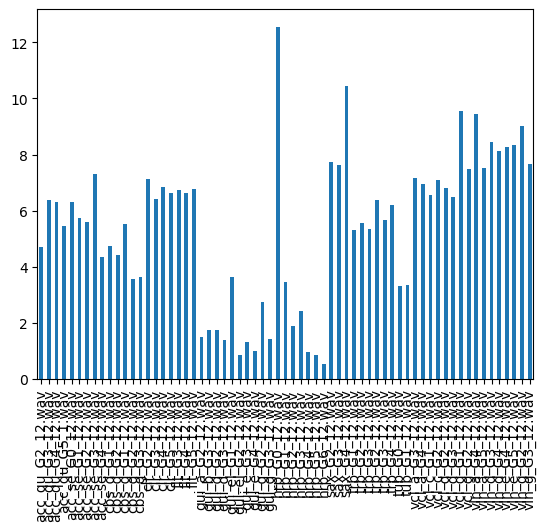

7


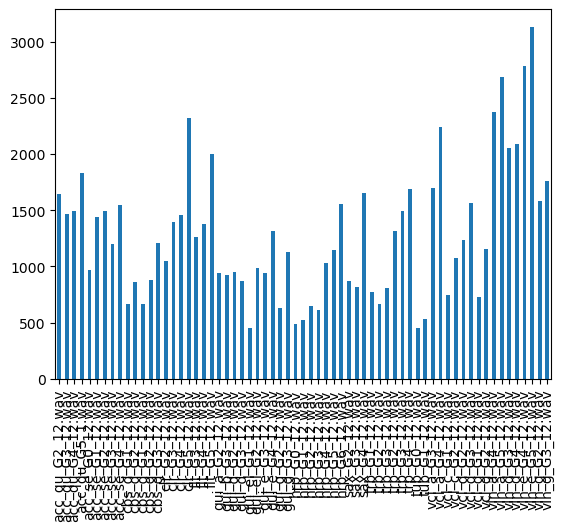

8


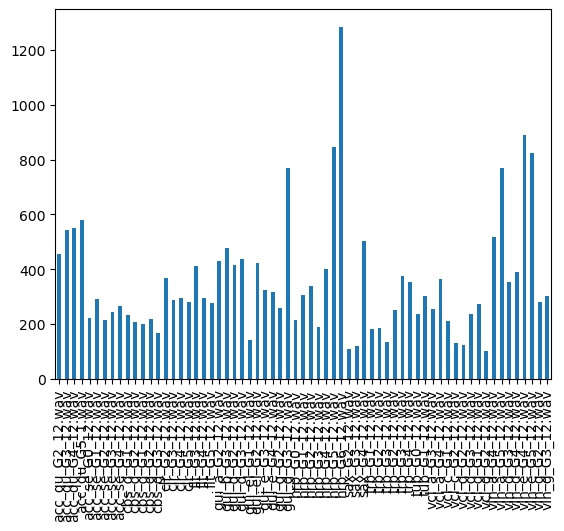

9


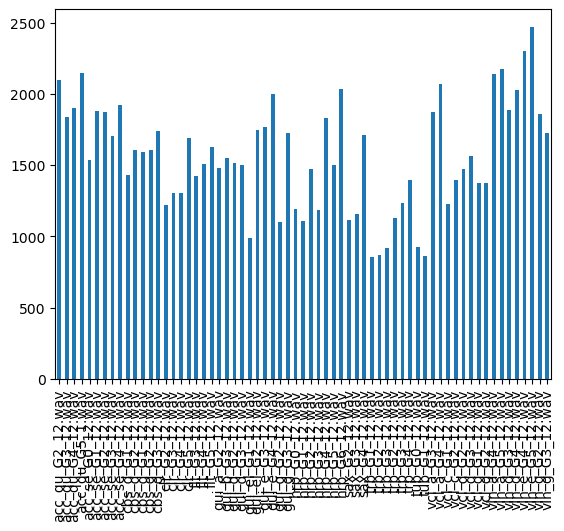

10


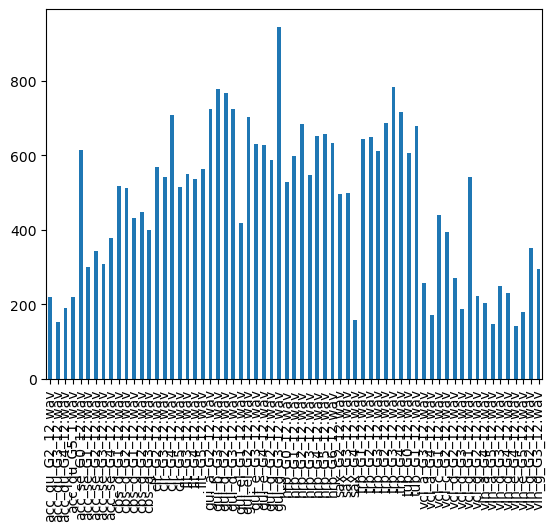

11


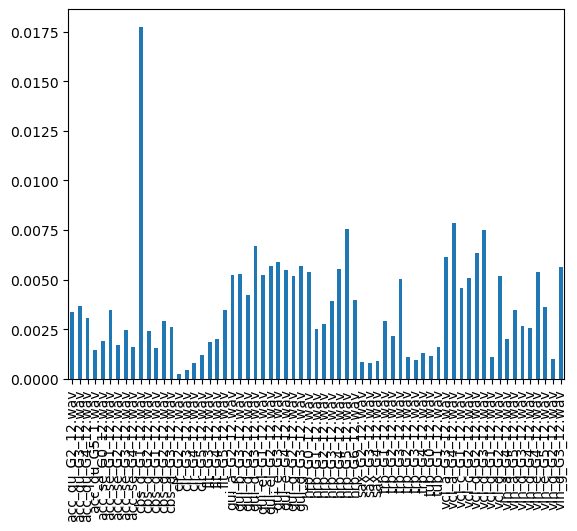

12


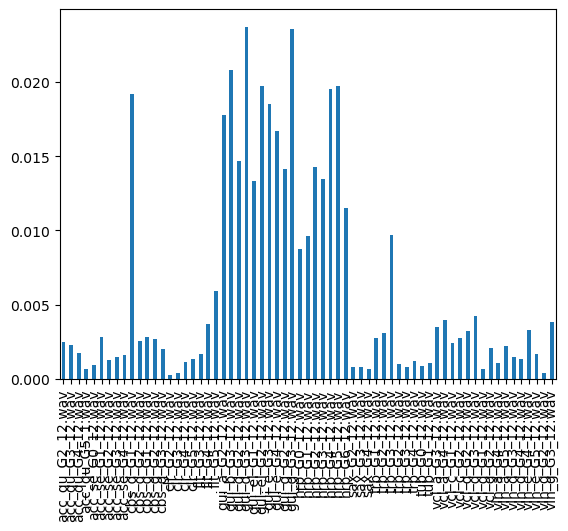

13


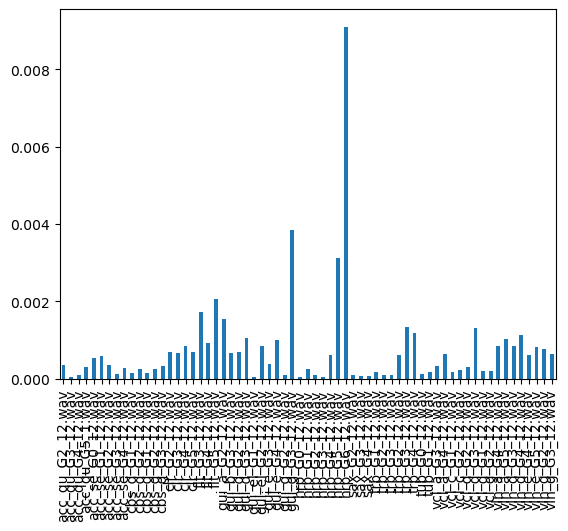

14


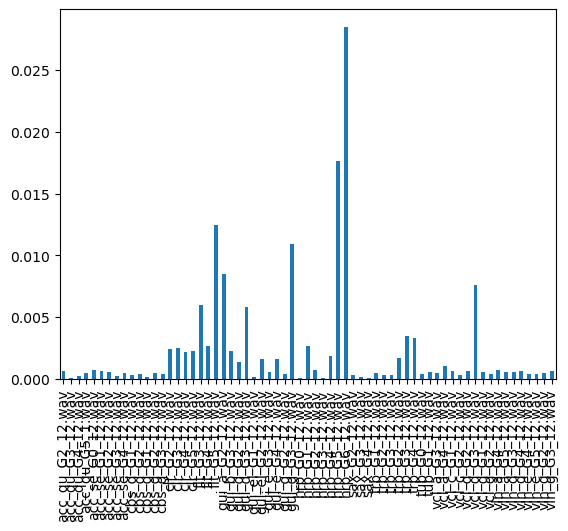

In [510]:
cols_to_plot = []
for x in soundDescriptorsDf.columns:
    if("pizz" not in x ):
        cols_to_plot.append(x)

print(cols_to_plot)

#seaborn.pairplot(soundDescriptorsDf.iloc[1:], vars=cols_to_plot)

for row1 in range(0, 15):
    print(row1)
    soundDescriptorsDf[cols_to_plot].iloc[row1].plot(kind='bar')
    plt.show()

In [511]:
def detect_percursive(filename):
    fileVal, fileRate = librosa.load(filename)
    lat = log_attack_time(fileVal, fileRate, start=0.01, end=0.99)
    ed= effective_duration(fileVal, fileRate, threshold=0.05)

    tc = temporal_centroid(fileVal, fileRate)

    spec_cent = librosa.feature.spectral_centroid(y=fileVal, sr=fileRate)
    spec_cent_std = np.std(spec_cent)

    spec_bw = librosa.feature.spectral_bandwidth(y=fileVal, sr=fileRate)
    spec_bw_average = np.average(spec_bw)

    spec_flux = spectral_flux(fileVal)
    spec_flux_std = np.std(spec_flux)

    if(lat < -1 and ed < 3 and spec_flux_std > 0.003 and tc < 13 and spec_cent_std < 500 and spec_bw_average > 1450):
        #print("Percursive")
        return 0
    else:
        #print("Non percursive")
        return 1

confusionMatrix = [[0, 0], [0, 0]]
for file in allFiles:
    file = os.path.join('.', 'data','sounds', file)
    isPizz = False
    if("pizz" in file):
        isPizz = True
    
    prediction = detect_percursive(file)

    if(prediction == 0 and isPizz):
        confusionMatrix[0][0] += 1
    elif(prediction == 0 and not isPizz):
        confusionMatrix[0][1] += 1
        print("pred pos really neg " + file)
    elif(prediction == 1 and isPizz):
        confusionMatrix[1][0] += 1
        print("pred neg really pos " + file)
    elif(prediction == 1 and not isPizz):
        confusionMatrix[1][1] += 1



pred pos really neg .\data\sounds\gui_d_G3_12.wav
pred pos really neg .\data\sounds\gui_el_G2_12.wav
pred pos really neg .\data\sounds\hrp_G4_12.wav


In [512]:
print(confusionMatrix)
TP = confusionMatrix[0][0]
FP = confusionMatrix[0][1]
FN = confusionMatrix[1][0]
TN = confusionMatrix[1][1]
AccuracyScore = (TP+TN)/ (TP+FN+TN+FP)
print("Accuracy " + str(AccuracyScore))
precision = TP/(TP+FP)
print("Precision " + str(precision))
recall = TP/(TP + FN)
print("Recall " + str(recall))
f1Score = 2 * (precision * recall) / (precision + recall)
print("F1 Score " + str(f1Score))

[[5, 3], [0, 62]]
Accuracy 0.9571428571428572
Precision 0.625
Recall 1.0
F1 Score 0.7692307692307693


Implement the type of excitation classifiers with simple rules (i.e. without any machine-learning algorithm): *percussive* vs *non-percussive*. These are found by the existence of `pizz` on the filename

This is a **binary** classification, as there are only two types of excitation: percussive or non-percussive.

Present the classification results in terms of: 
* accuracy
* precision 
* recall
* F1-Score
* Confusion Matrix

## Task 5

Try to redo task 4 for the second type of classification: 
* Instrument type: the name of the instrument (e.g. accordion, flute, cello, etc.). The first letters of the filename give the name of the instrument.

Is it possible to solve this problem using such sound descriptors and such rules?


Note: 

One of the difficulties you will find is that this is a **multi-class** type of classification.
However, algorithms that are designed for binary classification can be adapted for use for multi-class problems.

This involves using a strategy of fitting multiple binary classification models for each class vs. all other classes (called one-vs-rest) or one model for each pair of classes (called one-vs-one).

* One-vs-Rest: Fit one binary classification model for each class vs. all other classes.
* One-vs-One: Fit one binary classification model for each pair of classes.

Further Info: https://machinelearningmastery.com/types-of-classification-in-machine-learning/


In [513]:
acc_to_plot = []
cbs_to_plot = []
clr_to_plot = []
flt_to_plot = []
gui_to_plot = []
hrp_to_plot = []
sax_to_plot = []
trb_to_plot = []
trp_to_plot = []
tub_to_plot = []
vcl_to_plot = []
vln_to_plot = []
instru_dict = {}

for x in soundDescriptorsDf.columns:
    if("acc" in x):
        acc_to_plot.append(x)
    elif("cbs" in x):
        cbs_to_plot.append(x)
    elif("clr" in x):
        clr_to_plot.append(x)
    elif("flt" in x):
        flt_to_plot.append(x)
    elif("gui" in x):
        gui_to_plot.append(x)
    elif("hrp" in x):
        hrp_to_plot.append(x)
    elif("sax" in x):
        sax_to_plot.append(x)
    elif("trb" in x):
        trb_to_plot.append(x)
    elif("trp" in x):
        trp_to_plot.append(x)
    elif("tub" in x):
        tub_to_plot.append(x)
    elif("vcl" in x):
        vcl_to_plot.append(x)
    elif("vln" in x):
        vln_to_plot.append(x)

print(acc_to_plot)
instru_dict[0] = acc_to_plot
print(cbs_to_plot)
instru_dict[1] = cbs_to_plot
print(clr_to_plot)
instru_dict[2] = clr_to_plot
print(flt_to_plot)
instru_dict[3] = flt_to_plot
print(gui_to_plot)
instru_dict[4] = gui_to_plot
print(hrp_to_plot)
instru_dict[5] = hrp_to_plot
print(sax_to_plot)
instru_dict[6] = sax_to_plot
print(trb_to_plot)
instru_dict[7] = trb_to_plot
print(trp_to_plot)
instru_dict[8] = trp_to_plot
print(tub_to_plot)
instru_dict[9] = tub_to_plot
print(vcl_to_plot)
instru_dict[10] = vcl_to_plot
print(vln_to_plot)
instru_dict[11] = vln_to_plot


['acc_qu_G2_12.wav', 'acc_qu_G3_12.wav', 'acc_qu_G4_12.wav', 'acc_qu_G5_1.wav', 'acc_se_G0_12.wav', 'acc_se_G1_12.wav', 'acc_se_G2_12.wav', 'acc_se_G3_12.wav', 'acc_se_G4_12.wav']
['cbs_d_G1_12.wav', 'cbs_d_G2_12.wav', 'cbs_g_C2_12_pizz.wav', 'cbs_g_C2_12_pizz2.wav', 'cbs_g_G1_12.wav', 'cbs_g_G2_12.wav', 'cbs_g_G3_12.wav']
['clr_G2_12.wav', 'clr_G3_12.wav', 'clr_G4_12.wav', 'clr_G5_12.wav']
['flt_G3_12.wav', 'flt_G4_12.wav', 'flt_G5_12.wav']
['gui_a_G2_12.wav', 'gui_b_G3_12.wav', 'gui_d_G2_12.wav', 'gui_d_G3_12.wav', 'gui_el_G1_12.wav', 'gui_el_G2_12.wav', 'gui_e_G3_12.wav', 'gui_e_G4_12.wav', 'gui_g_G2_12.wav', 'gui_g_G3_12.wav']
['hrp_G0_12.wav', 'hrp_G1_12.wav', 'hrp_G2_12.wav', 'hrp_G3_12.wav', 'hrp_G4_12.wav', 'hrp_G5_12.wav', 'hrp_G6_12.wav']
['sax_G2_12.wav', 'sax_G3_12.wav', 'sax_G4_12.wav']
['trb_G1_12.wav', 'trb_G2_12.wav', 'trb_G3_12.wav']
['trp_G2_12.wav', 'trp_G3_12.wav', 'trp_G4_12.wav']
['tub_G0_12.wav', 'tub_G1_12.wav']
['vcl_a_C3_12_pizz.wav', 'vcl_a_C3_12_pizz2.wav', 

0


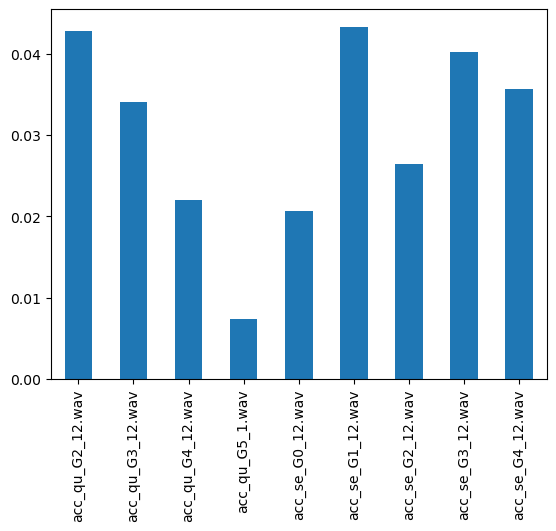

1


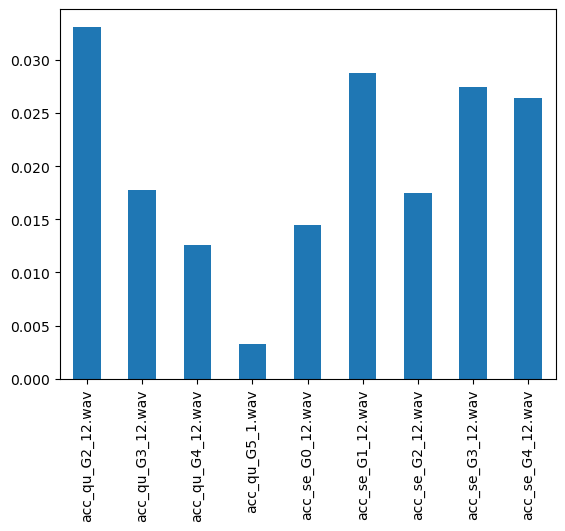

2


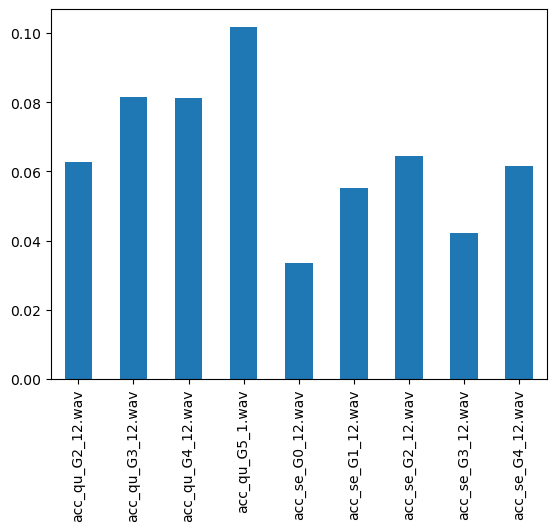

3


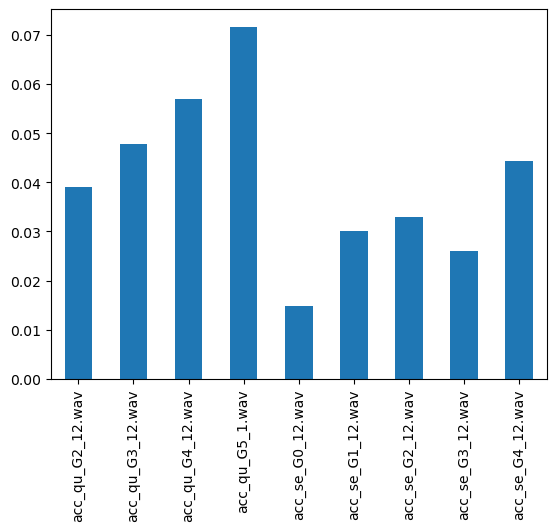

4


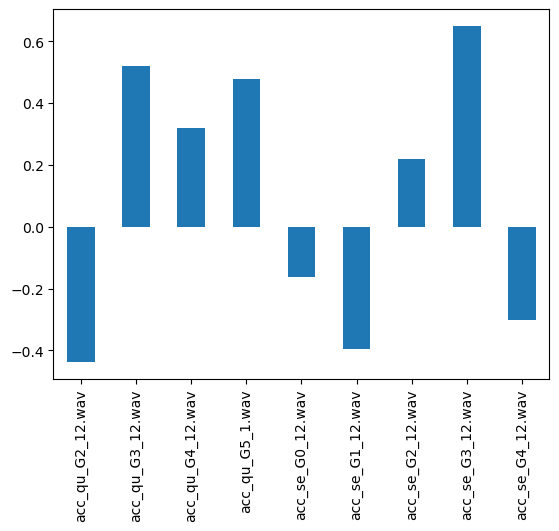

5


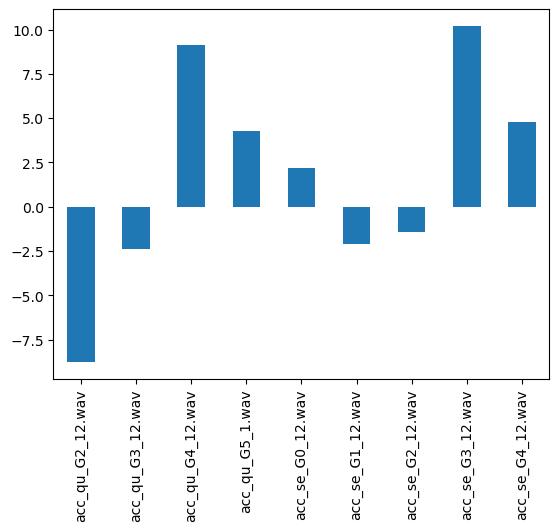

6


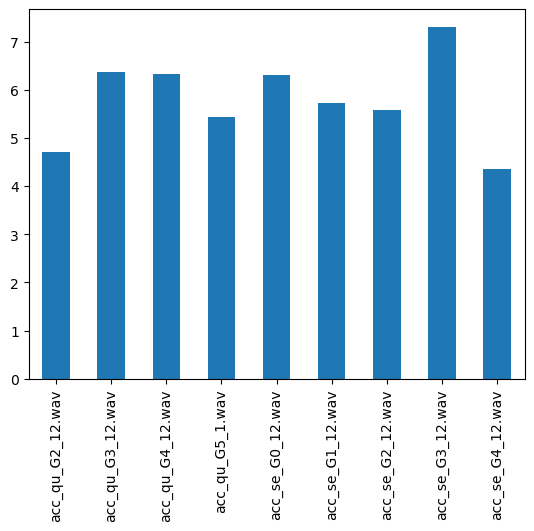

7


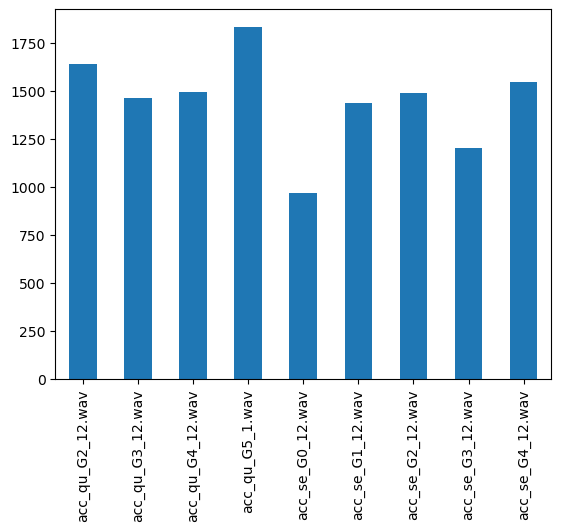

8


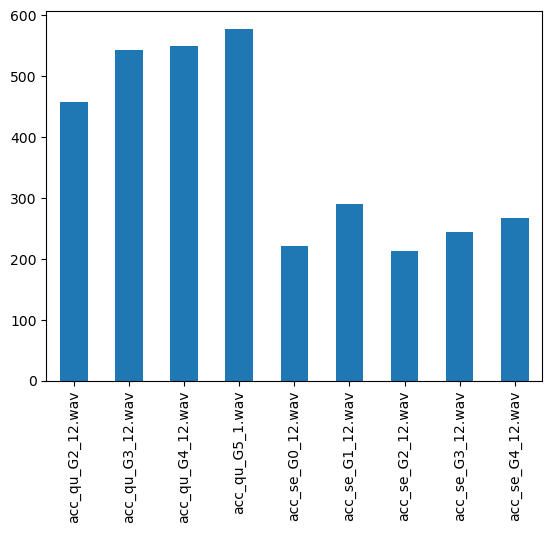

9


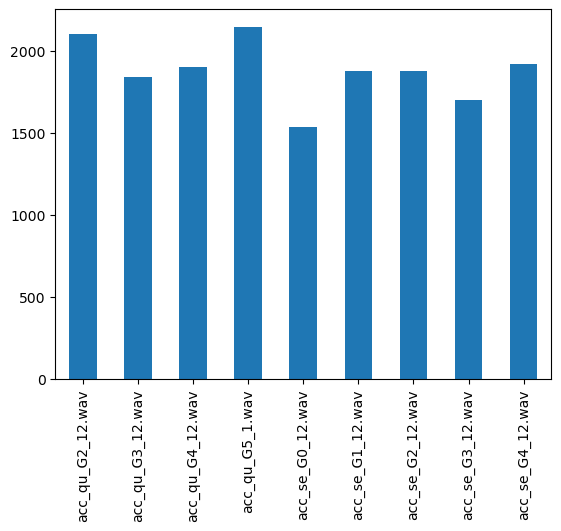

10


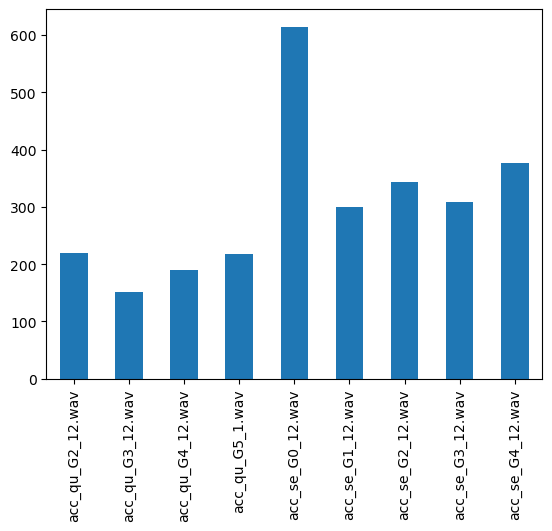

11


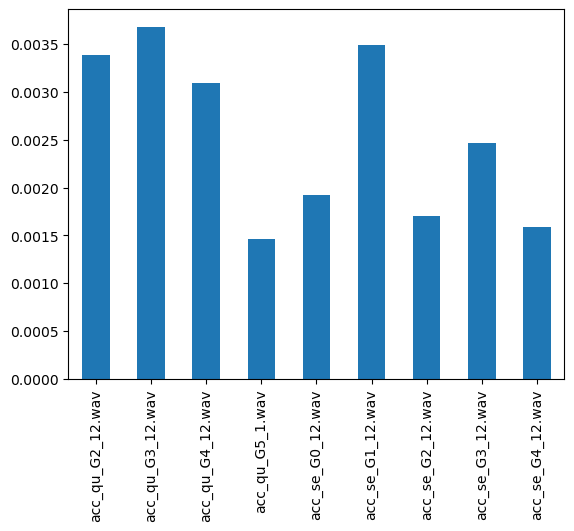

12


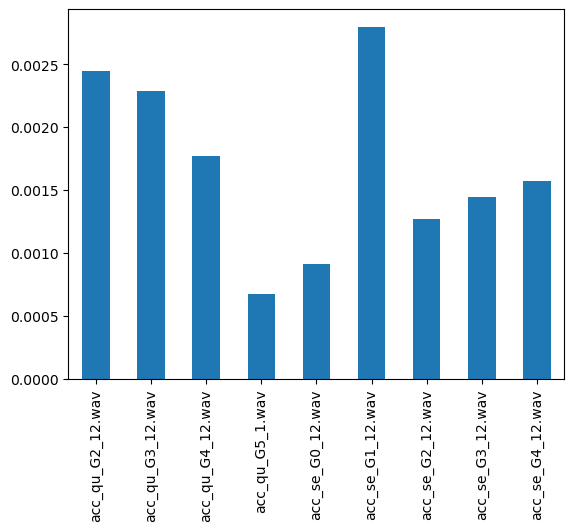

13


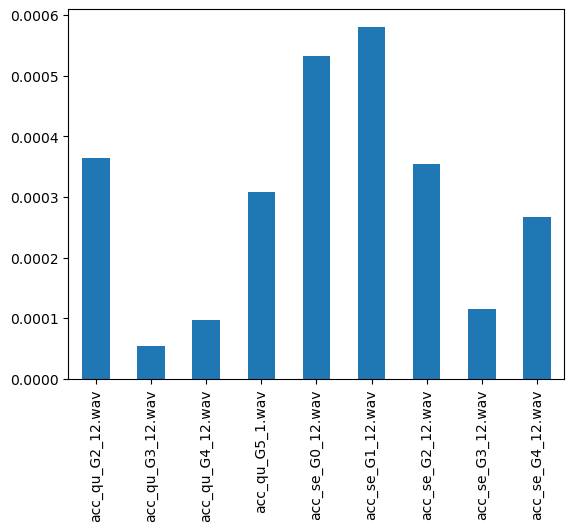

14


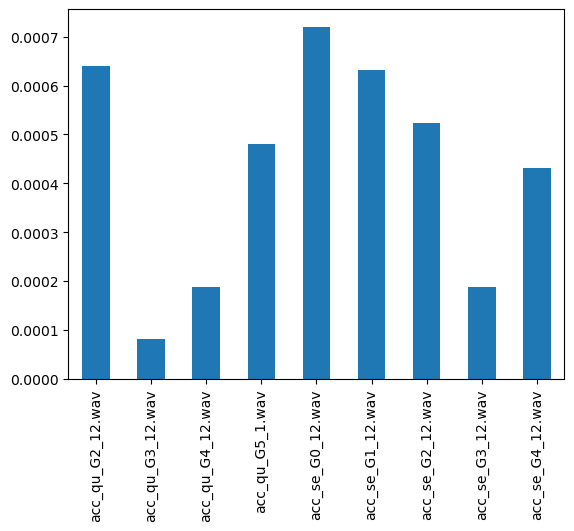

0


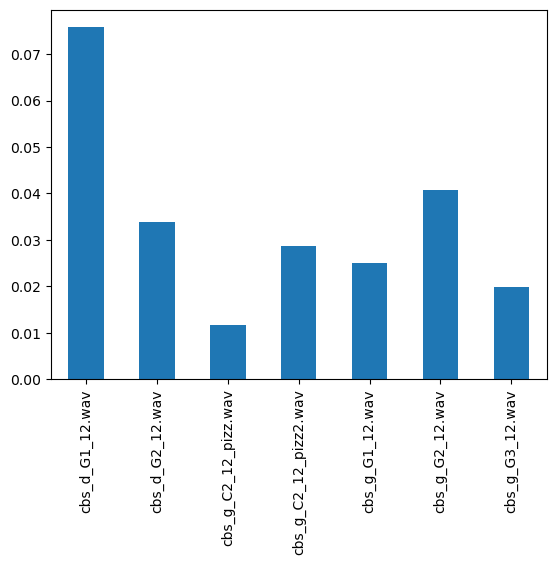

1


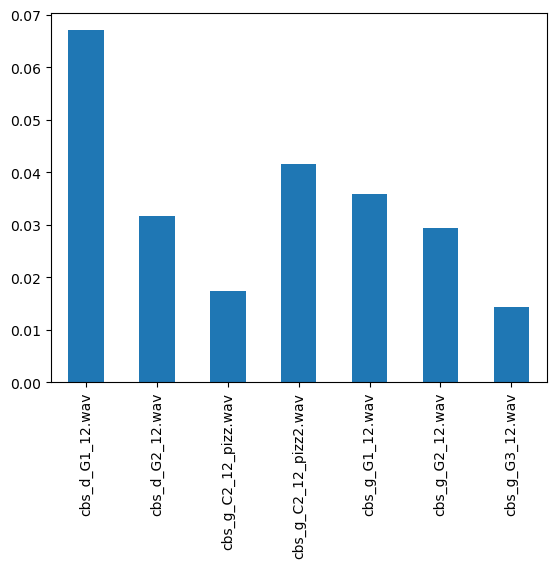

2


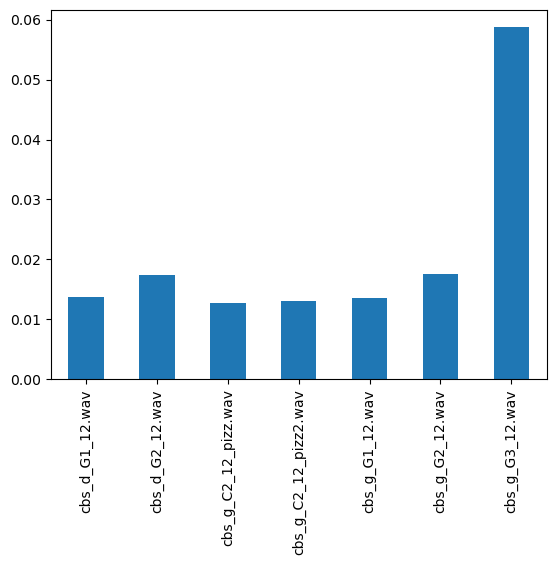

3


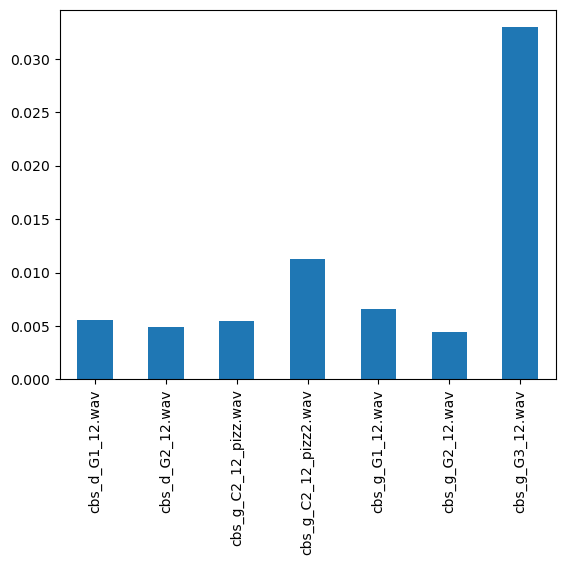

4


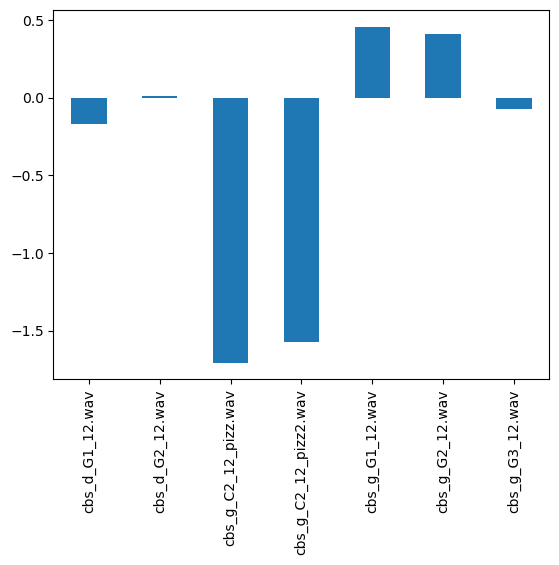

5


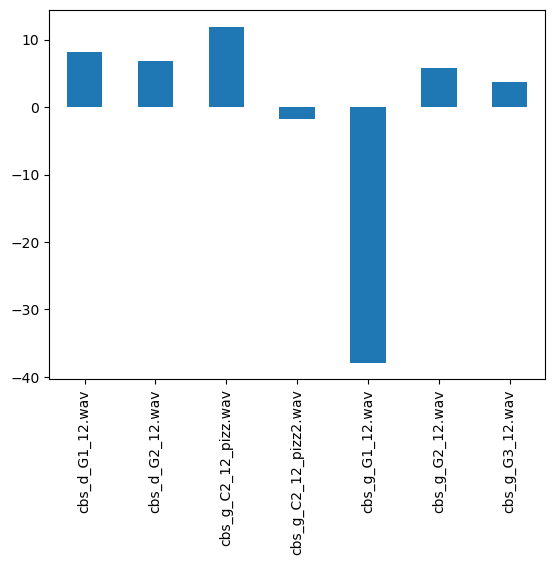

6


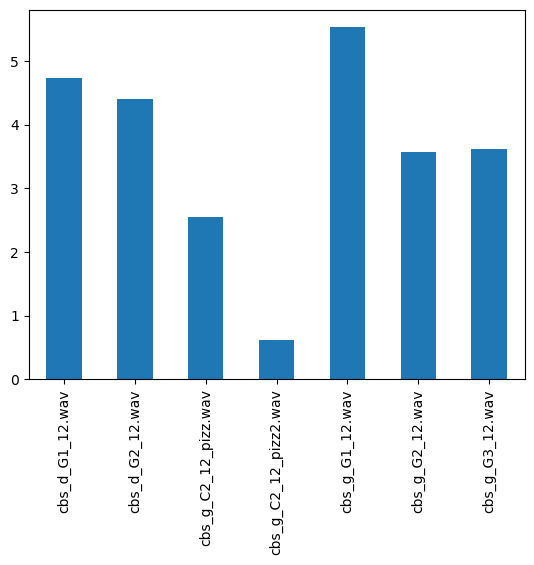

7


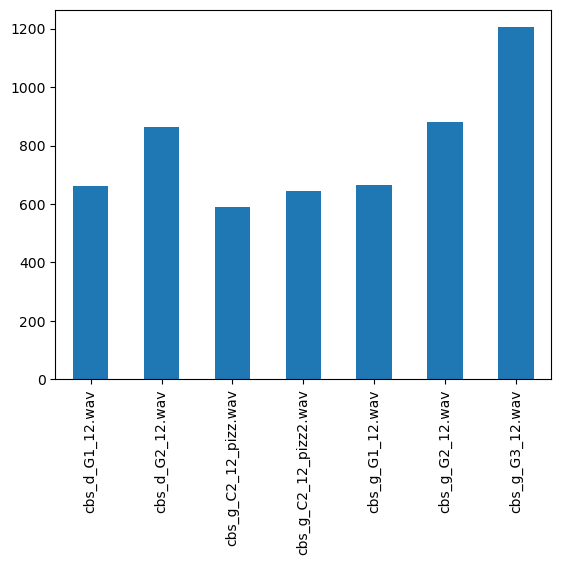

8


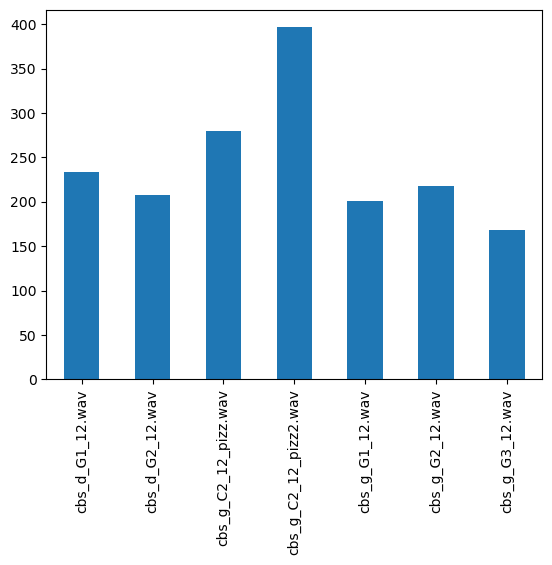

9


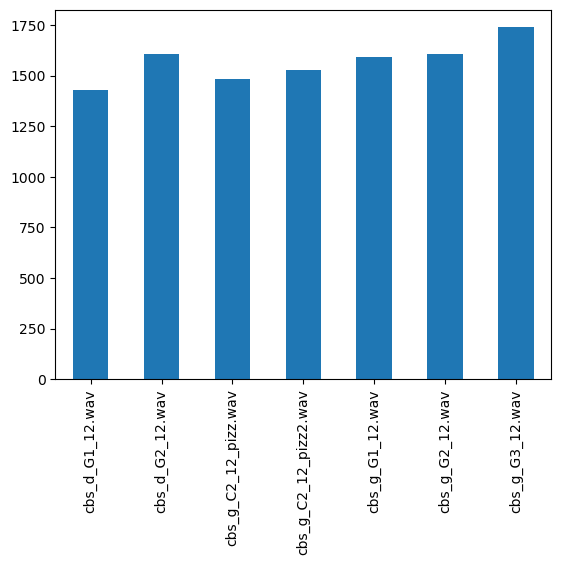

10


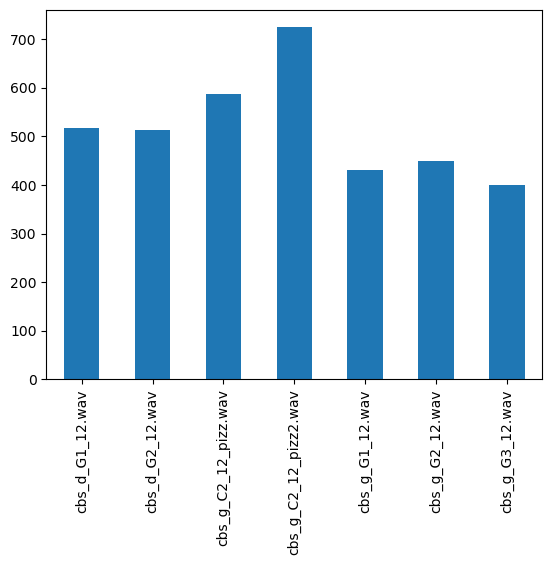

11


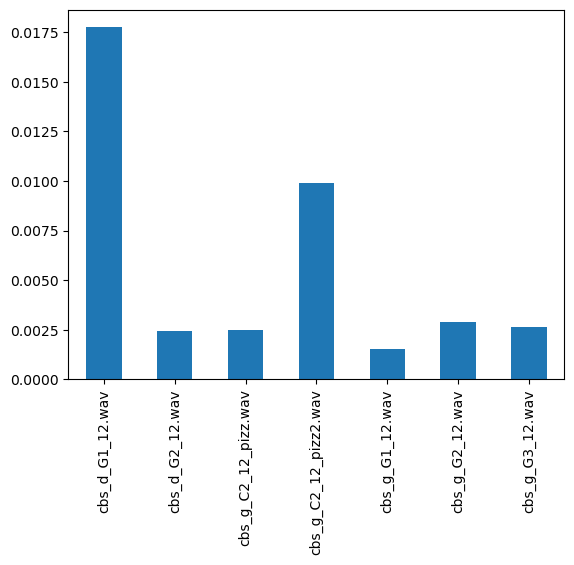

12


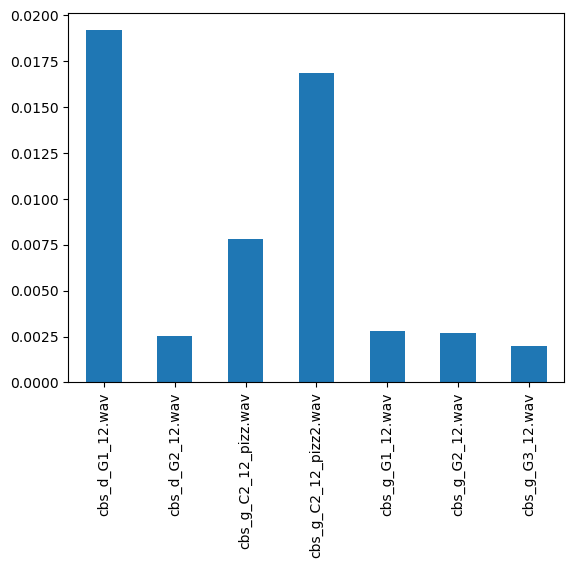

13


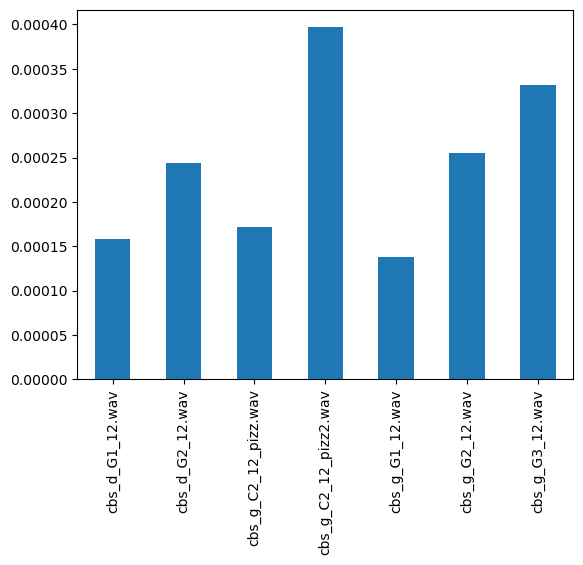

14


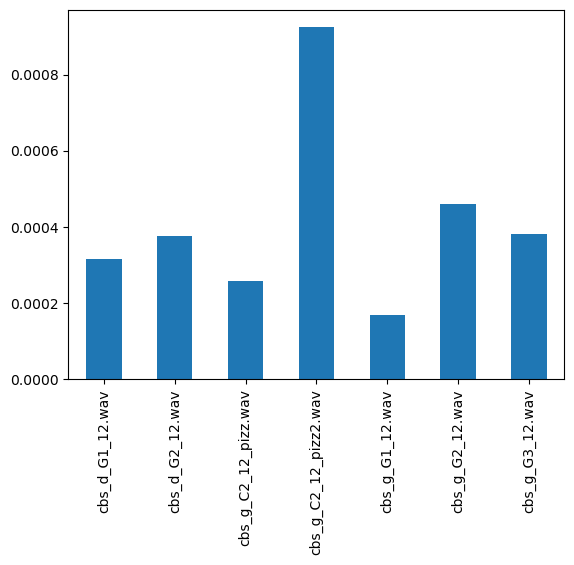

0


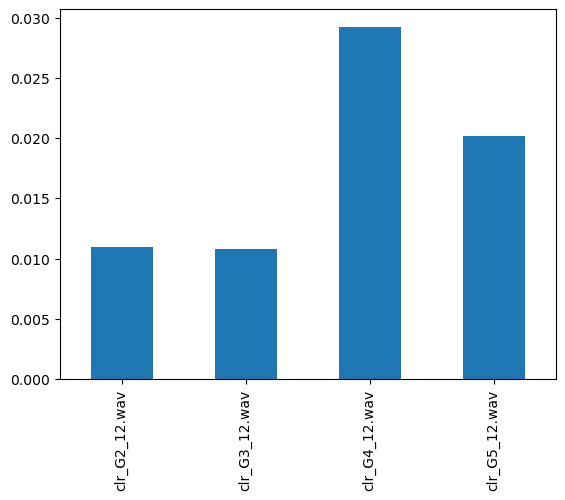

1


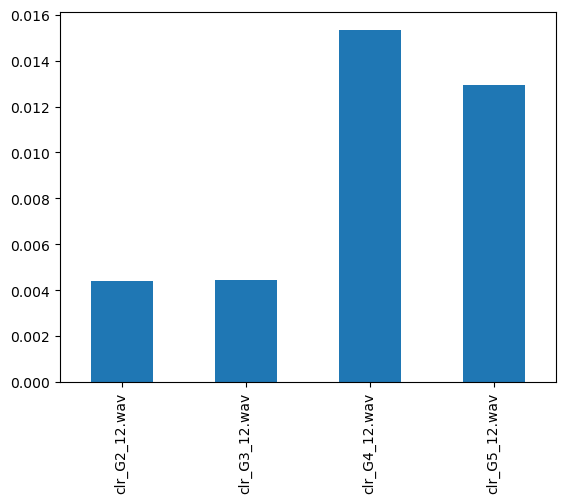

2


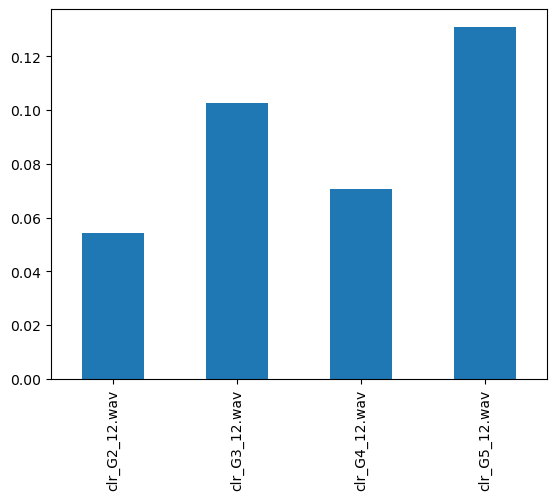

3


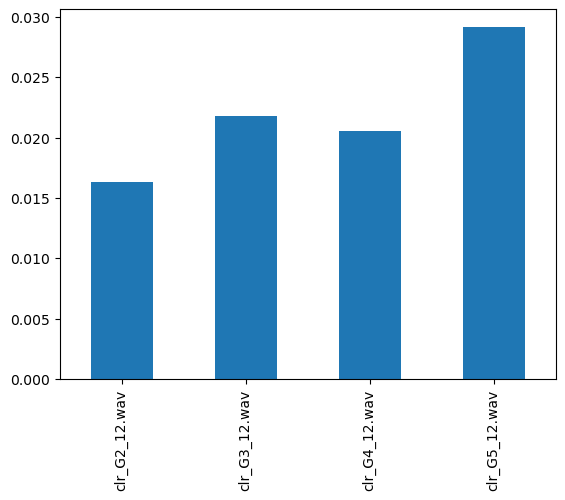

4


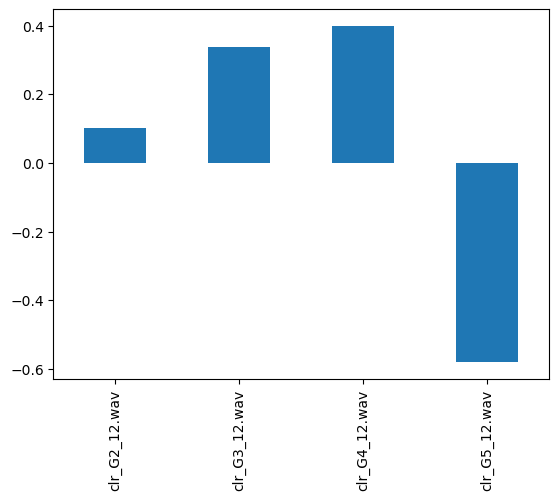

5


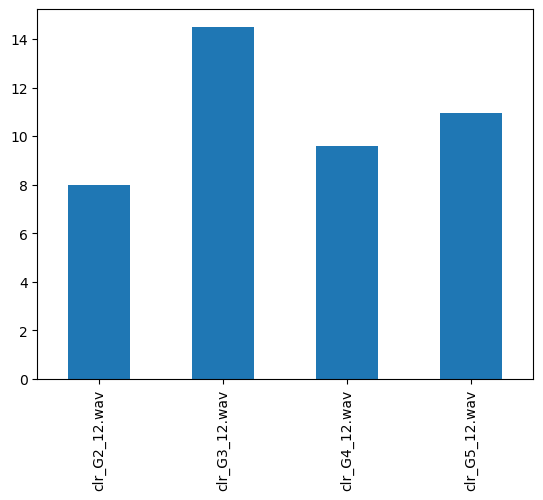

6


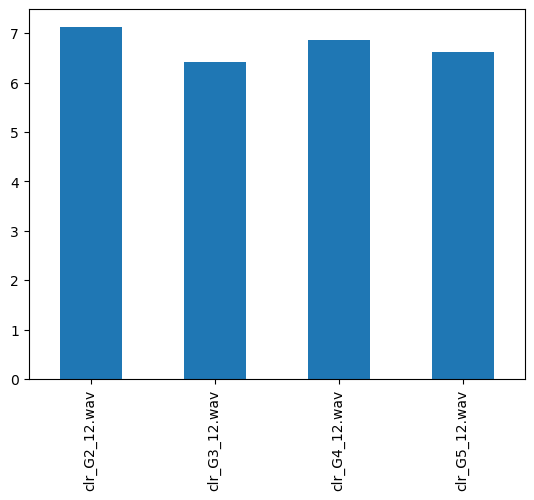

7


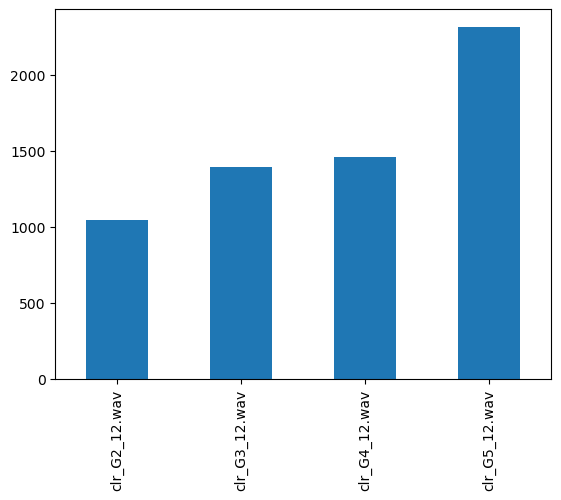

8


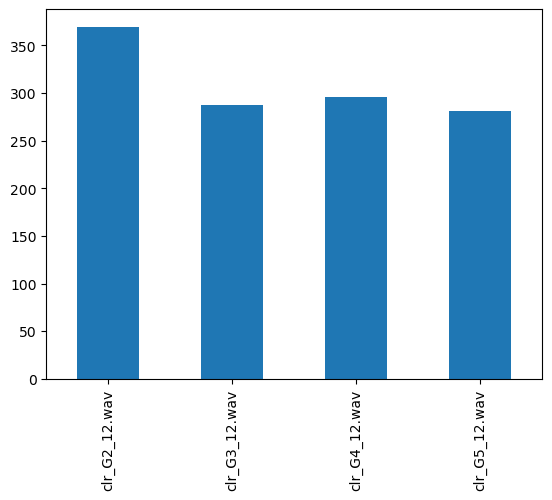

9


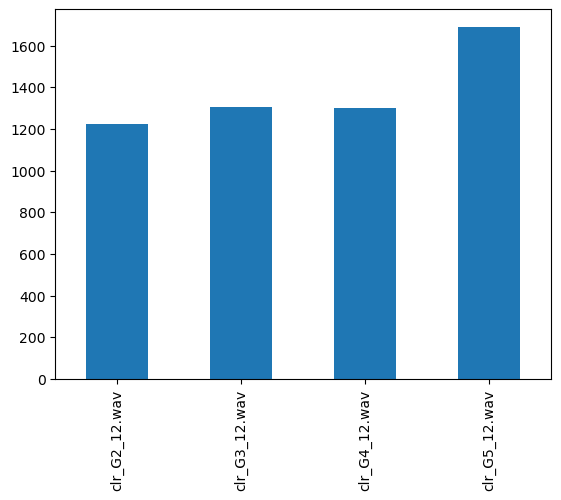

10


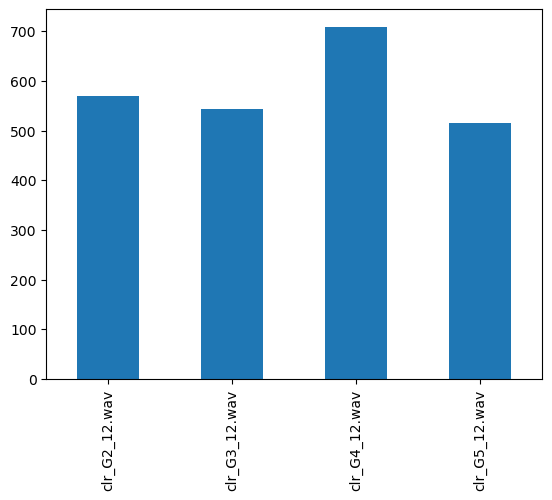

11


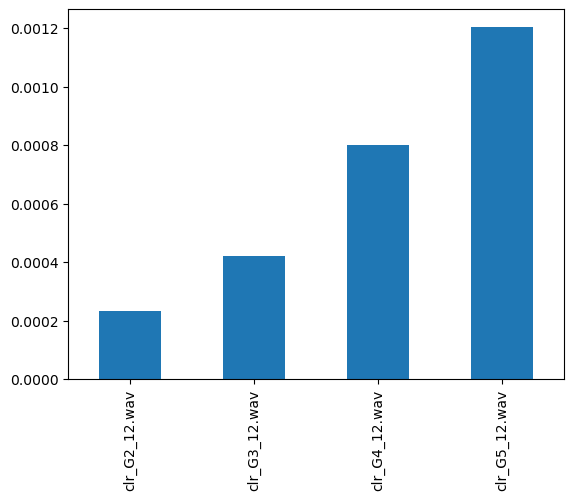

12


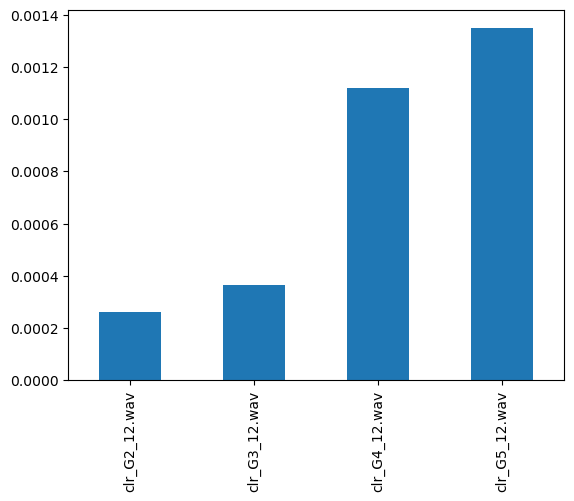

13


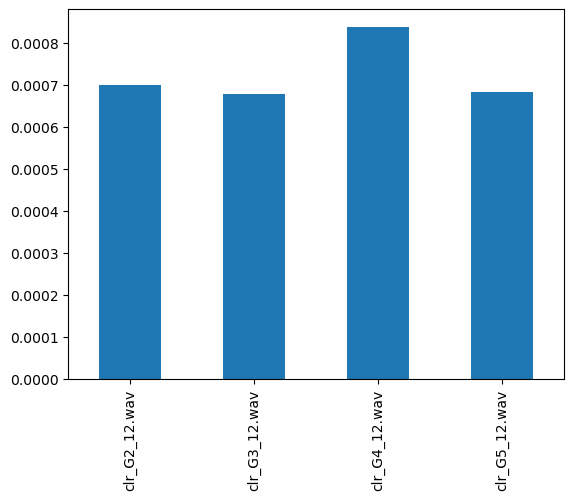

14


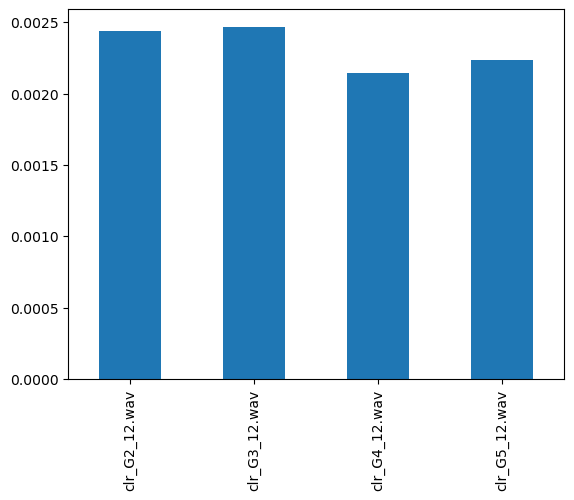

0


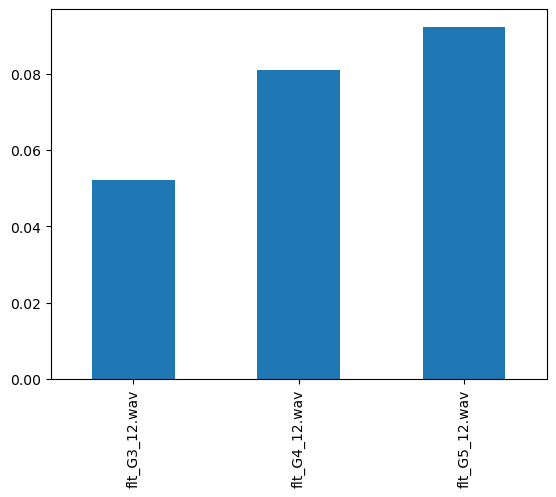

1


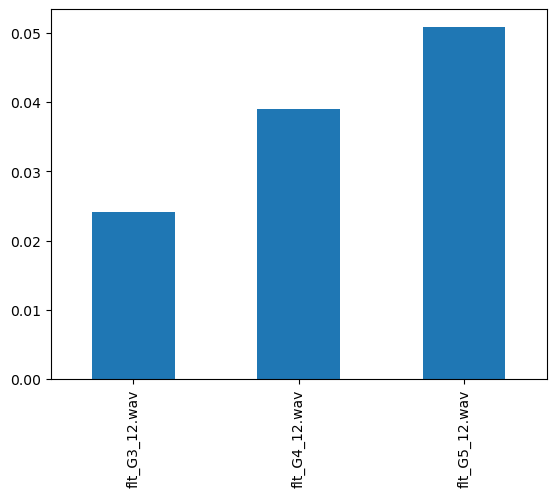

2


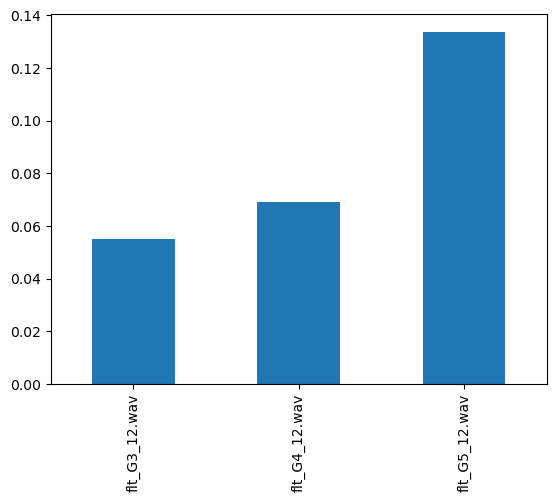

3


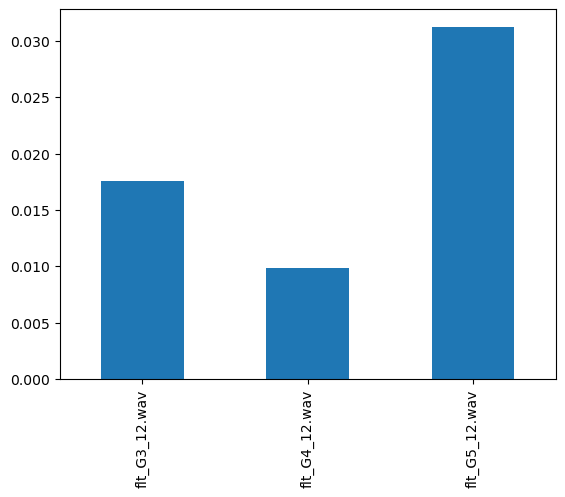

4


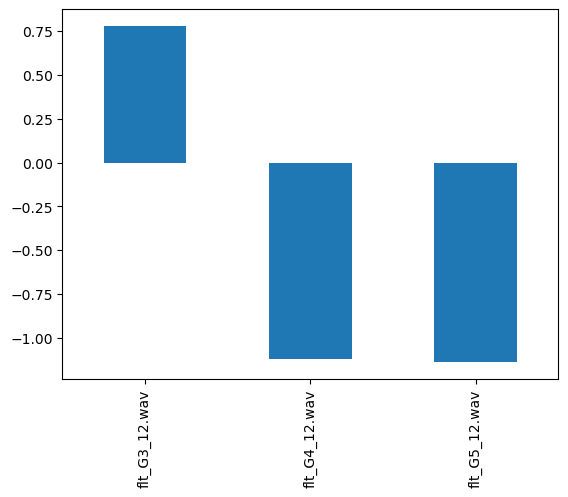

5


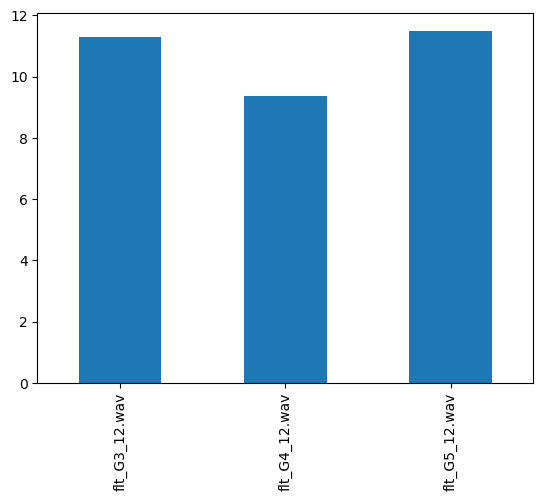

6


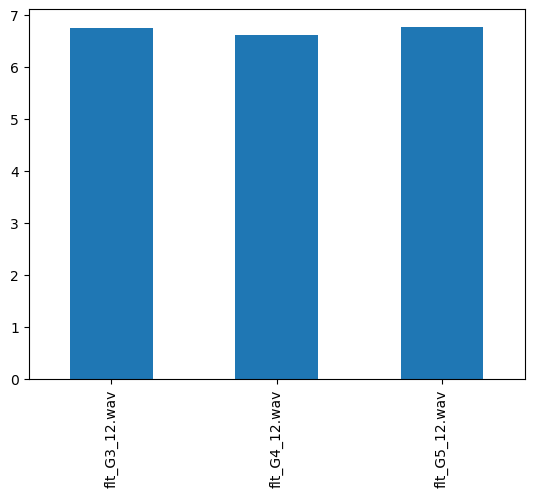

7


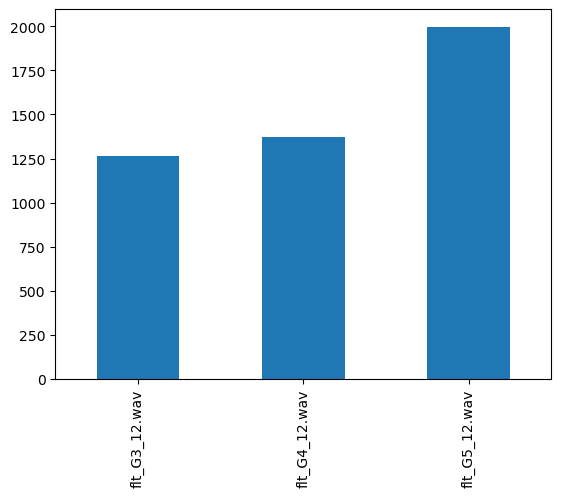

8


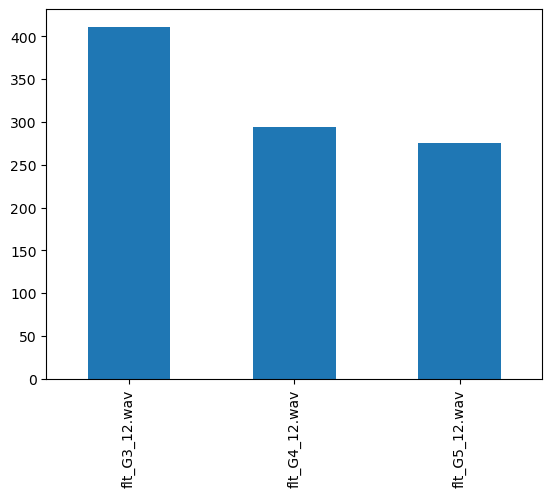

9


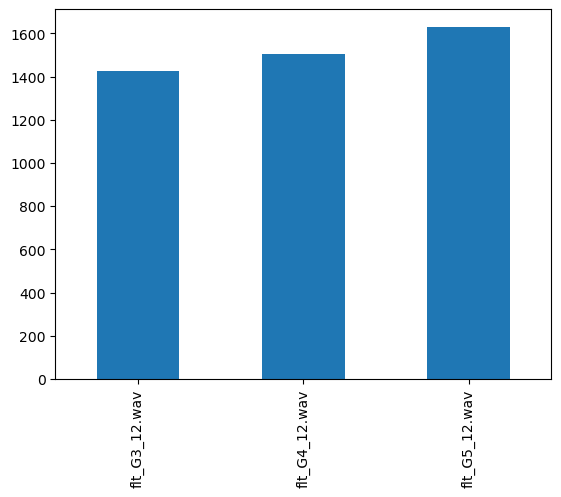

10


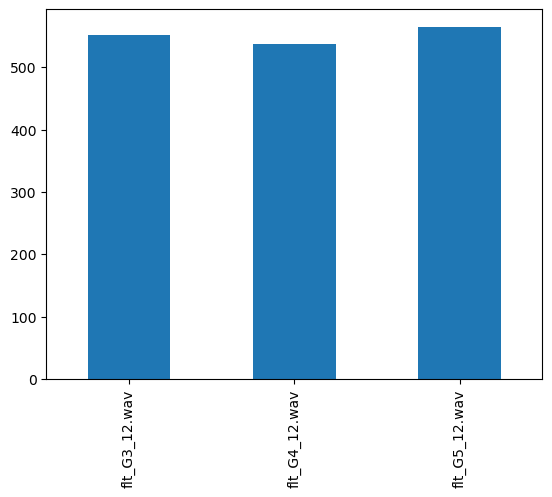

11


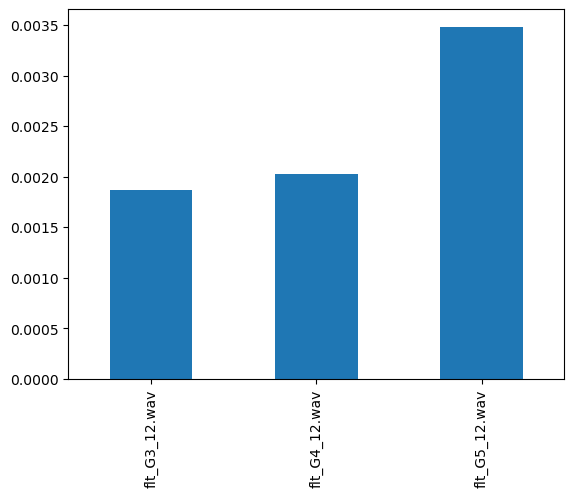

12


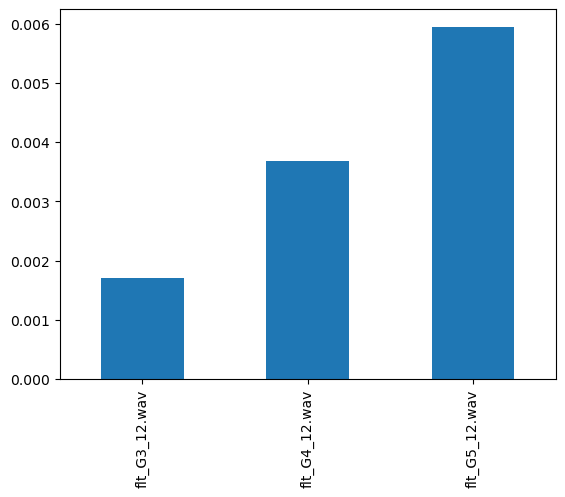

13


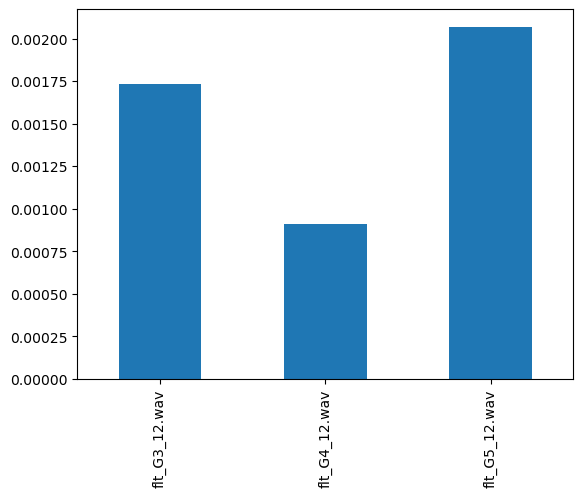

14


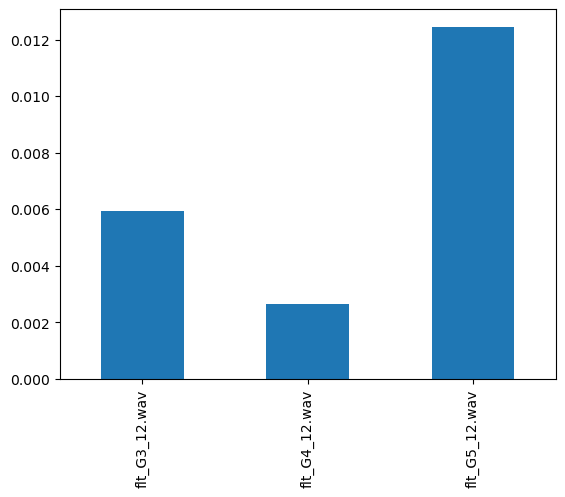

0


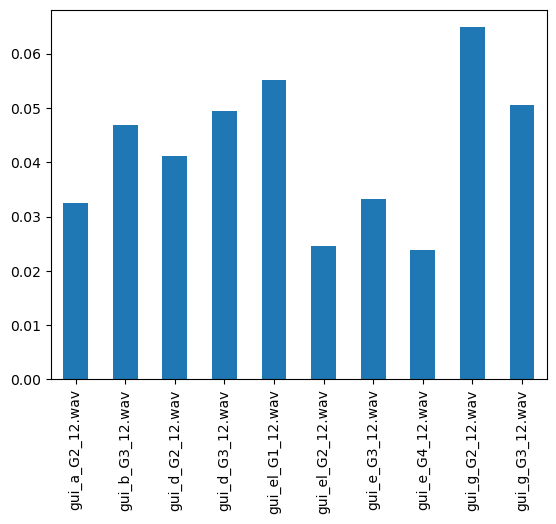

1


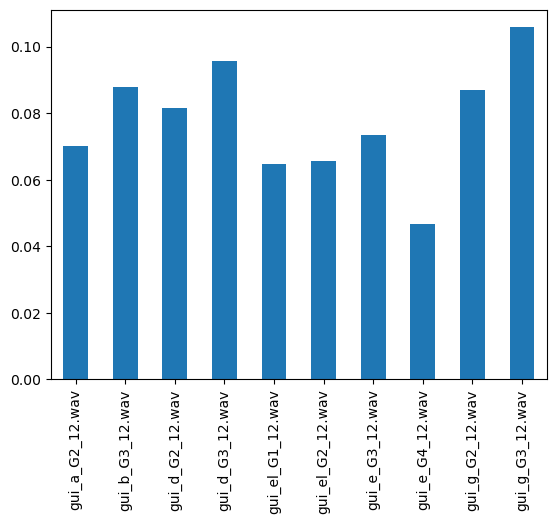

2


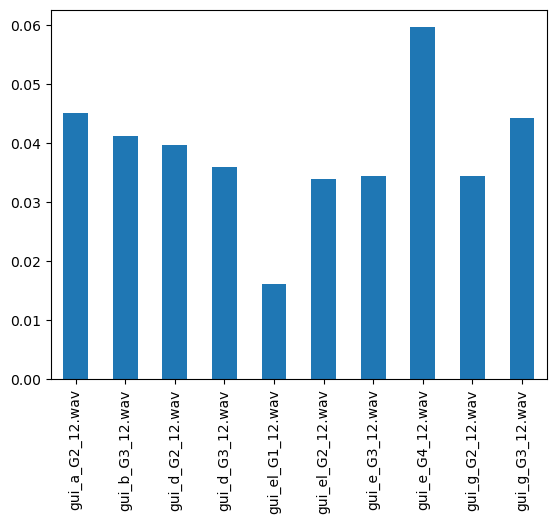

3


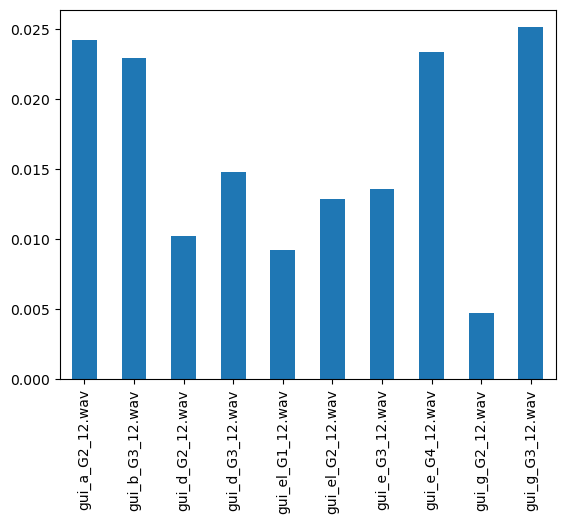

4


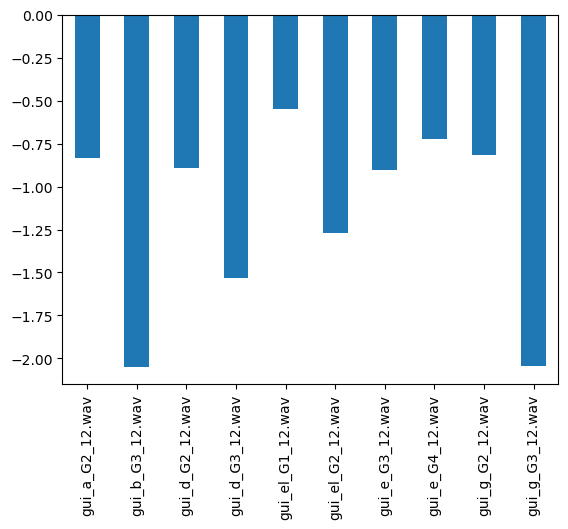

5


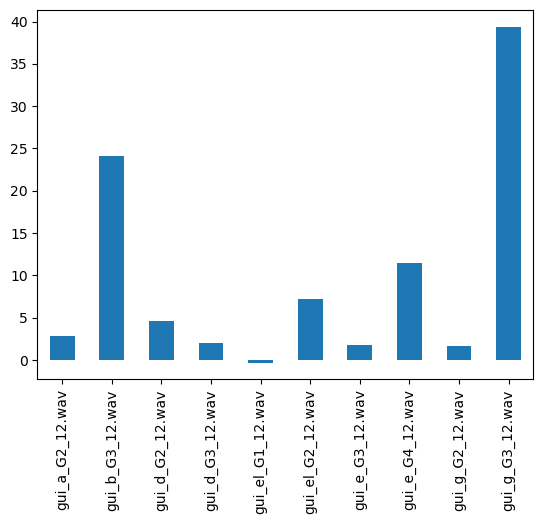

6


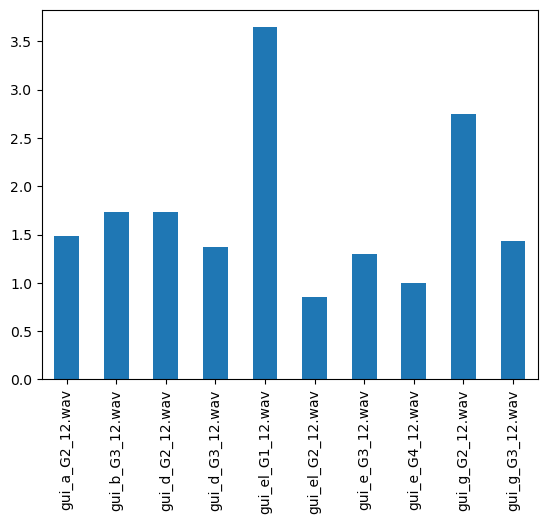

7


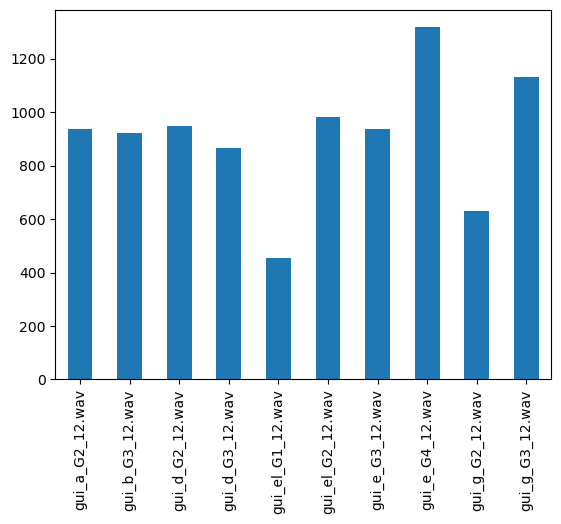

8


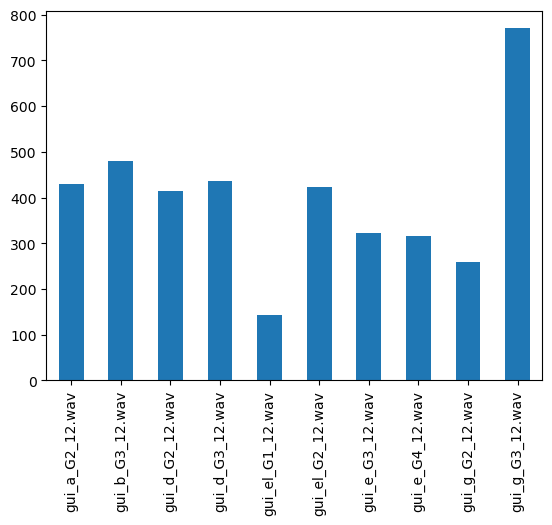

9


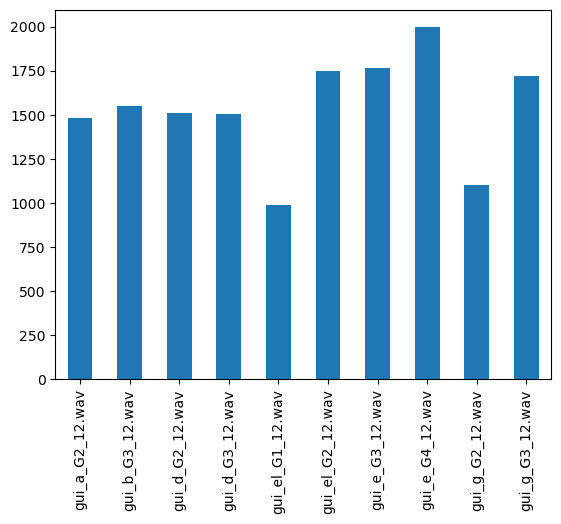

10


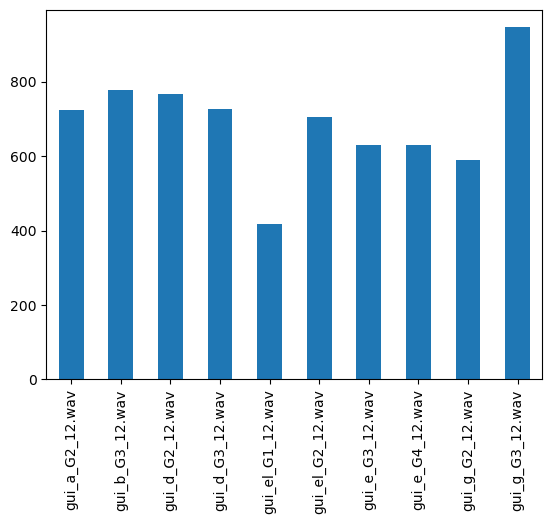

11


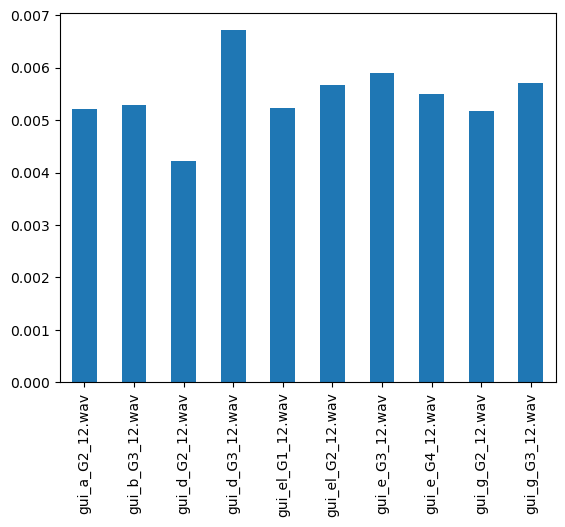

12


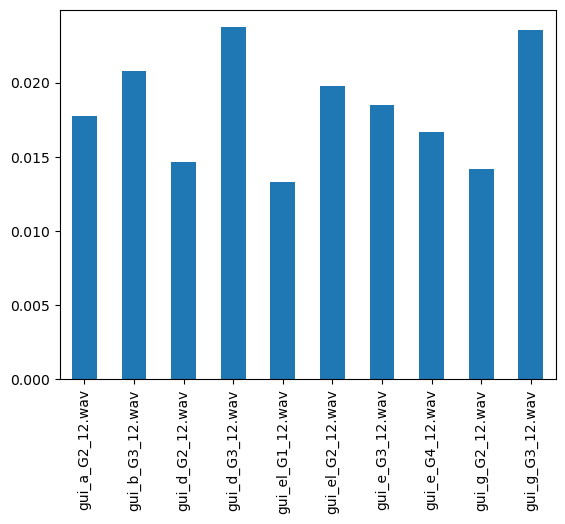

13


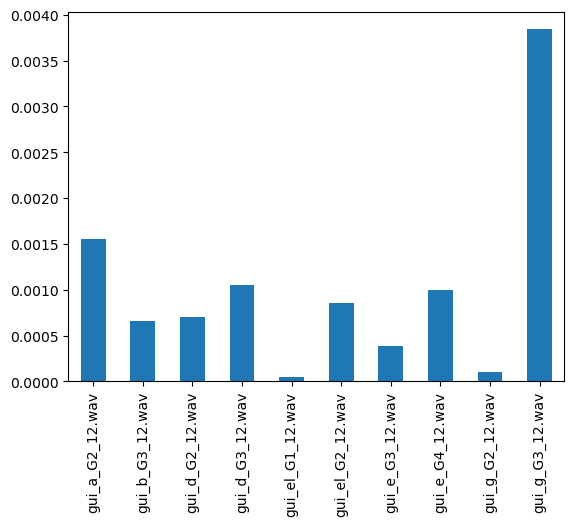

14


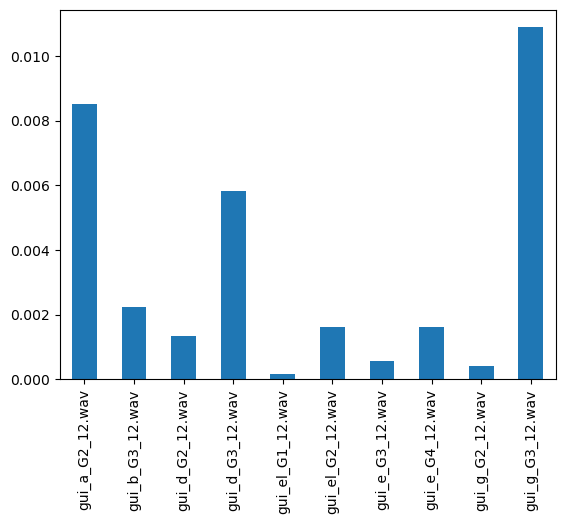

0


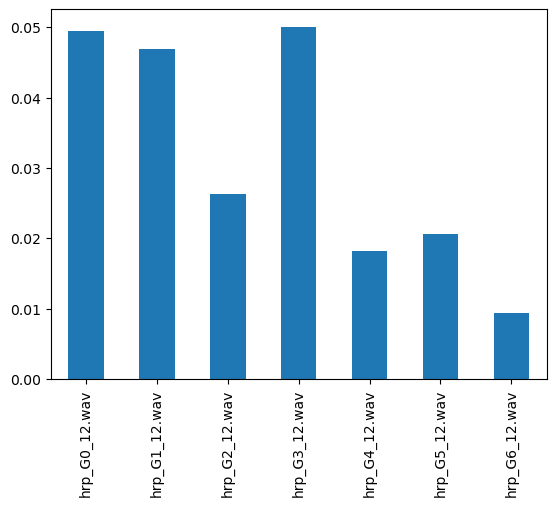

1


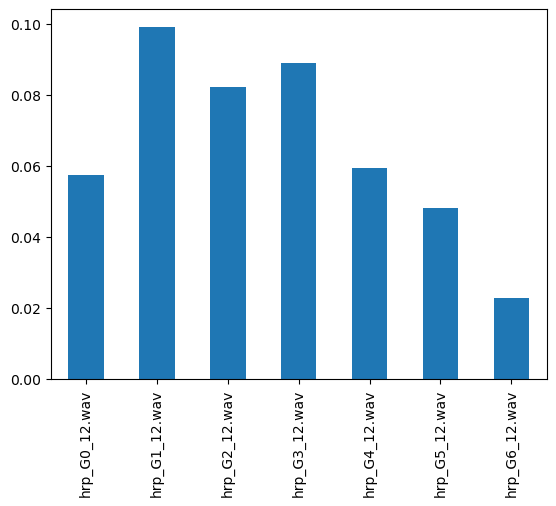

2


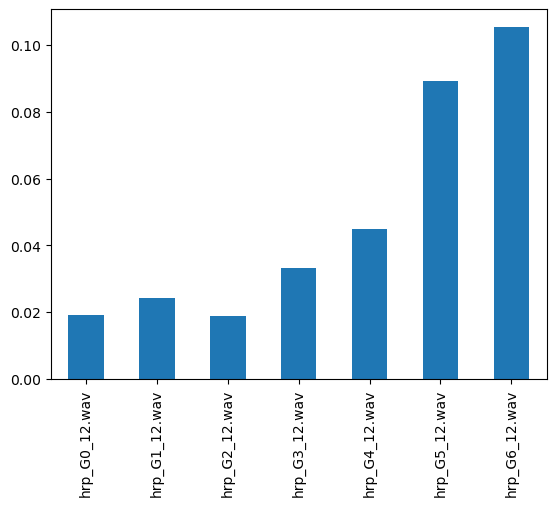

3


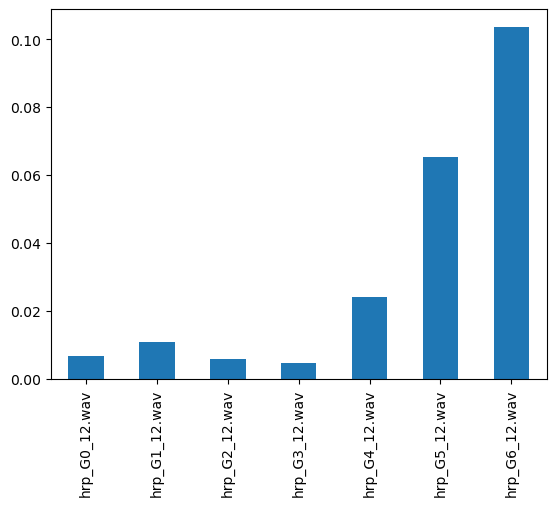

4


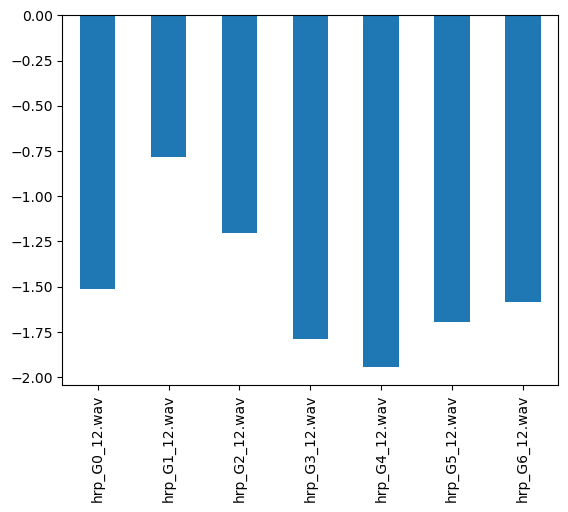

5


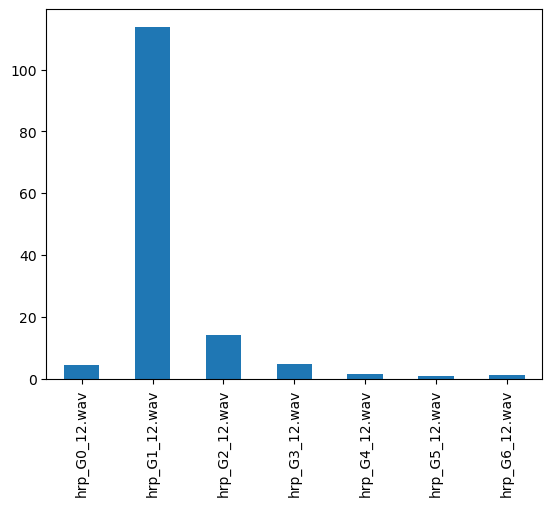

6


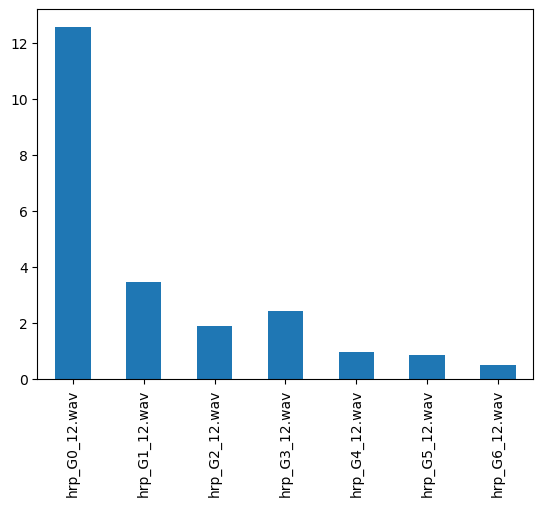

7


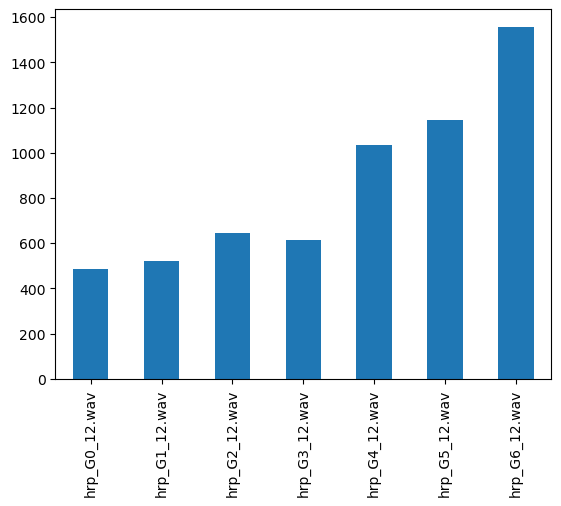

8


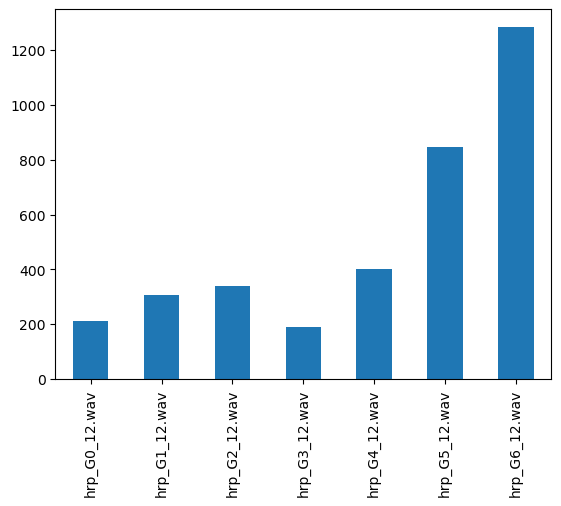

9


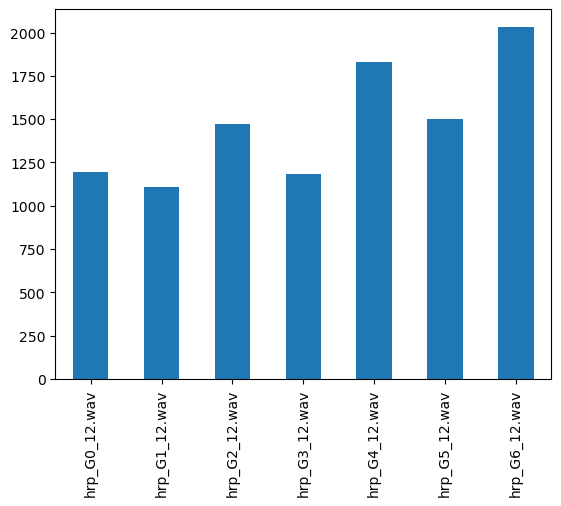

10


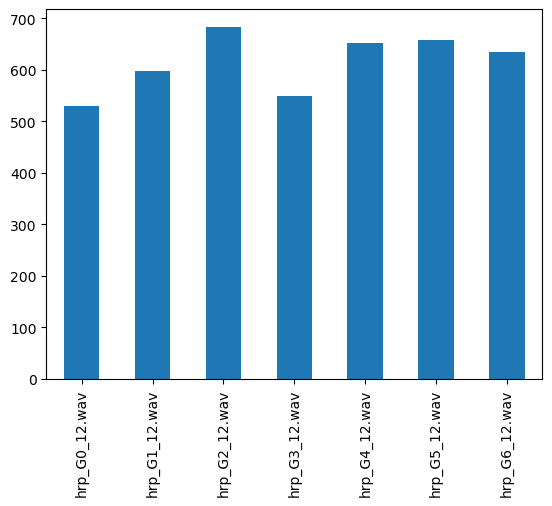

11


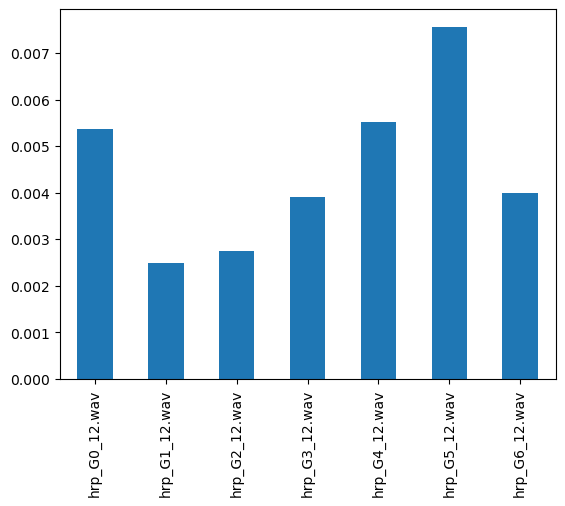

12


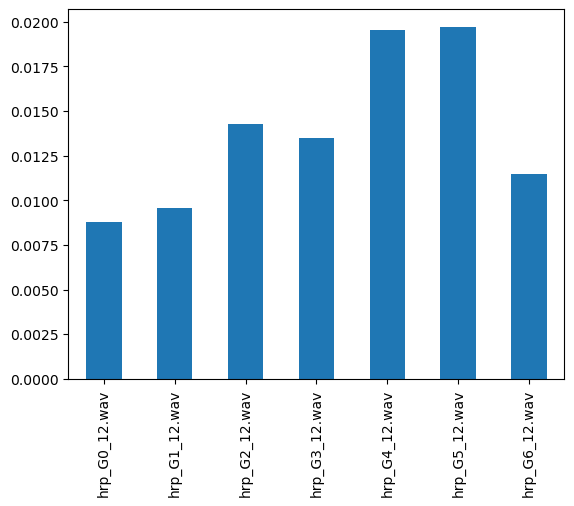

13


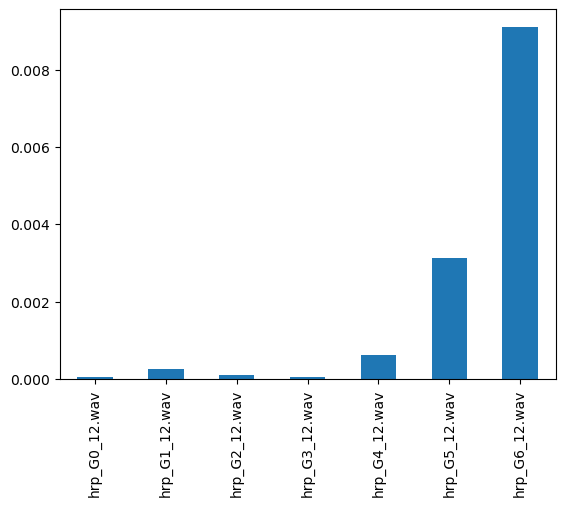

14


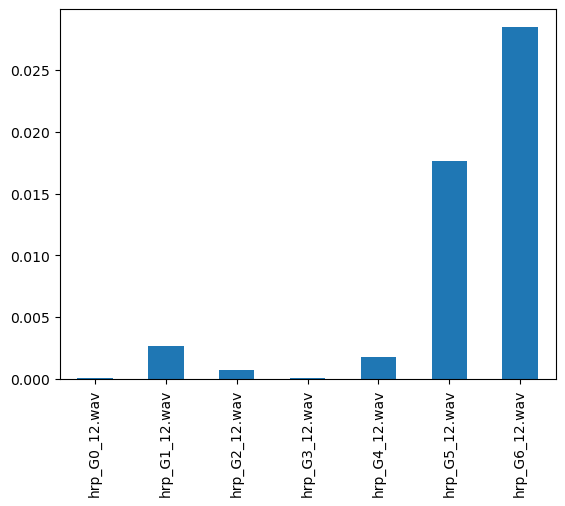

0


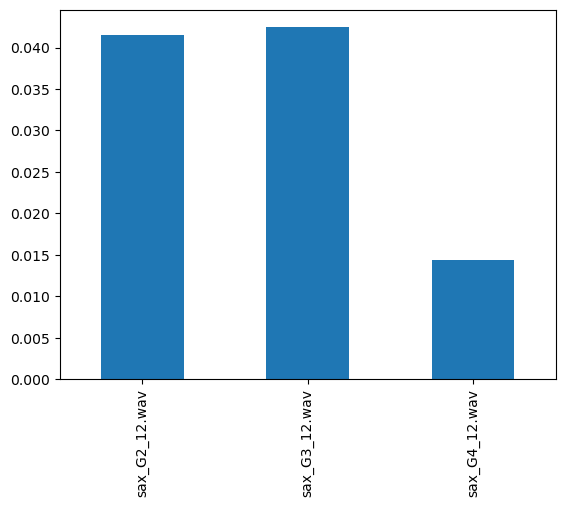

1


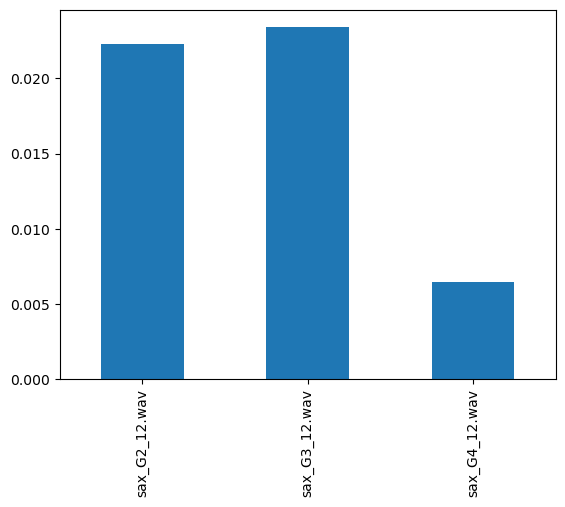

2


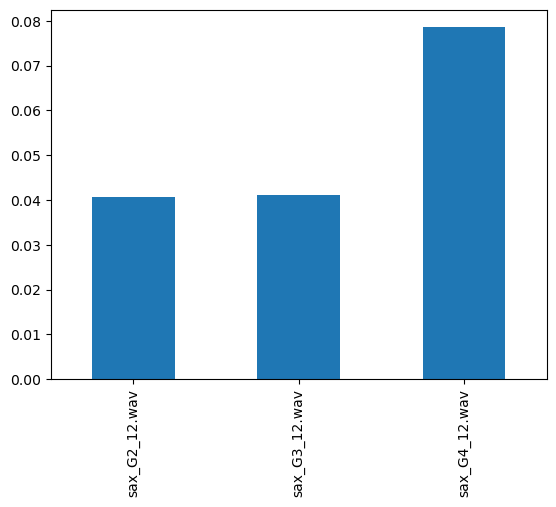

3


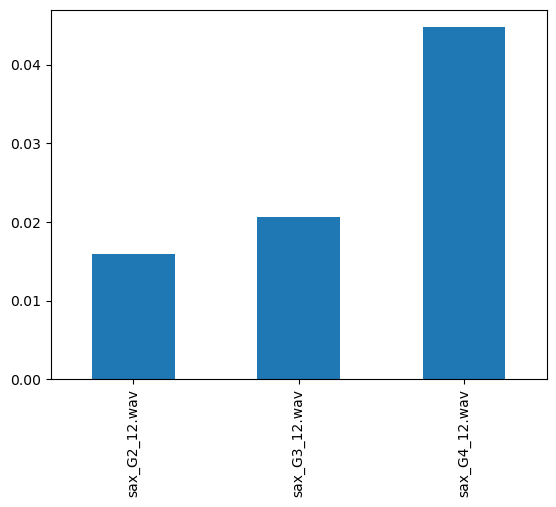

4


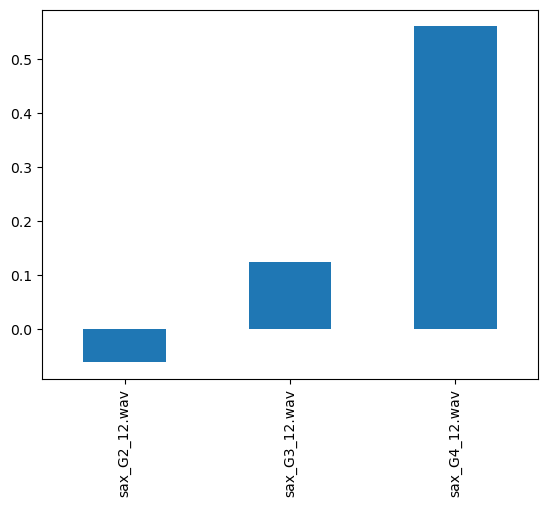

5


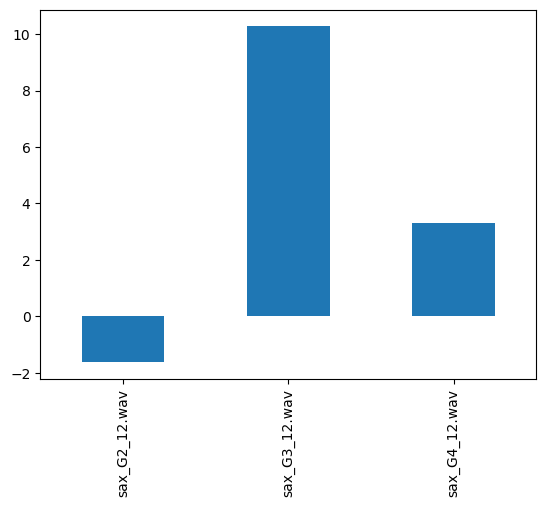

6


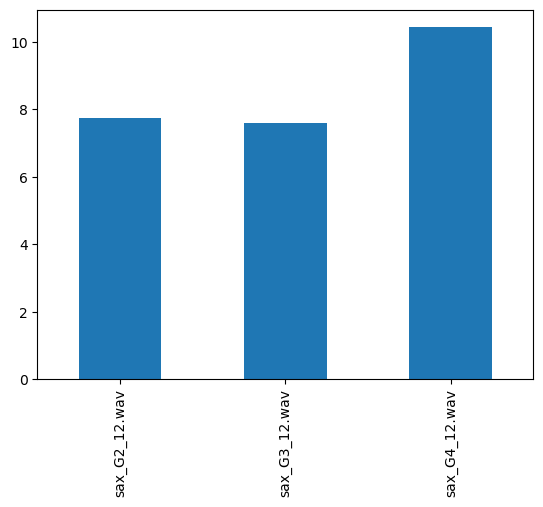

7


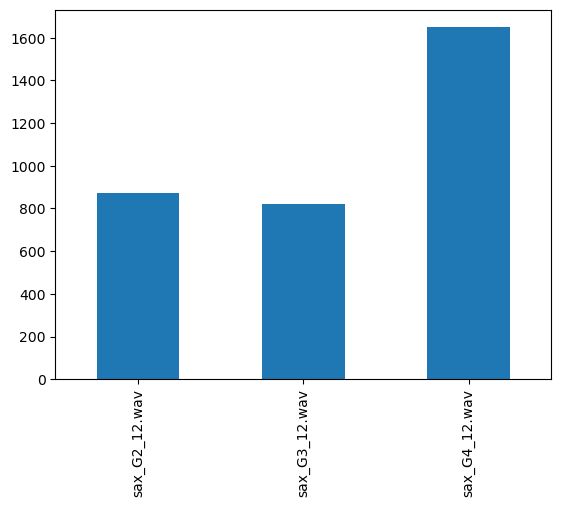

8


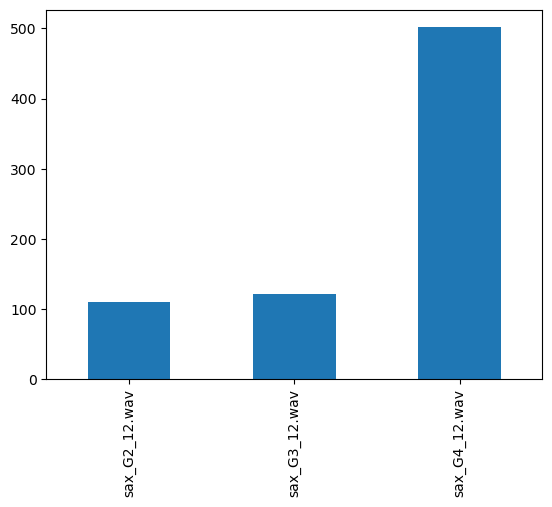

9


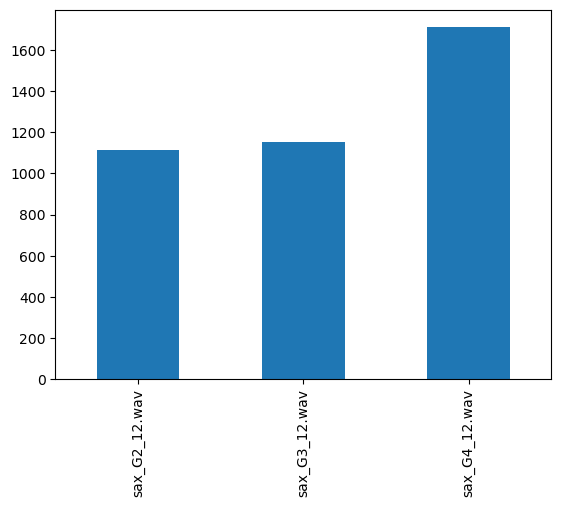

10


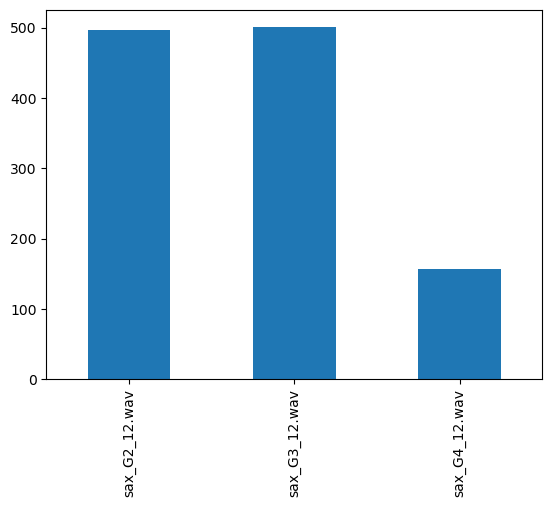

11


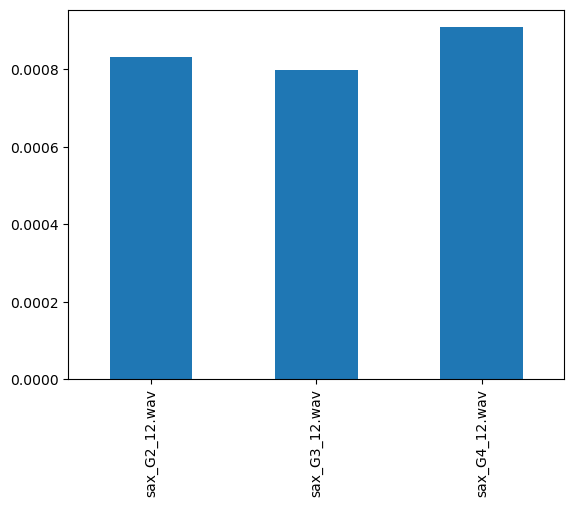

12


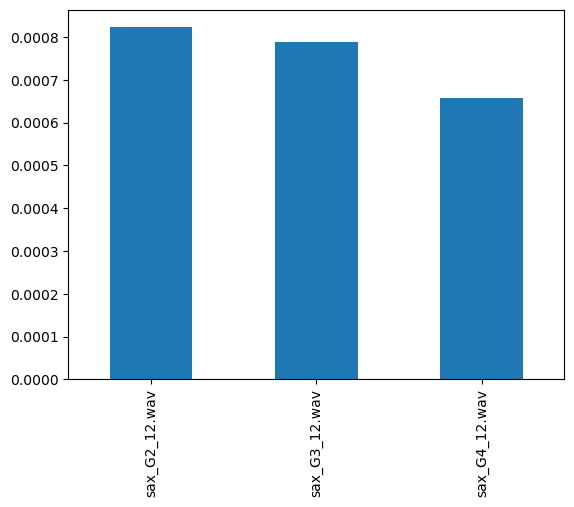

13


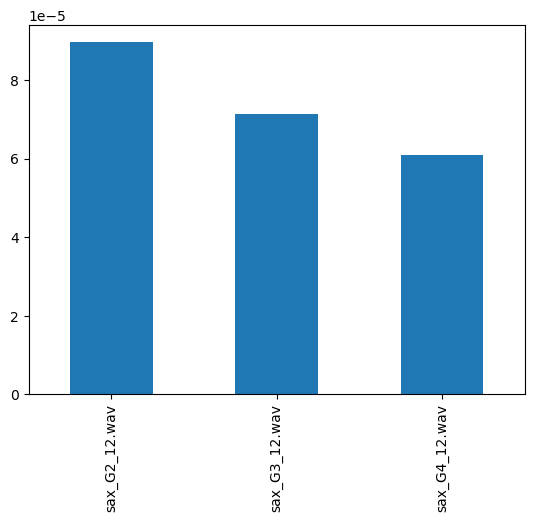

14


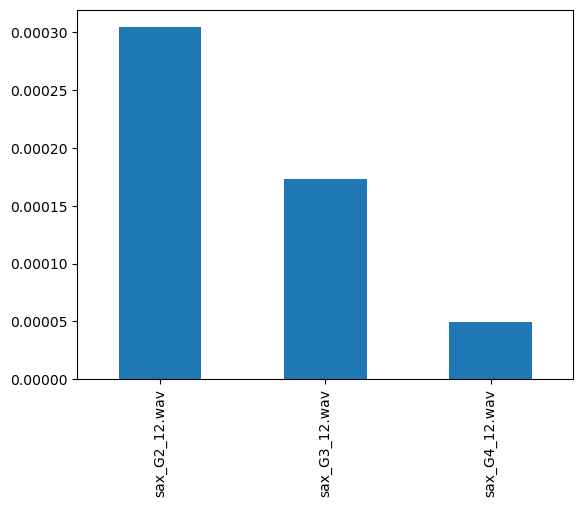

0


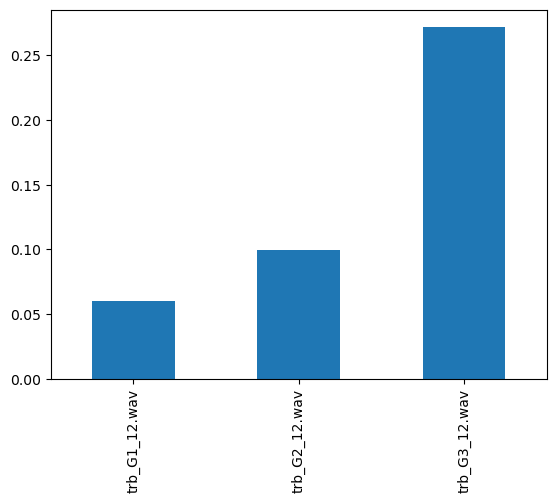

1


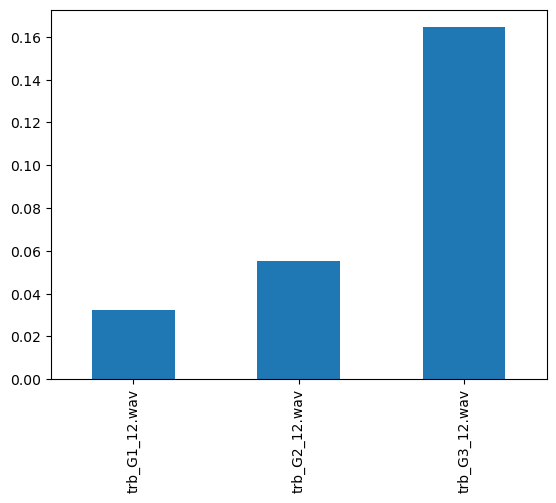

2


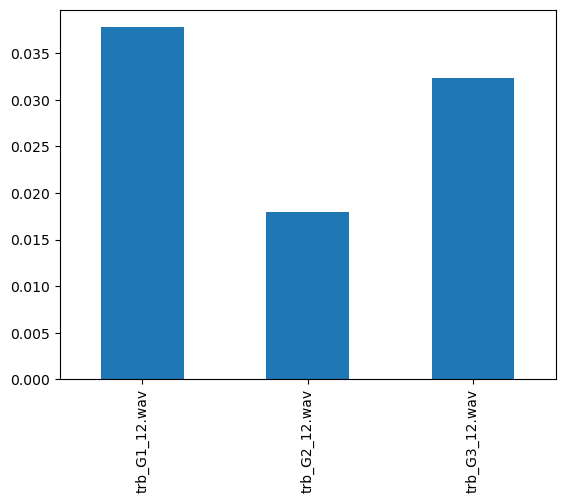

3


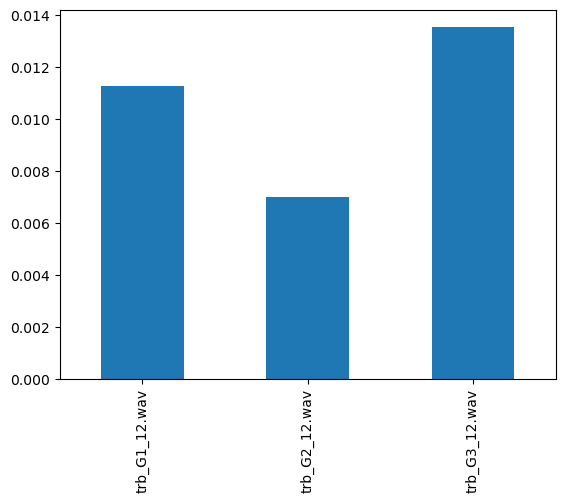

4


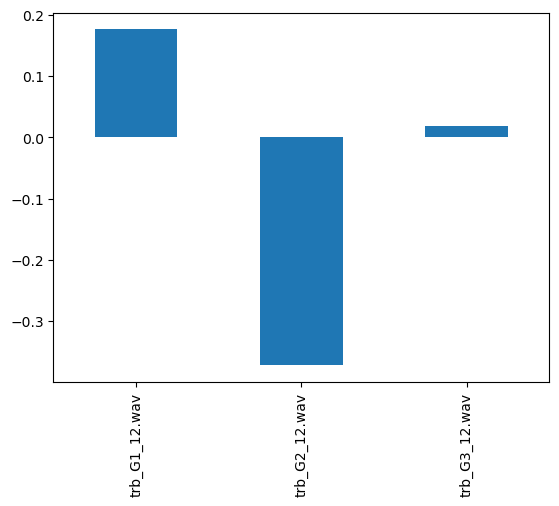

5


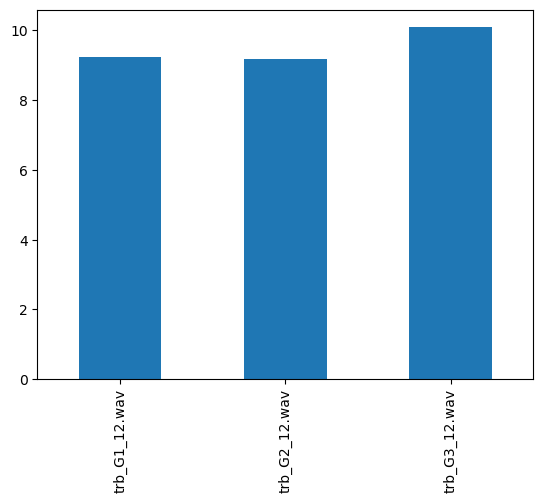

6


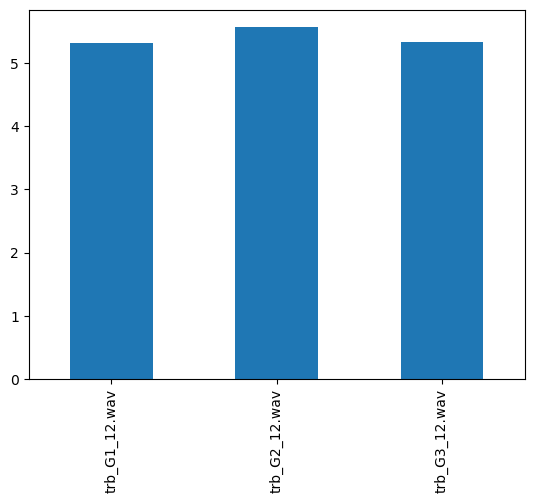

7


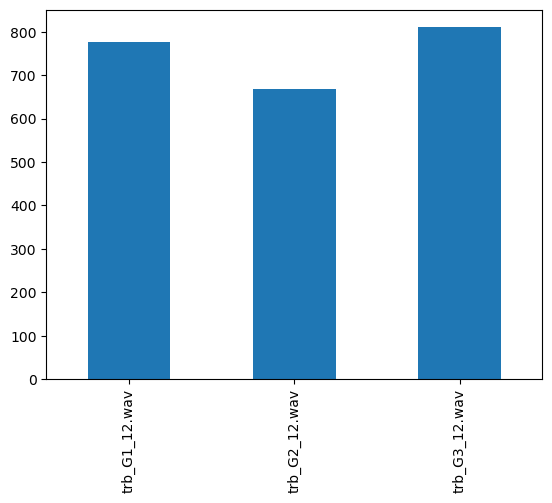

8


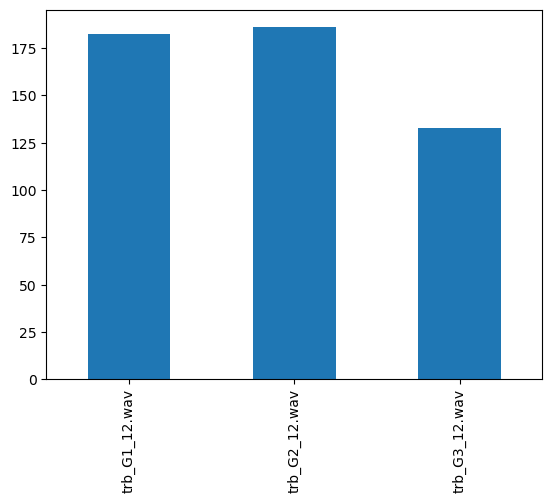

9


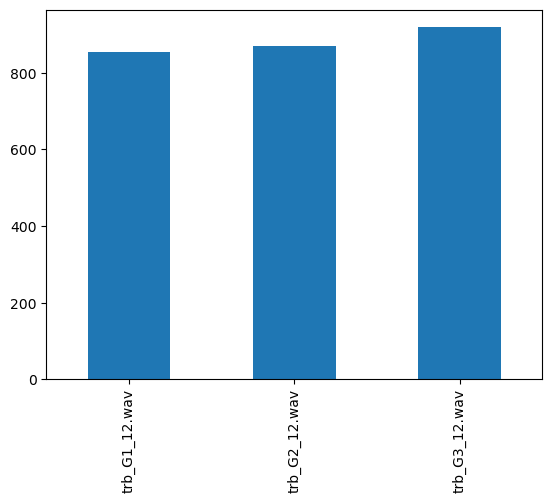

10


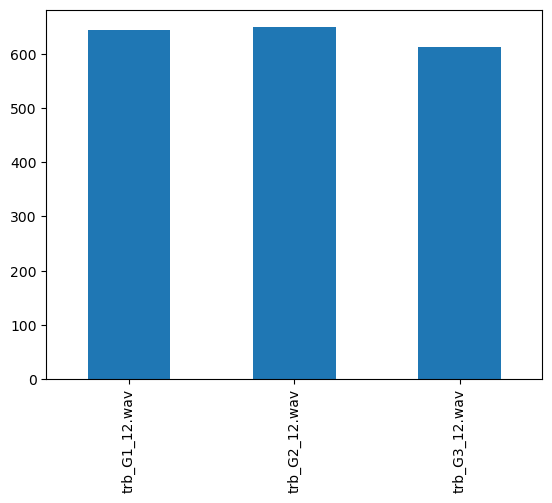

11


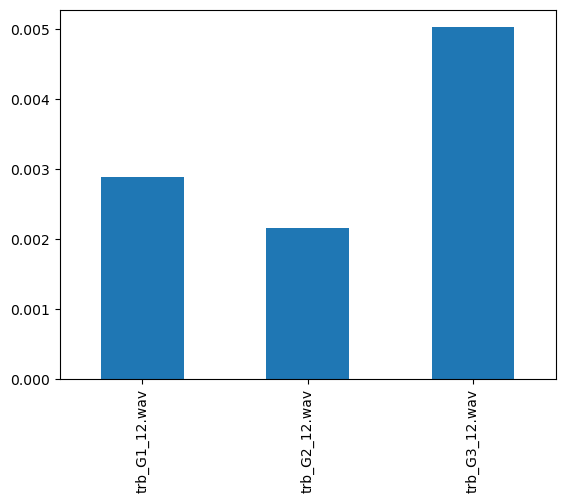

12


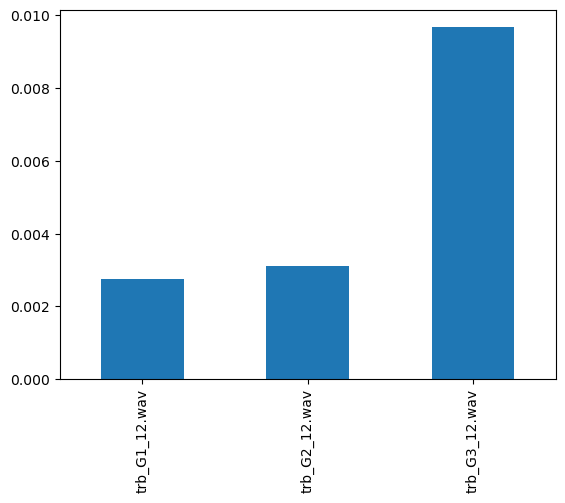

13


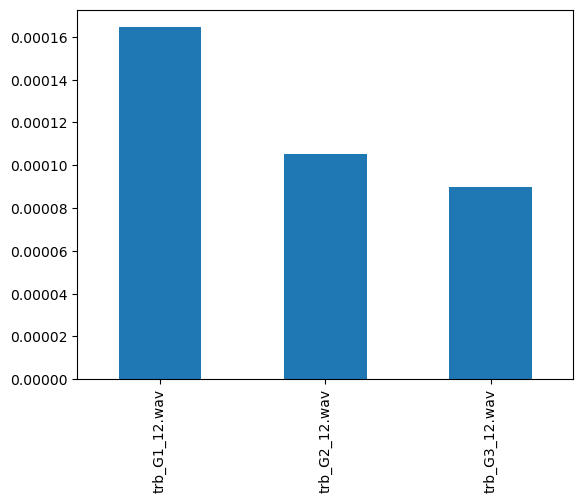

14


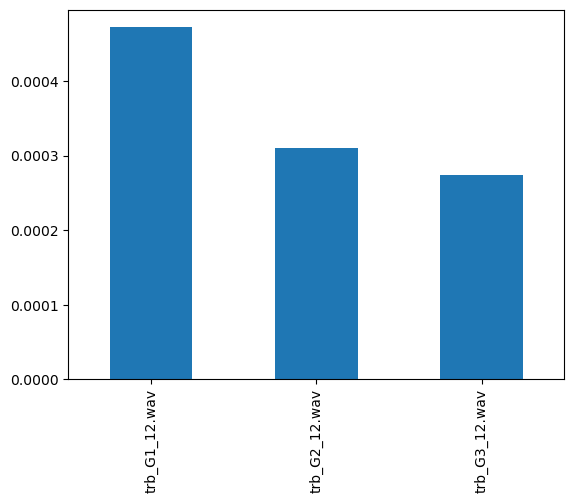

0


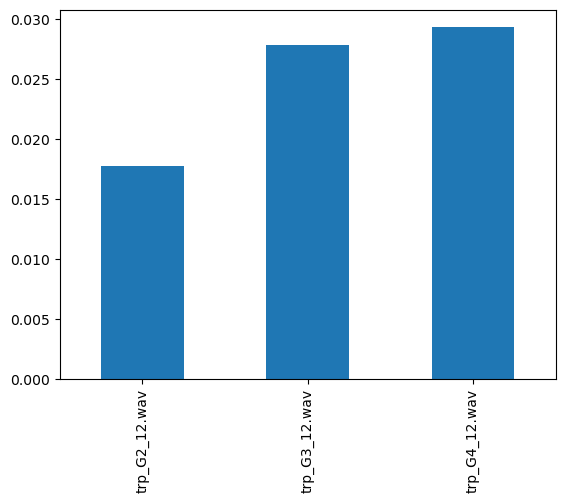

1


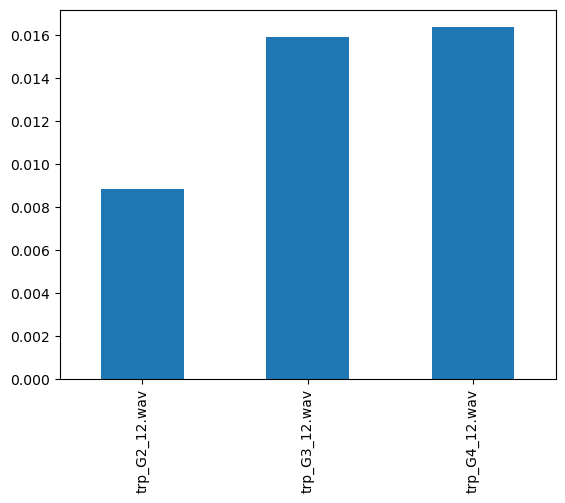

2


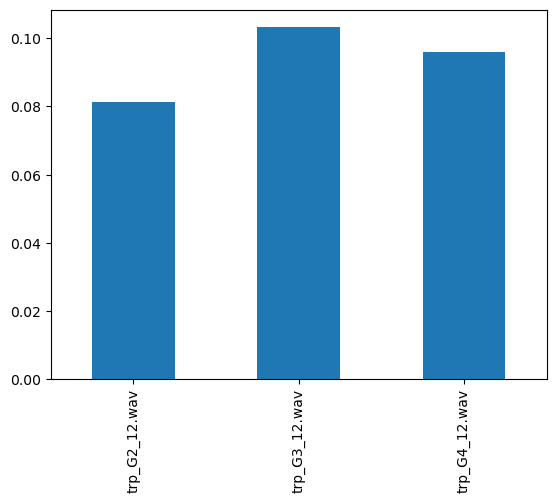

3


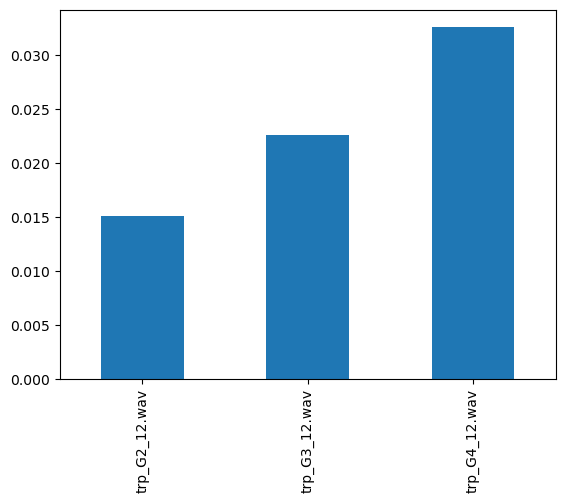

4


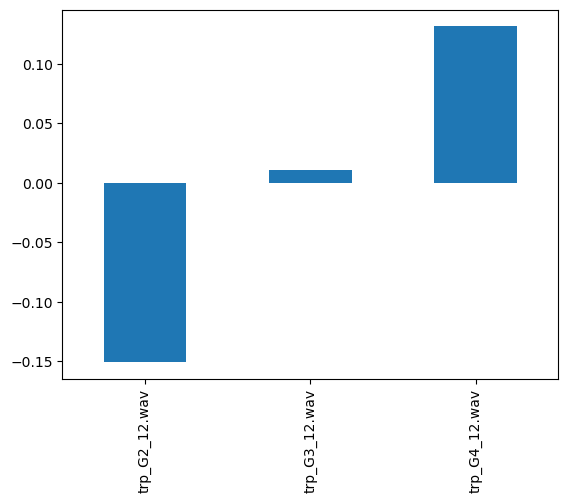

5


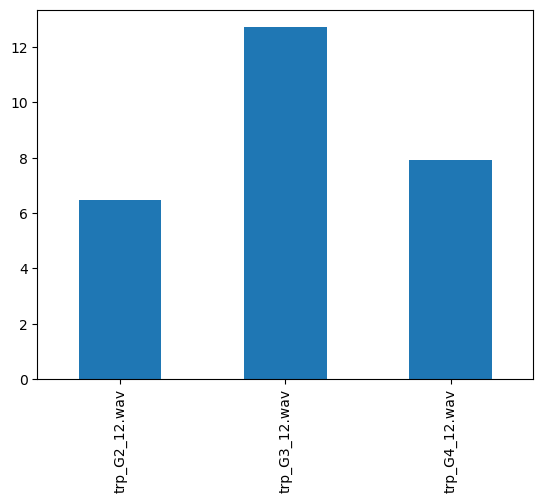

6


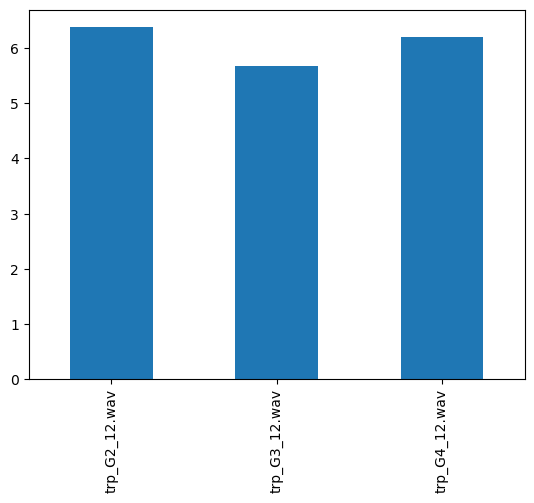

7


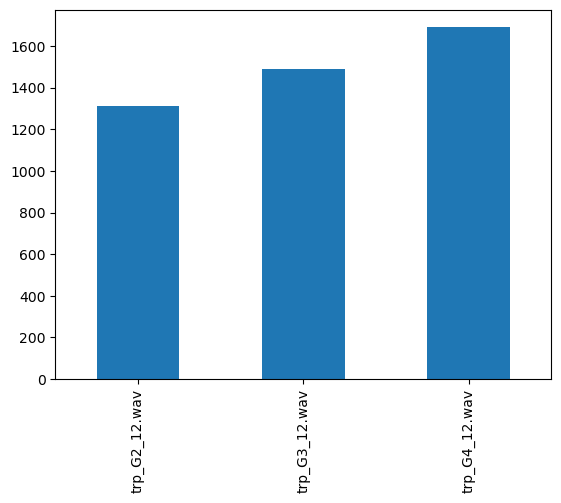

8


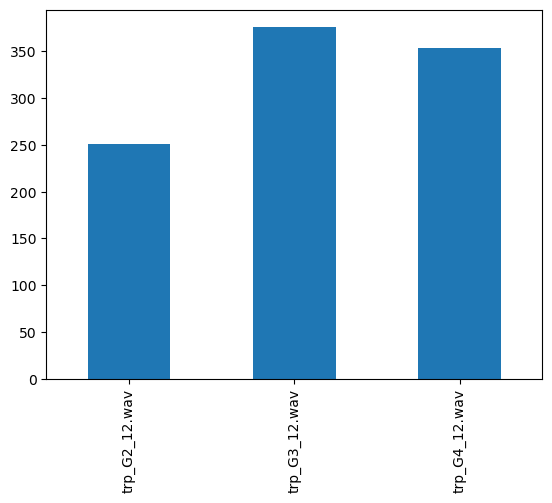

9


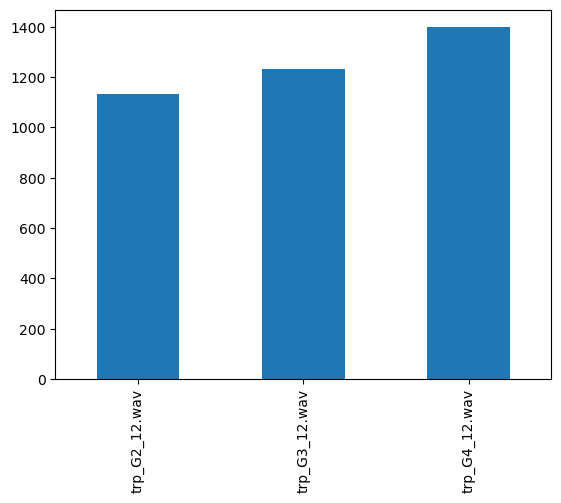

10


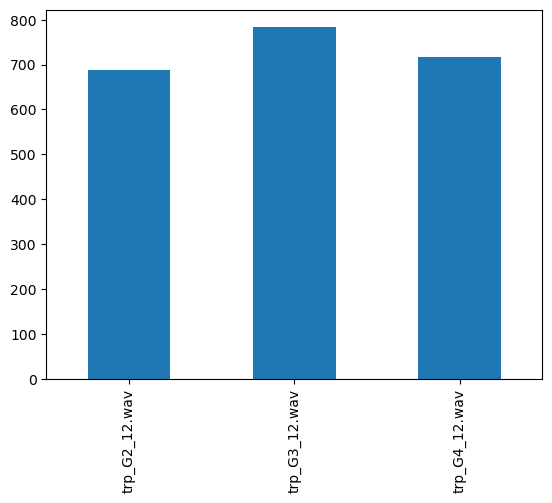

11


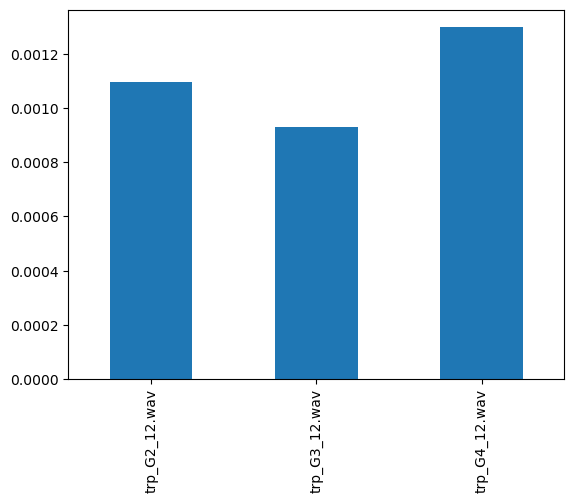

12


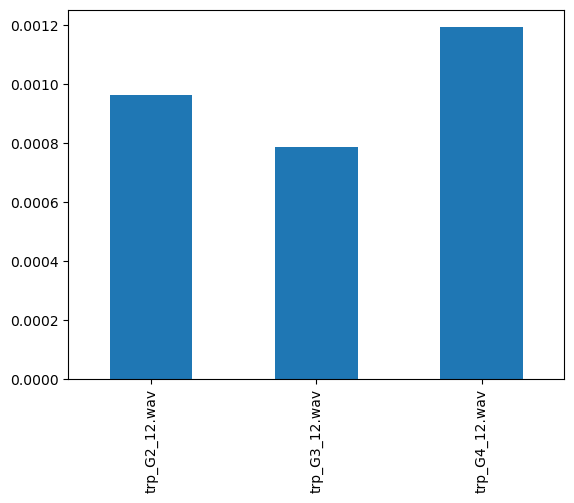

13


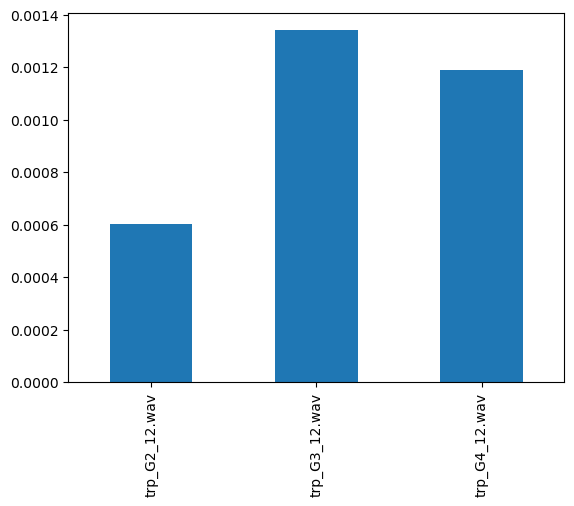

14


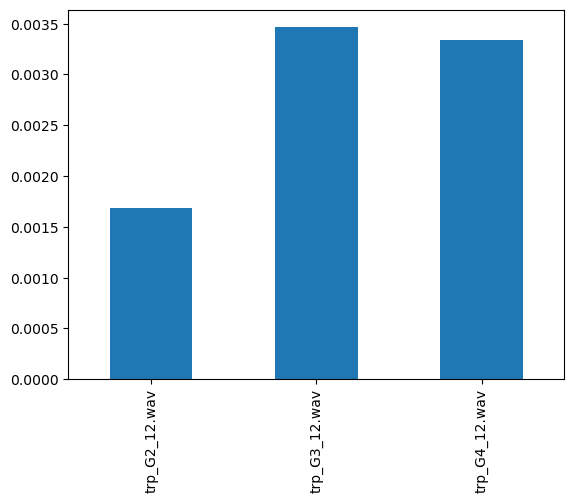

0


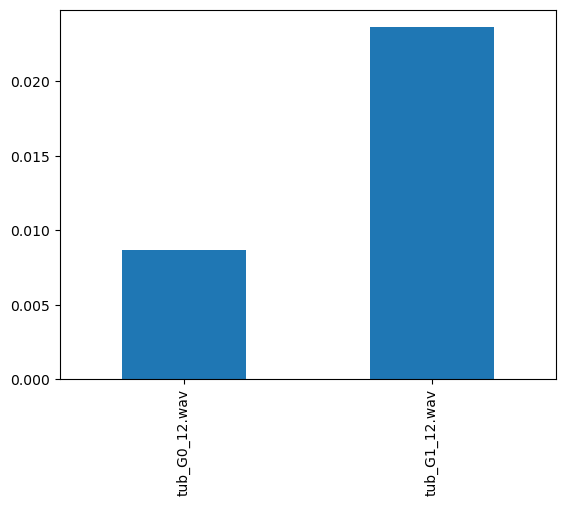

1


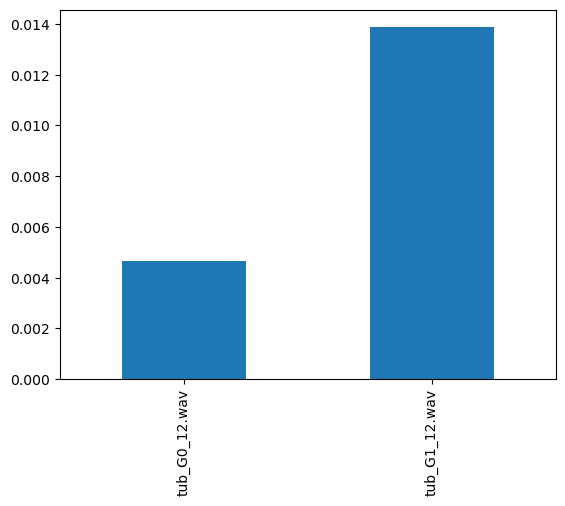

2


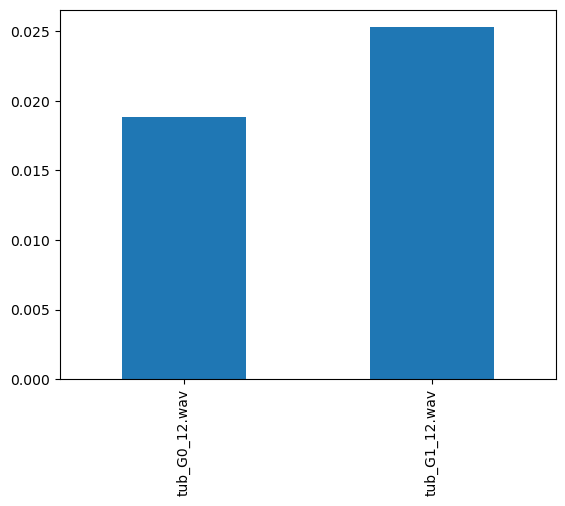

3


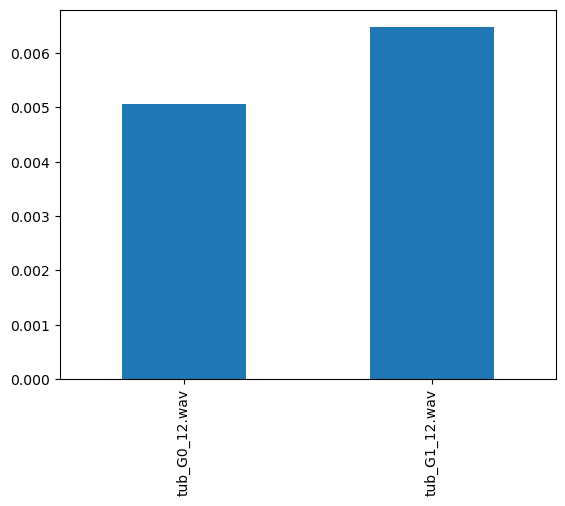

4


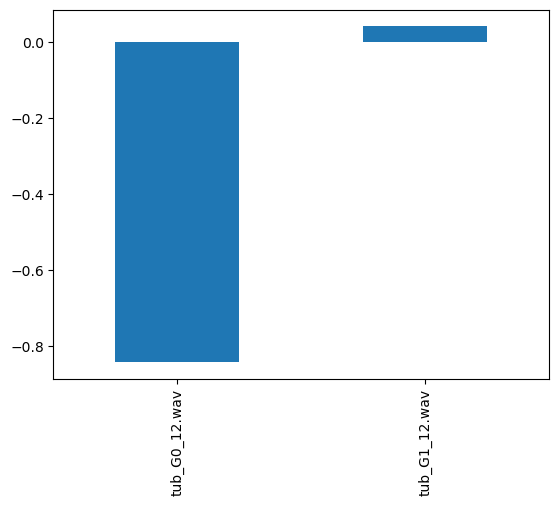

5


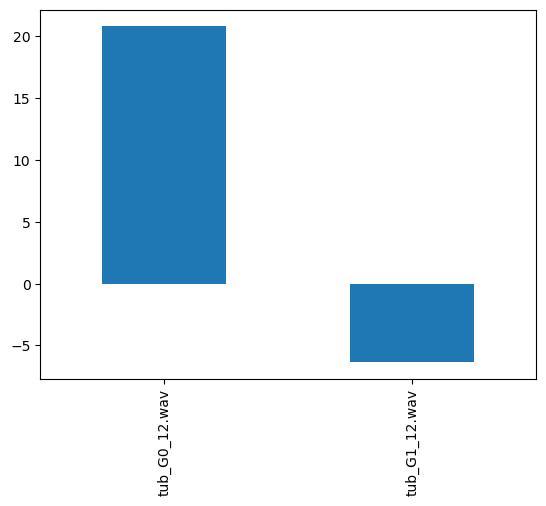

6


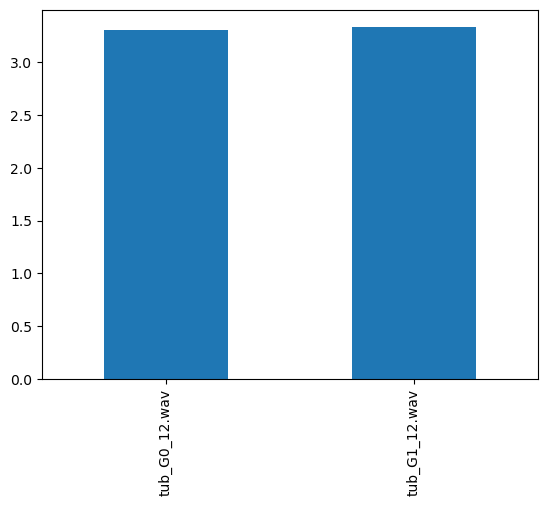

7


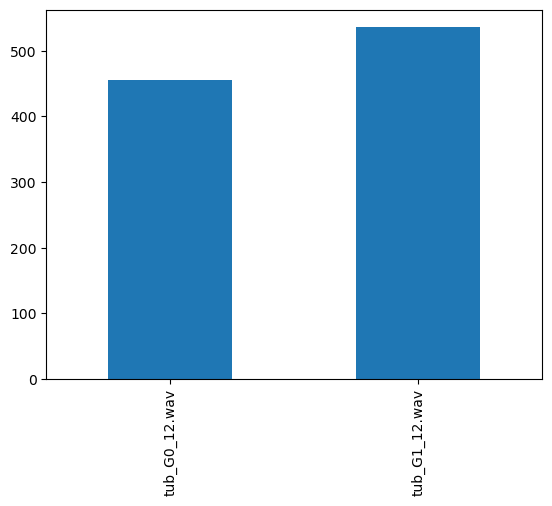

8


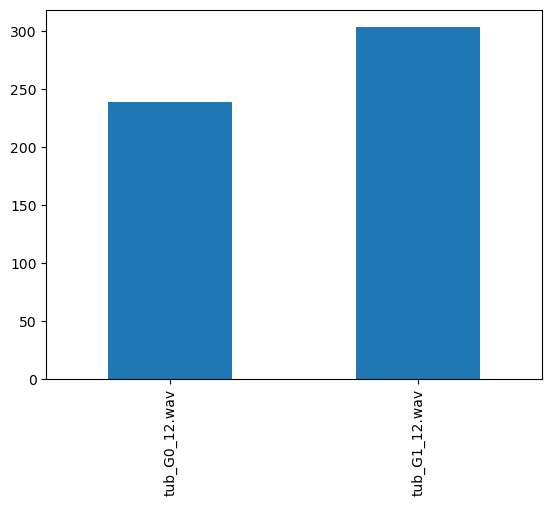

9


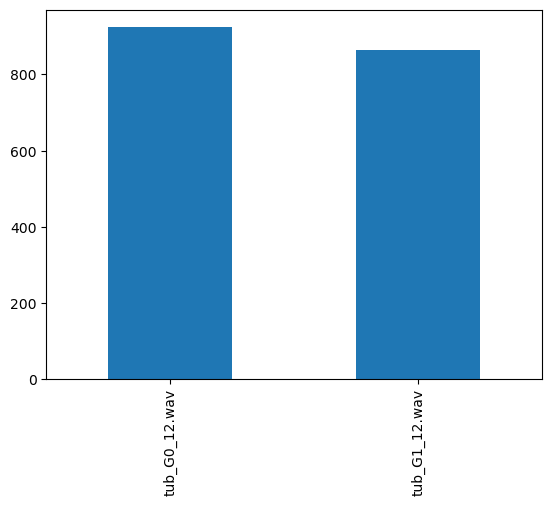

10


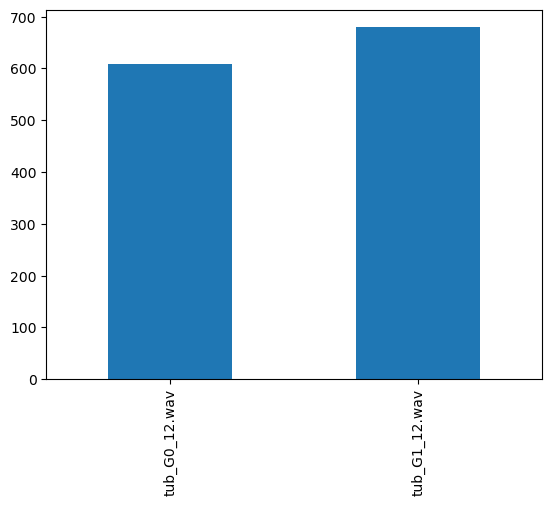

11


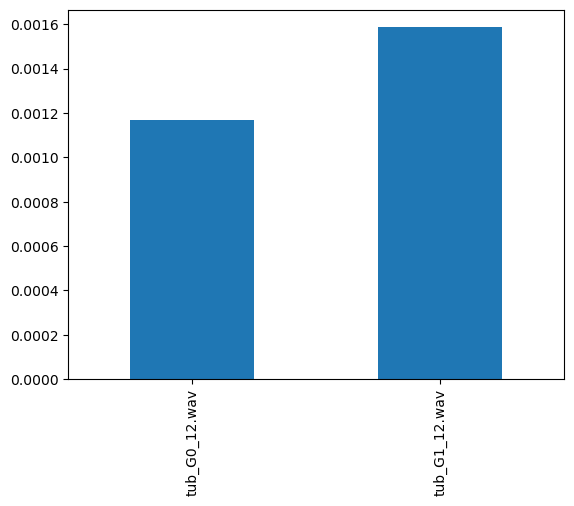

12


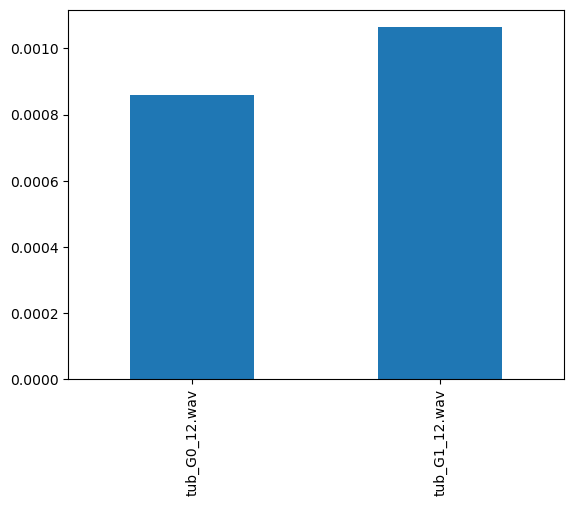

13


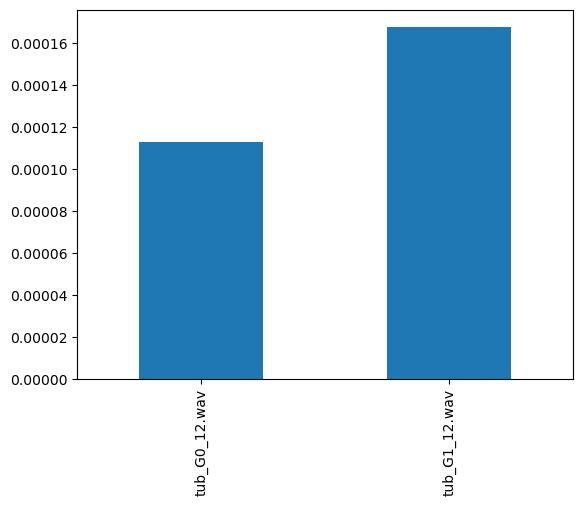

14


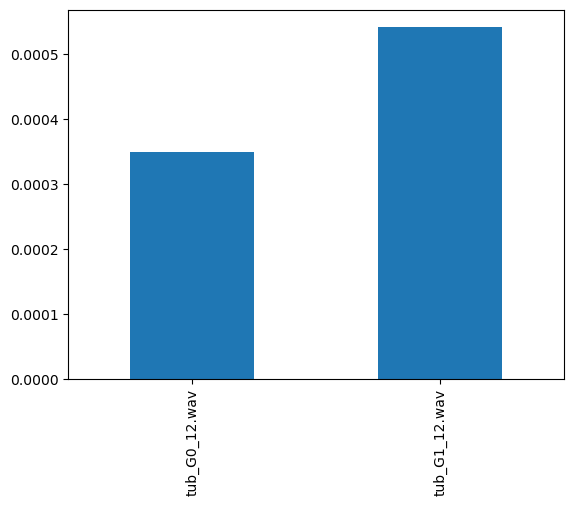

0


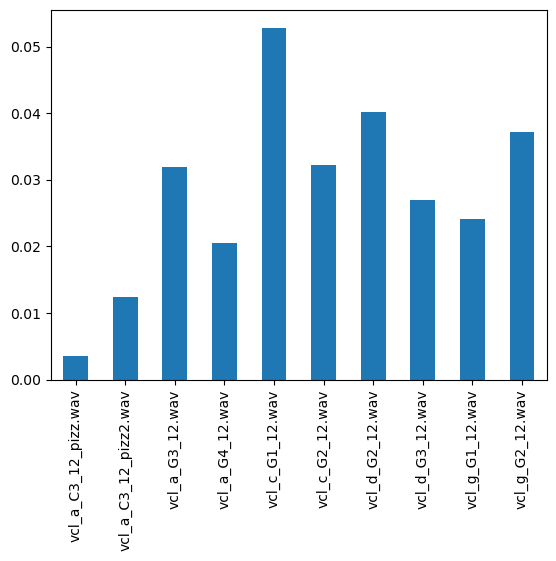

1


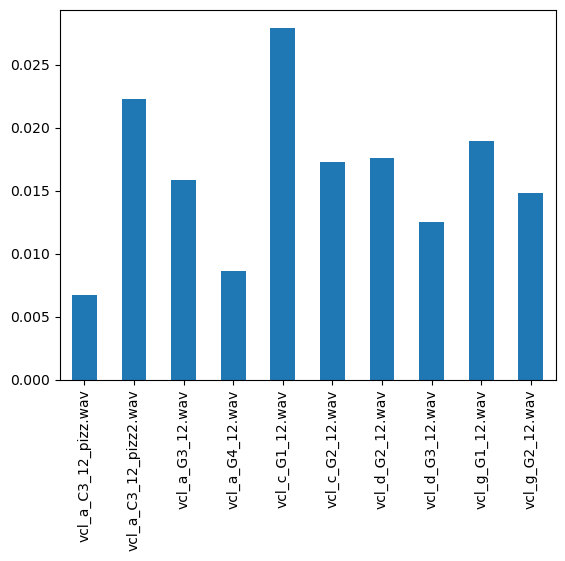

2


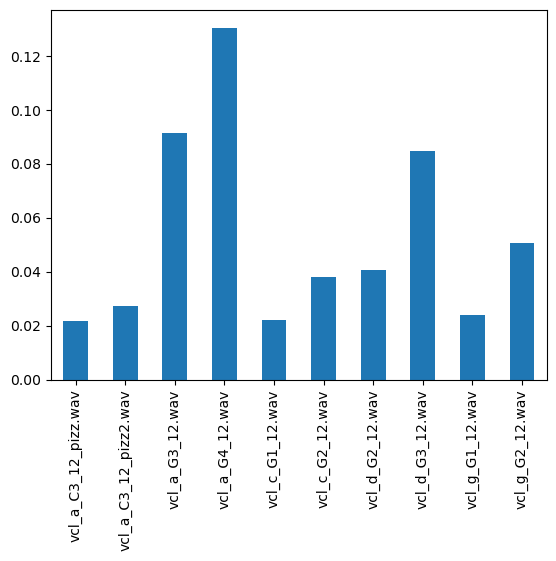

3


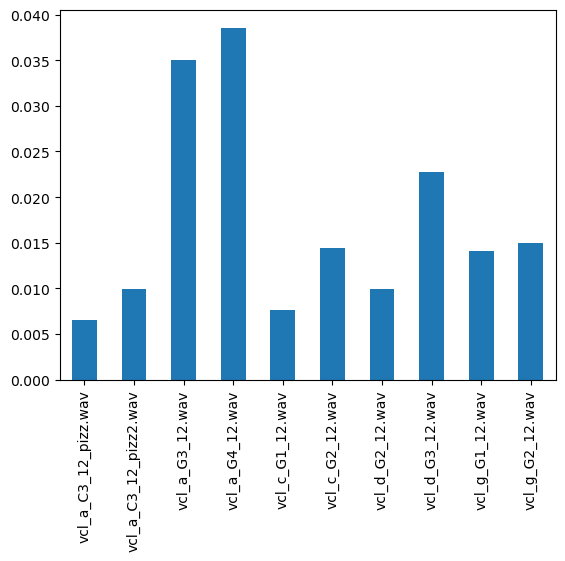

4


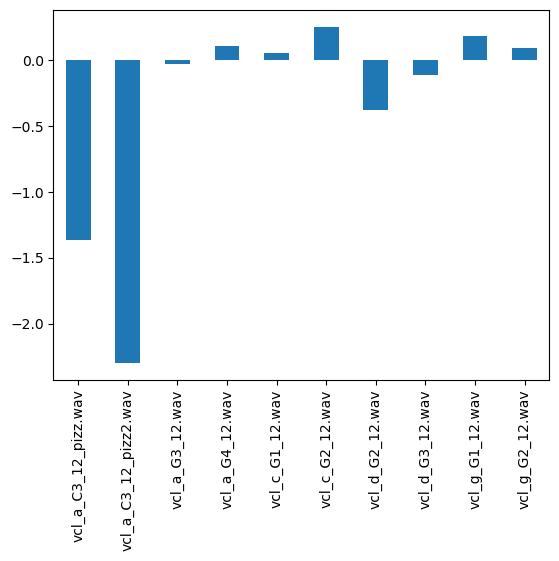

5


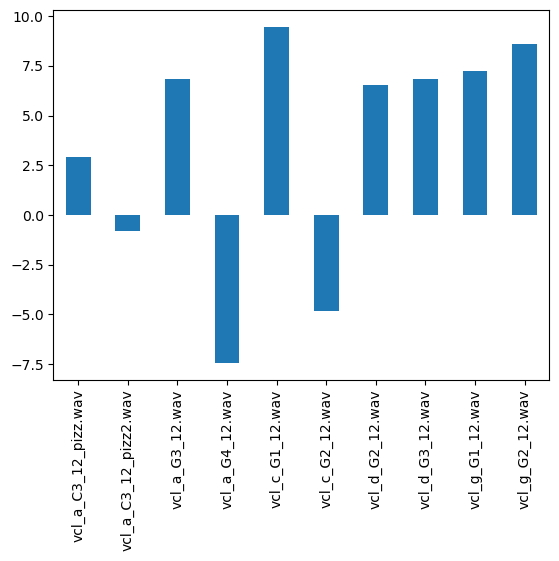

6


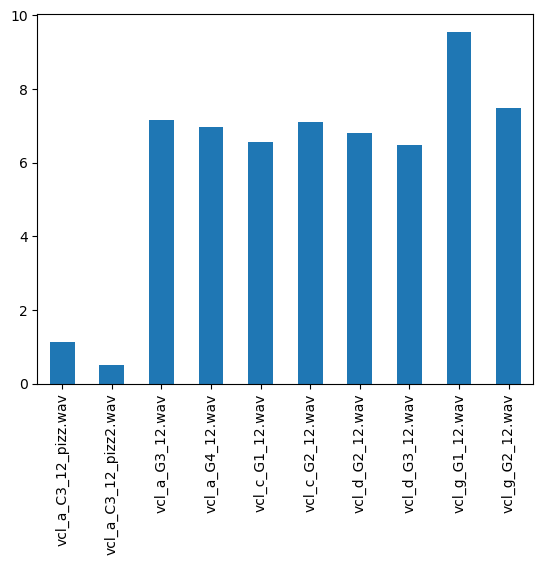

7


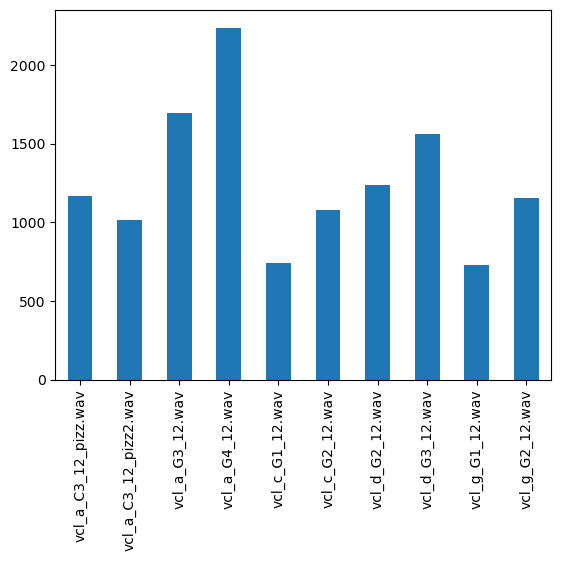

8


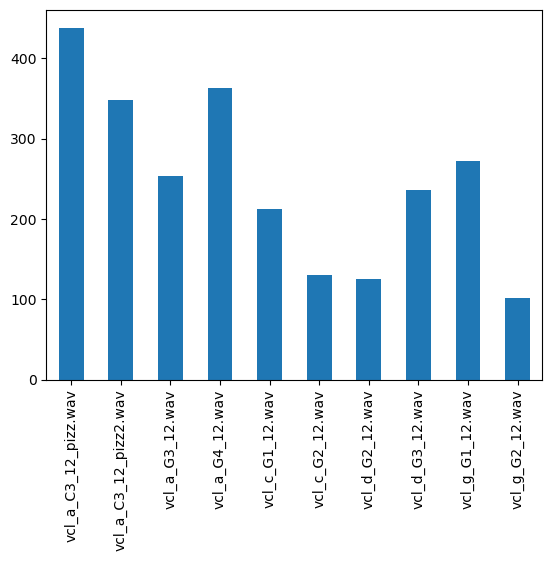

9


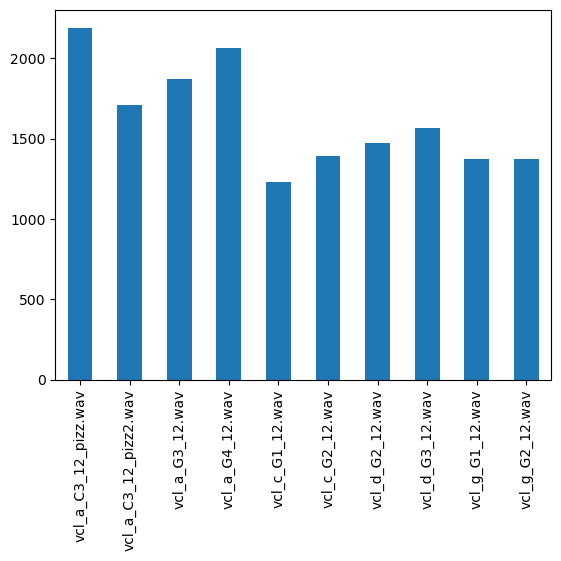

10


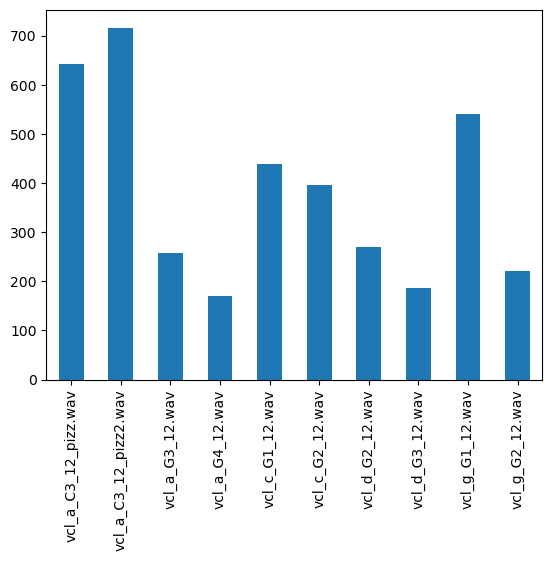

11


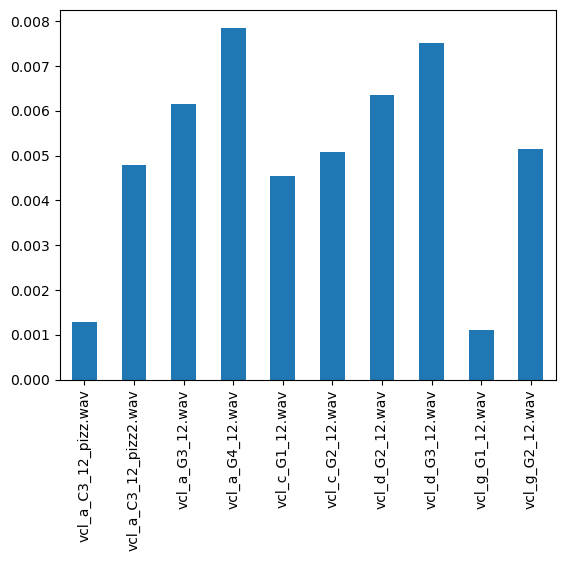

12


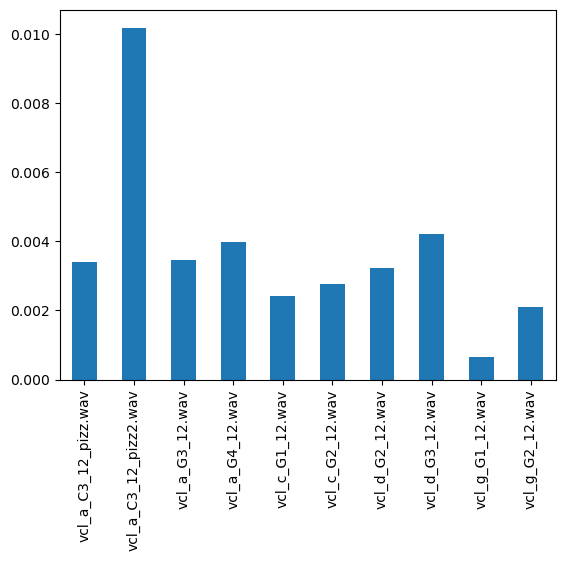

13


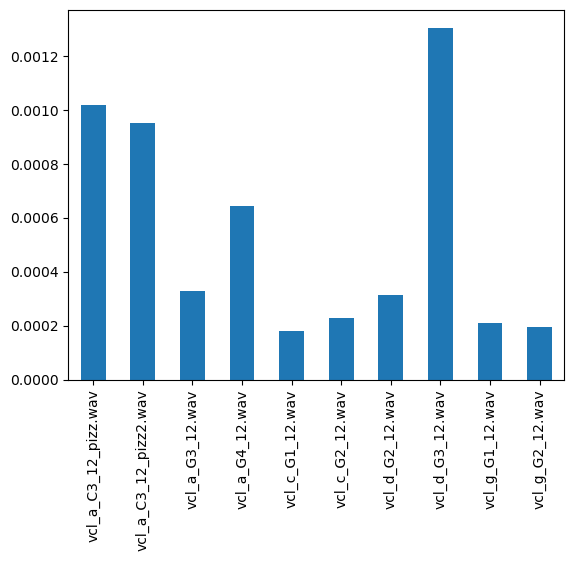

14


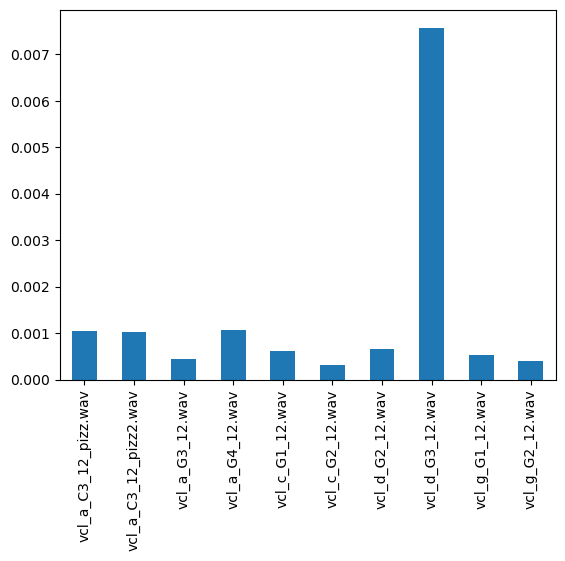

0


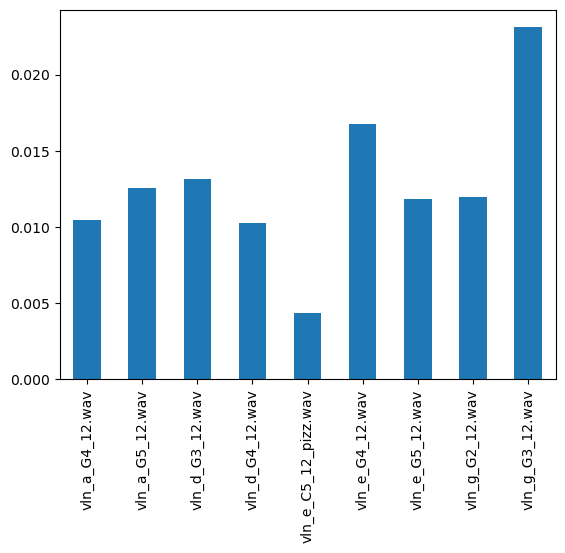

1


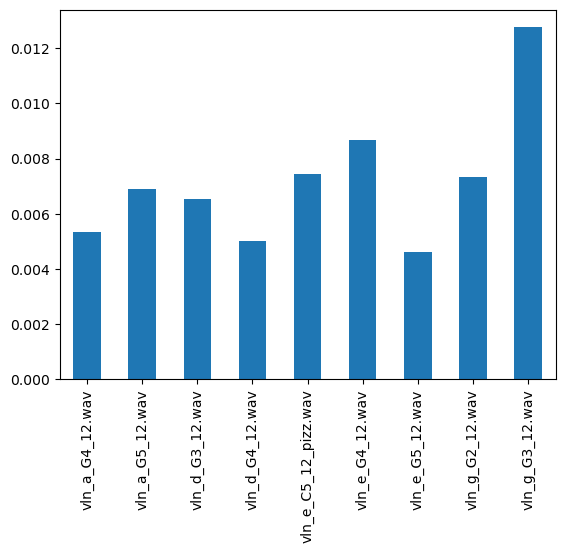

2


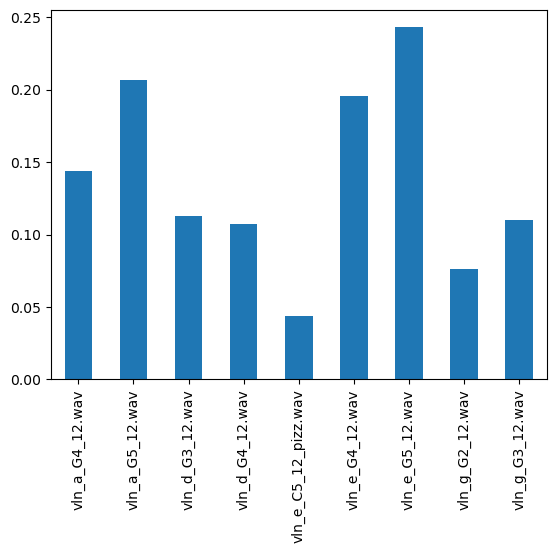

3


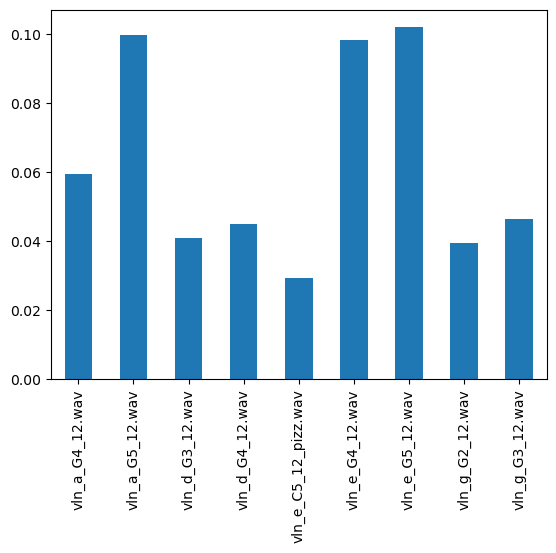

4


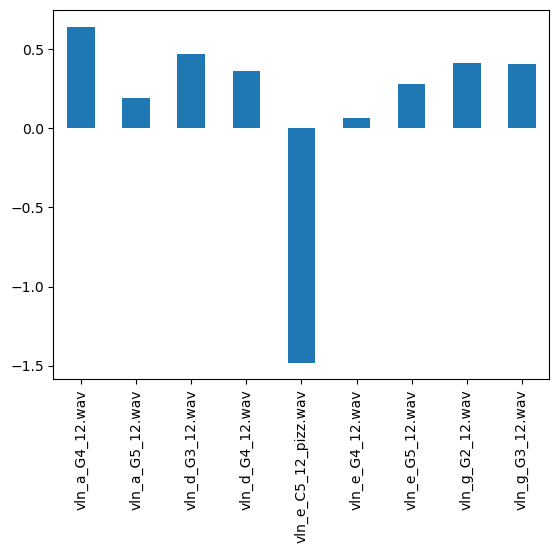

5


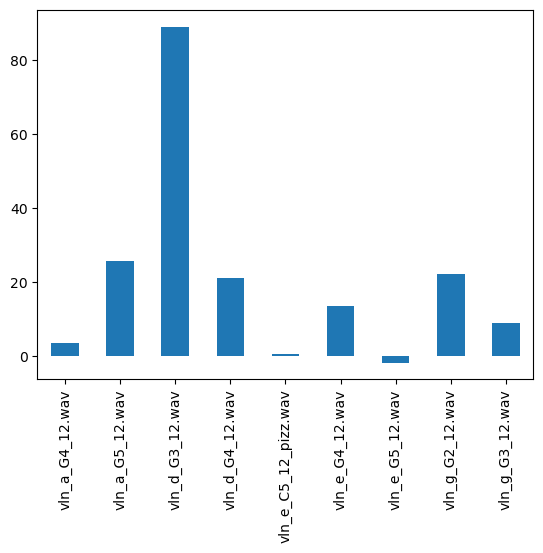

6


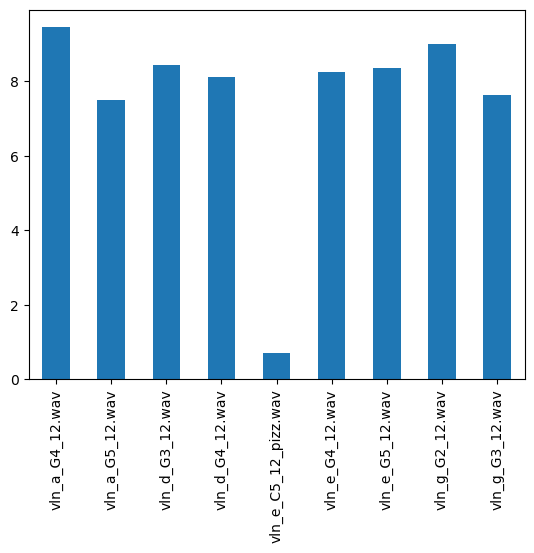

7


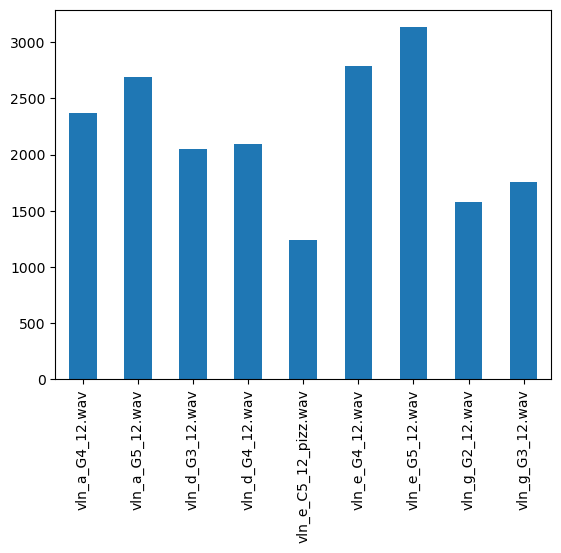

8


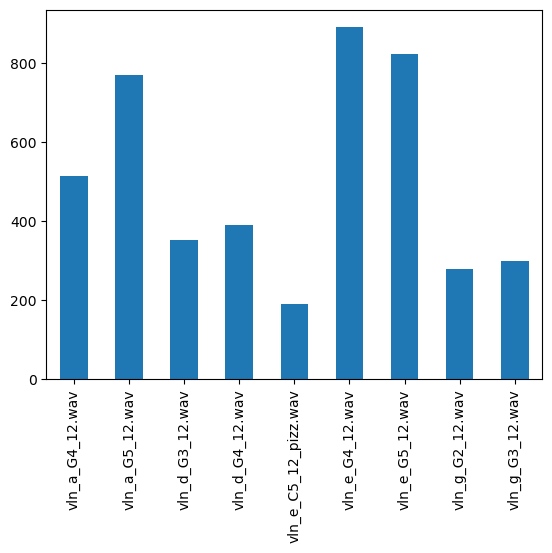

9


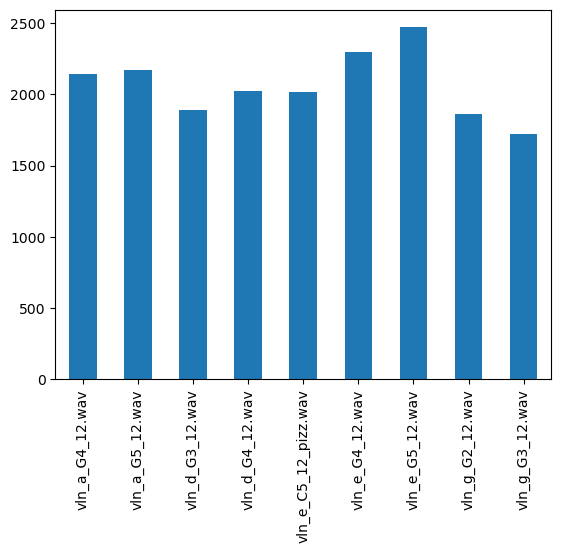

10


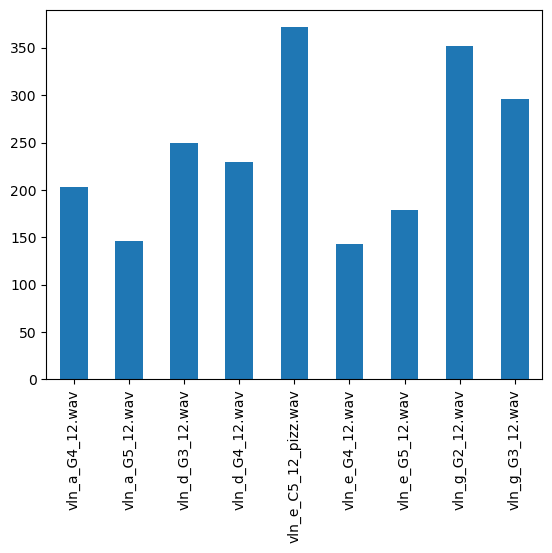

11


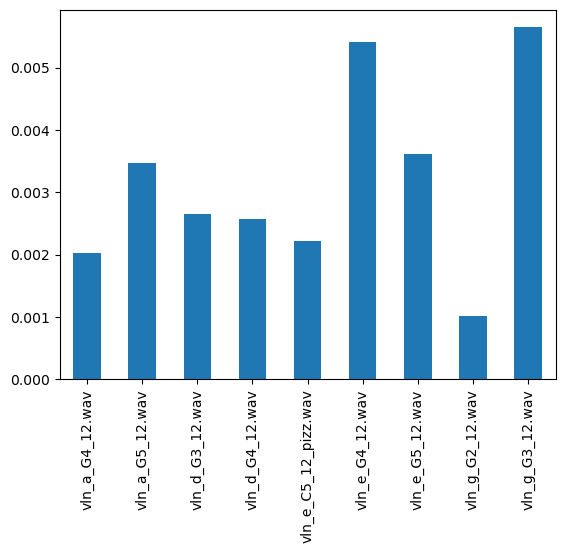

12


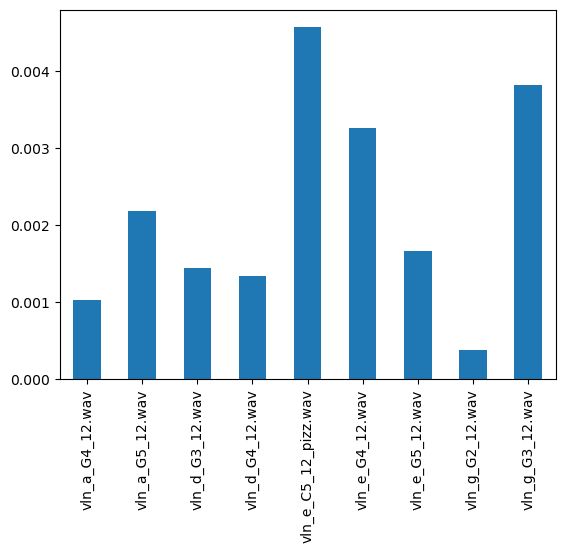

13


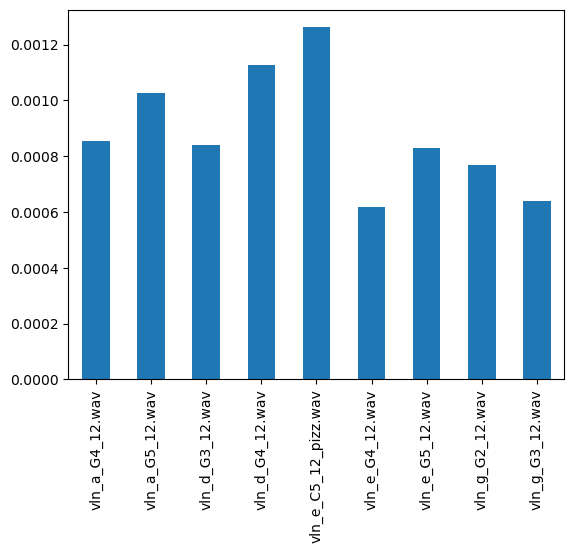

14


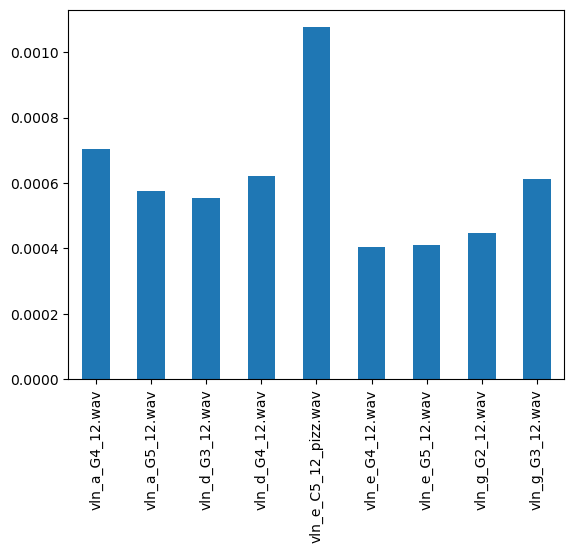

In [514]:
for instrument in range(0,12):
    ploty = instru_dict[instrument]
    for row1 in range(0, 15):
        print(row1)
        soundDescriptorsDf[ploty].iloc[row1].plot(kind='bar')
        plt.show()

In [515]:
def detect_instrument(filename):
    fileVal, fileRate = librosa.load(filename)
    lat = log_attack_time(fileVal, fileRate, start=0.01, end=0.99)
    ed= effective_duration(fileVal, fileRate, threshold=0.05)

    tc = temporal_centroid(fileVal, fileRate)

    spec_cent = librosa.feature.spectral_centroid(y=fileVal, sr=fileRate)
    spec_cent_std = np.std(spec_cent)

    spec_bw = librosa.feature.spectral_bandwidth(y=fileVal, sr=fileRate)
    spec_bw_average = np.average(spec_bw)

    spec_flux = spectral_flux(fileVal)
    spec_flux_std = np.std(spec_flux)

    spec_flat = librosa.feature.spectral_flatness(y=fileVal)
    spec_flat_average = np.average(spec_flat)

    if(spec_flat_average > 0.0 and ed < 3 and spec_flux_std > 0.003 and tc < 13 and spec_cent_std < 500 and spec_bw_average > 1450):
        #print("Percursive")
        return 0
    else:
        #print("Non percursive")
        return 1

## Task 6

### Machine Learning

Can you solve tasks 4-6 using Machine Learning?
If so, show me and comment your results.

In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

for key in soundDescriptors:
    soundDescriptors[key].append(key[0:3])
soundDescriptorsDf = pd.DataFrame.from_dict(soundDescriptors, orient='index')
soundDescriptorsDf2 = soundDescriptorsDf[1:16]

scaled_df = pd.DataFrame(soundDescriptorsDf)
scaled_df.style

In [566]:
x = scaled_df.loc[:, 1:15]
y = scaled_df.loc[:, 16]
print(y)
print("--------")
print(x)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=3)
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier( 
    criterion='gini', 
    splitter='best', 
    max_depth=20, 
    min_samples_split=10, 
    min_samples_leaf=6, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None, 
    ccp_alpha=0.0
)
clf.fit(X_train, y_train)

acc_qu_G2_12.wav        acc
acc_qu_G3_12.wav        acc
acc_qu_G4_12.wav        acc
acc_qu_G5_1.wav         acc
acc_se_G0_12.wav        acc
                       ... 
vln_e_C5_12_pizz.wav    vln
vln_e_G4_12.wav         vln
vln_e_G5_12.wav         vln
vln_g_G2_12.wav         vln
vln_g_G3_12.wav         vln
Name: 16, Length: 70, dtype: object
--------
                            1         2         3         4         5   \
acc_qu_G2_12.wav      0.042789  0.033115  0.062602  0.038960 -0.437343   
acc_qu_G3_12.wav      0.034023  0.017763  0.081406  0.047808  0.518609   
acc_qu_G4_12.wav      0.021993  0.012595  0.081148  0.056935  0.320650   
acc_qu_G5_1.wav       0.007301  0.003250  0.101839  0.071665  0.479609   
acc_se_G0_12.wav      0.020606  0.014487  0.033527  0.014773 -0.161308   
...                        ...       ...       ...       ...       ...   
vln_e_C5_12_pizz.wav  0.004351  0.007453  0.043852  0.029426 -1.480086   
vln_e_G4_12.wav       0.016796  0.008660  0.195860  0.0

DecisionTreeClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=10)

In [567]:
y_pred = forest.predict(X_test)
print("Accuracy RF:", accuracy_score(y_test, y_pred))

predictions = clf.predict(X_test)
print("Accuracy DT:", accuracy_score(y_test, predictions))

Accuracy RF: 0.42857142857142855
Accuracy DT: 0.42857142857142855
